In [1]:
import os
os.chdir("/Users/xinhaoliu/Desktop/Research/Code/paste")

import scanpy as sc
import matplotlib.pyplot as plt

from src.paste.fractional_align import partial_pairwise_align_given_cost_matrix
from src.paste.helper import intersect, to_dense_array, extract_data_matrix, glmpca_distance
from spatial_coherence import calculate_convex_hull_spatial_coherence_score, calculate_spatial_coherence_for_alignment, calculate_convex_hull_unaligned_percentage, calculate_nonconsistent_edge_measure_for_alignment, calculate_nonconsistent_edge_score_for_alignment, calculate_convex_hull_noncosistent_edge_measure

%load_ext autoreload
%autoreload 2

In [2]:
def plot_score_curve(m_list, source_entropy_list, target_entropy_list):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    ax1.plot(m_list, source_entropy_list)
    ax1.set_xlim(1, 0)
    ax1.set_xticks([0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1])
    ax1.set_xlabel('m')
    ax1.set_ylabel('Spatial Coherence Score')
    ax1.set_title('Source slice')
    
    fig, ax2 = plt.subplots(figsize=(12, 8))
    ax2.plot(m_list, target_entropy_list)
    ax2.set_xlim(1, 0)
    ax2.set_xticks([0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1])
    ax2.set_xlabel('m')
    ax2.set_ylabel('Spatial Coherence Score')
    ax2.set_title('Target slice')
    
    plt.show()

def plot_percentage_curve(m_list, source_list, target_list):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    ax1.plot(m_list, source_list)
    ax1.set_xlim(1, 0)
    ax1.set_xticks([0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1])
    ax1.set_xlabel('m')
    ax1.set_ylabel('Convex hull unaligned percentage')
    ax1.set_title('Source slice')
    
    fig, ax2 = plt.subplots(figsize=(12, 8))
    ax2.plot(m_list, target_list)
    ax2.set_xlim(1, 0)
    ax2.set_xticks([0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1])
    ax2.set_xlabel('m')
    ax2.set_ylabel('Convex hull unaligned percentage')
    ax2.set_title('Target slice')
    
    plt.show()
    
def plot_edge_curve(m_list, source_list, target_list):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    ax1.plot(m_list, source_list)
    ax1.set_xlim(1, 0)
    ax1.set_xticks([0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1])
    ax1.set_xlabel('m')
    ax1.set_ylabel('Nonconsistent edge measure')
    ax1.set_title('Source slice')
    
    fig, ax2 = plt.subplots(figsize=(12, 8))
    ax2.plot(m_list, target_list)
    ax2.set_xlim(1, 0)
    ax2.set_xticks([0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1])
    ax2.set_xlabel('m')
    ax2.set_ylabel('Nonconsistent edge measure')
    ax2.set_title('Target slice')
    
    plt.show()
    
def plot_edge_score_curve(m_list, source_list, target_list):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    ax1.plot(m_list, source_list)
    ax1.set_xlim(1, 0)
    ax1.set_xticks([0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1])
    ax1.set_xlabel('m')
    ax1.set_ylabel('Nonconsistent edge score')
    ax1.set_title('Source slice')
    
    fig, ax2 = plt.subplots(figsize=(12, 8))
    ax2.plot(m_list, target_list)
    ax2.set_xlim(1, 0)
    ax2.set_xticks([0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1])
    ax2.set_xlabel('m')
    ax2.set_ylabel('Nonconsistent edge score')
    ax2.set_title('Target slice')
    
    plt.show()
    
m_to_run = [0.99, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]

In [ ]:
***
151673_00 - 151674_10
m=0.5
***

In [56]:
sliceA_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/151673/151673_overlap0.5_dropFalse_rotateFalse_resampleFalse_delta0.0_row0_col0.h5ad'
sliceB_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/151674/151674_overlap0.5_dropFalse_rotateFalse_resampleFalse_delta0.0_row1_col0.h5ad'
sliceA = sc.read_h5ad(sliceA_filename)
sliceB = sc.read_h5ad(sliceB_filename)
common_genes = intersect(sliceA.var.index, sliceB.var.index)
sliceA = sliceA[:, common_genes]
sliceB = sliceB[:, common_genes]

In [39]:
# Get transport cost matrix
A_X, B_X = to_dense_array(extract_data_matrix(sliceA, None)), to_dense_array(extract_data_matrix(sliceB, None))
M = glmpca_distance(A_X, B_X, latent_dim=50, filter=True)

Starting GLM-PCA...
Iteration: 0 | deviance=8.0549E+6
Iteration: 1 | deviance=8.0545E+6
Iteration: 2 | deviance=7.0488E+6
Iteration: 3 | deviance=6.8237E+6
Iteration: 4 | deviance=6.7316E+6
Iteration: 5 | deviance=6.6884E+6
Iteration: 6 | deviance=6.6626E+6
Iteration: 7 | deviance=6.6449E+6
Iteration: 8 | deviance=6.6320E+6
Iteration: 9 | deviance=6.6222E+6
Iteration: 10 | deviance=6.6145E+6
Iteration: 11 | deviance=6.6083E+6
Iteration: 12 | deviance=6.6033E+6
Iteration: 13 | deviance=6.5990E+6
Iteration: 14 | deviance=6.5955E+6
Iteration: 15 | deviance=6.5924E+6
Iteration: 16 | deviance=6.5897E+6
Iteration: 17 | deviance=6.5873E+6
Iteration: 18 | deviance=6.5852E+6
Iteration: 19 | deviance=6.5833E+6
Iteration: 20 | deviance=6.5817E+6
Iteration: 21 | deviance=6.5802E+6
Iteration: 22 | deviance=6.5788E+6
Iteration: 23 | deviance=6.5776E+6
Iteration: 24 | deviance=6.5765E+6
Iteration: 25 | deviance=6.5755E+6
Iteration: 26 | deviance=6.5745E+6
Iteration: 27 | deviance=6.5737E+6
Iteration:

In [40]:
m_to_pi_real0010_05 = {}
for m in m_to_run:
    pi, log = partial_pairwise_align_given_cost_matrix(sliceA, sliceB, M=M, alpha=0.1, m=m, armijo=False,
                                                       norm=True, return_obj=True, verbose=False)
    m_to_pi_real0010_05[m] = pi

0.99
True entropy is: 0.08094685508216211


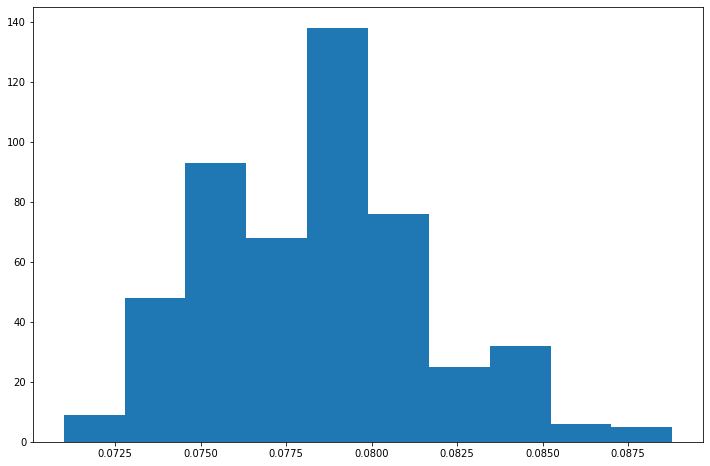

0.95
True entropy is: 0.29253355129155845


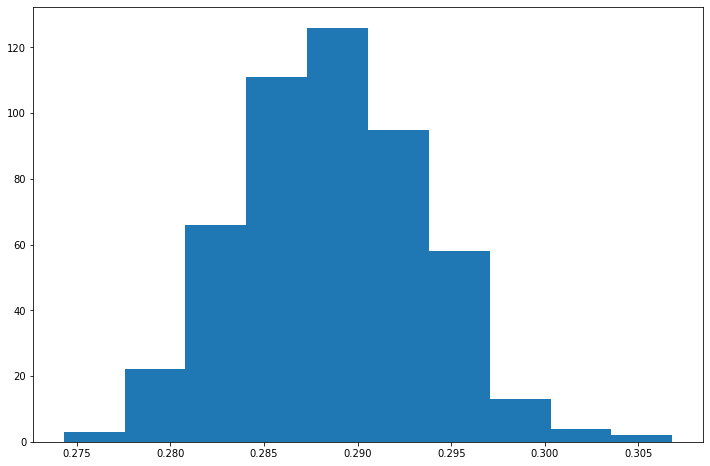

0.9
True entropy is: 0.4600673712764852


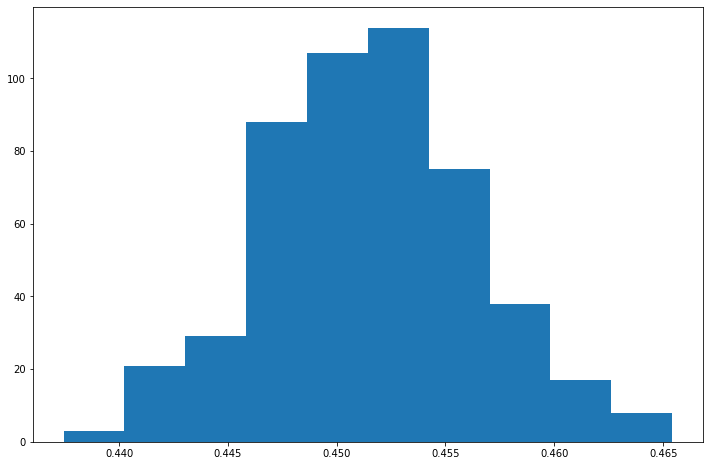

0.85
True entropy is: 0.5996079083779055


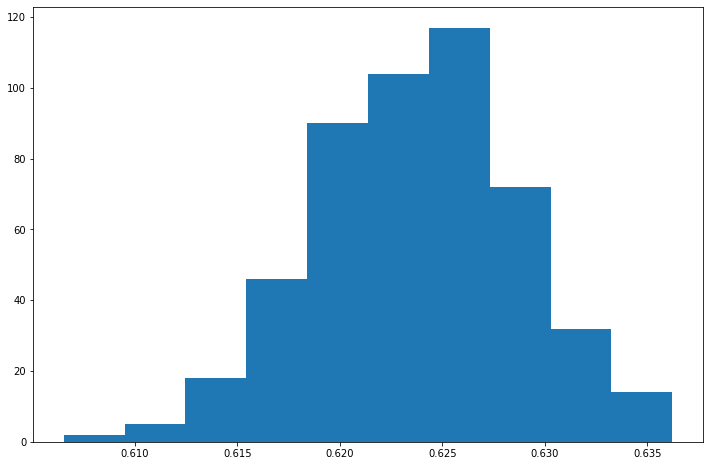

0.8
True entropy is: 0.6847834532338408


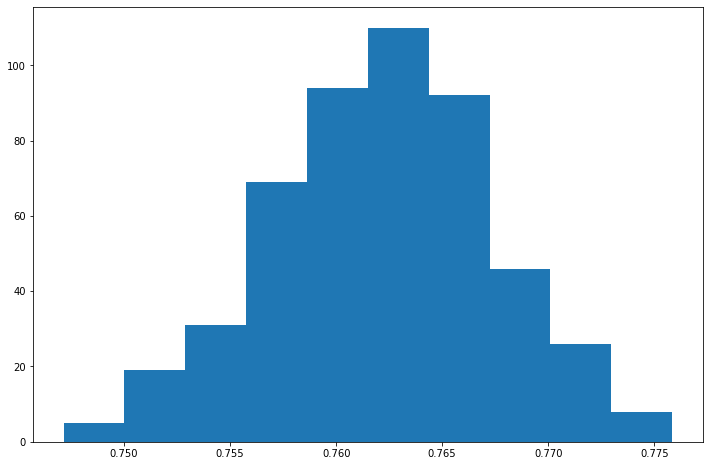

0.75
True entropy is: 0.7528720672325897


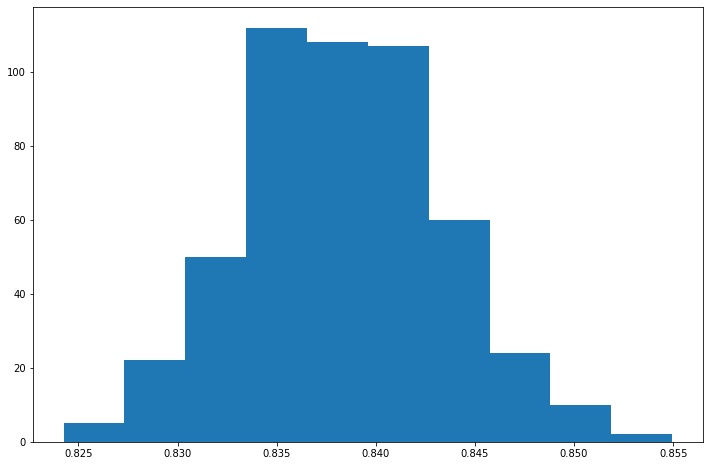

0.7
True entropy is: 0.8420011287485762


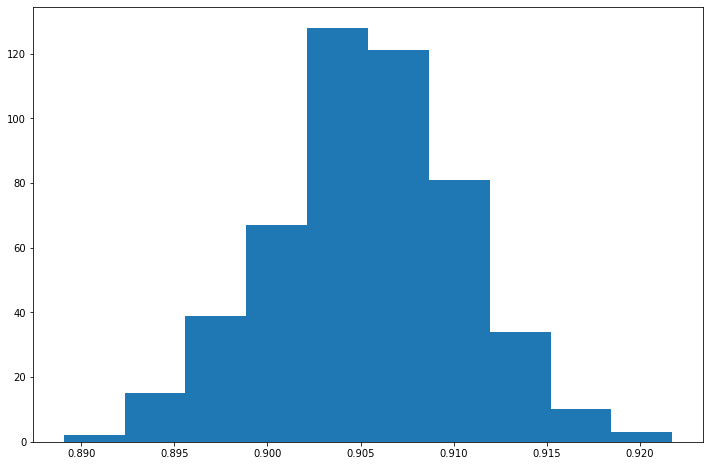

0.65
True entropy is: 0.9066461642439337


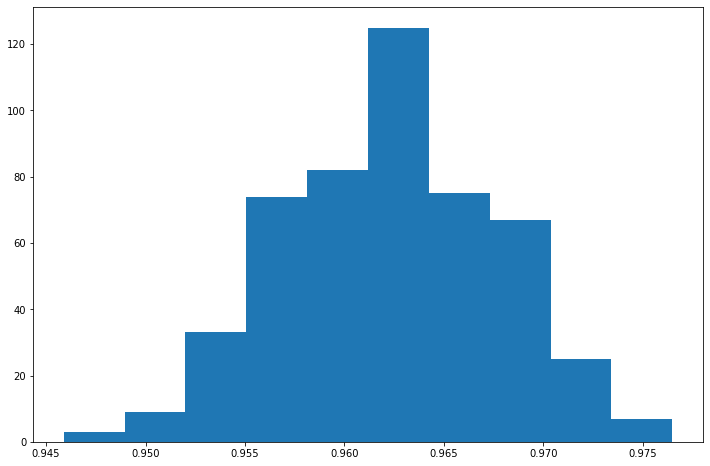

0.6
True entropy is: 0.9590087356026396


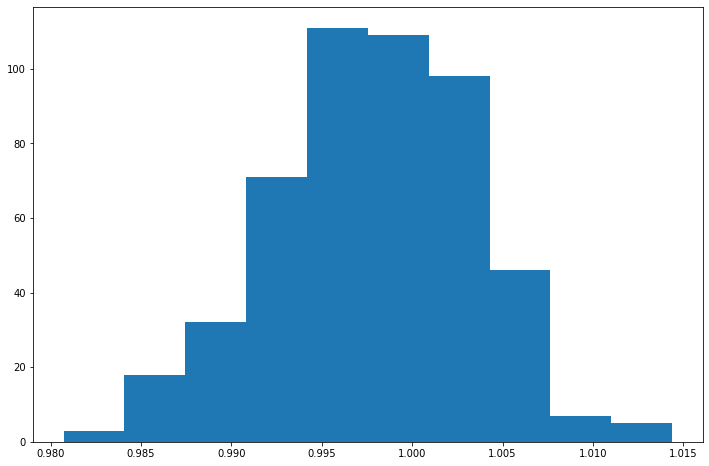

0.55
True entropy is: 0.9693116055451787


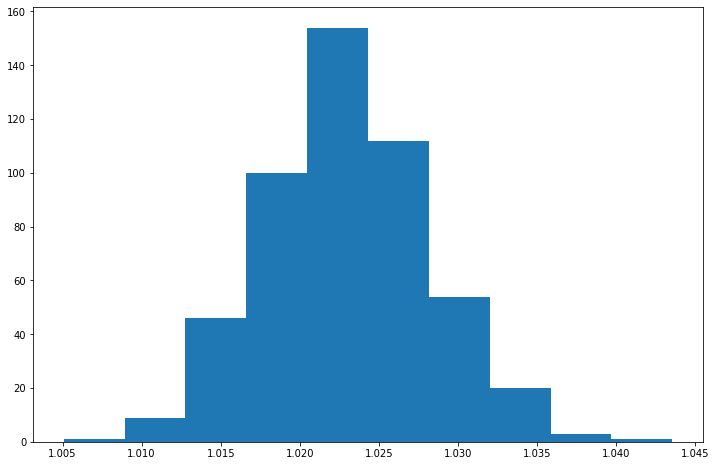

0.5
True entropy is: 1.0224493635632592


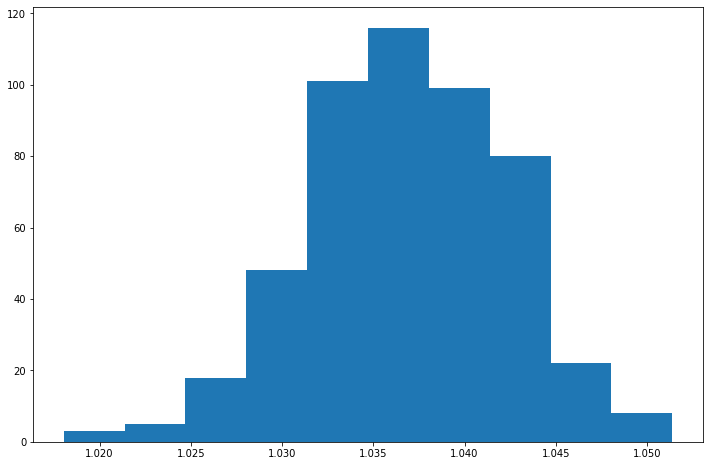

0.45
True entropy is: 1.041644681074955


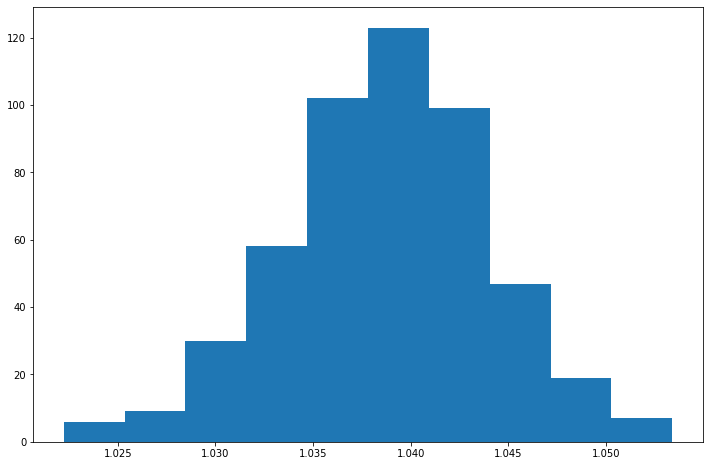

0.4
True entropy is: 1.048432580286597


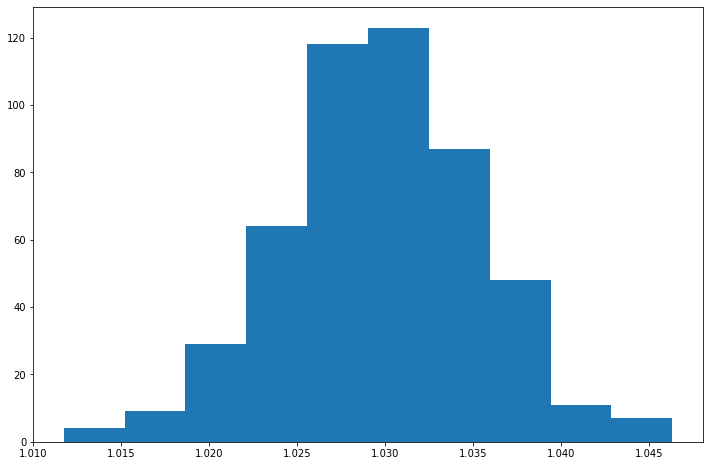

0.35
True entropy is: 1.030595554384593


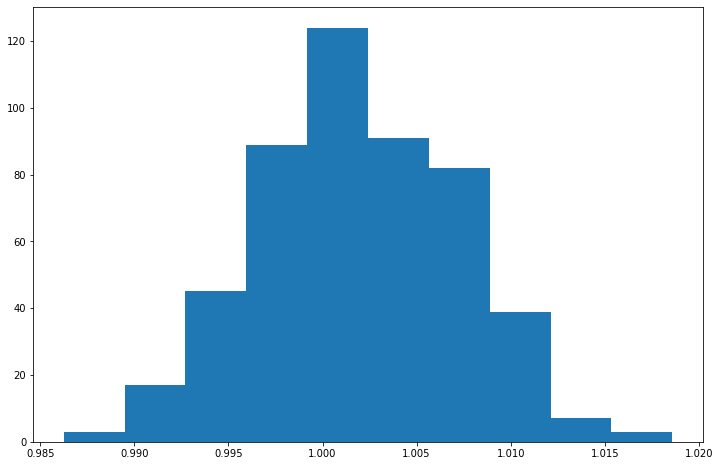

0.3
True entropy is: 0.9974831363733134


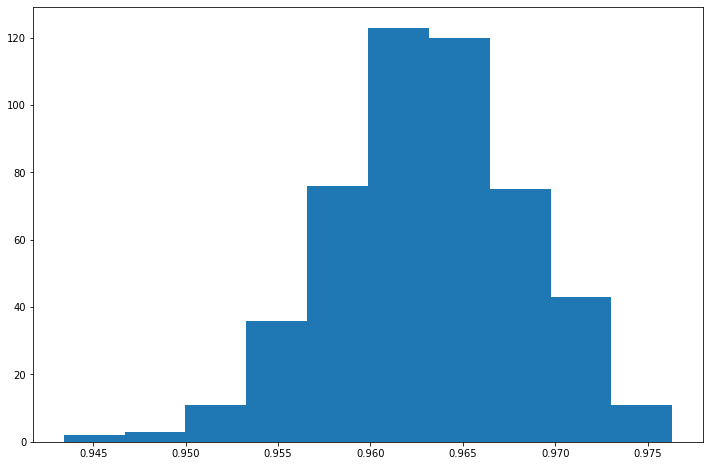

0.25
True entropy is: 0.9488990135573403


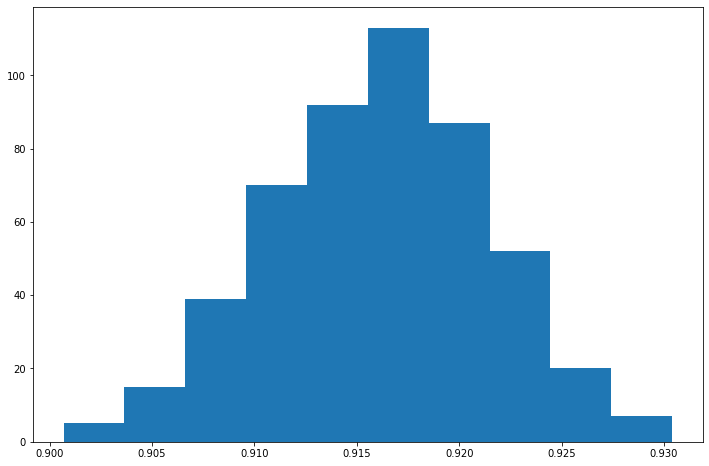

0.2
True entropy is: 0.8552157333063076


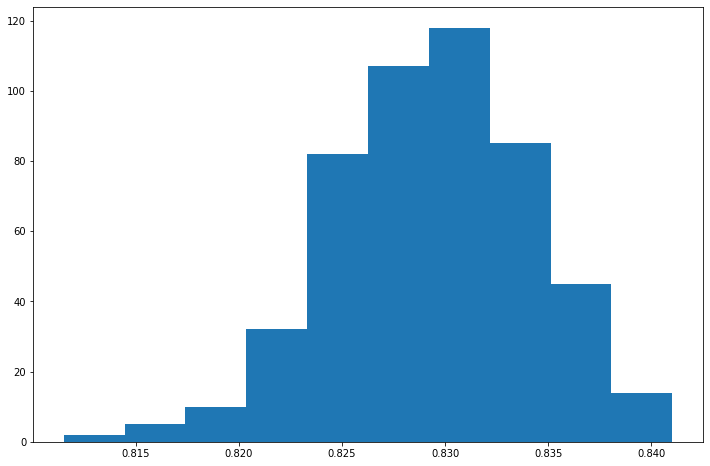

0.15
True entropy is: 0.7411580804984493


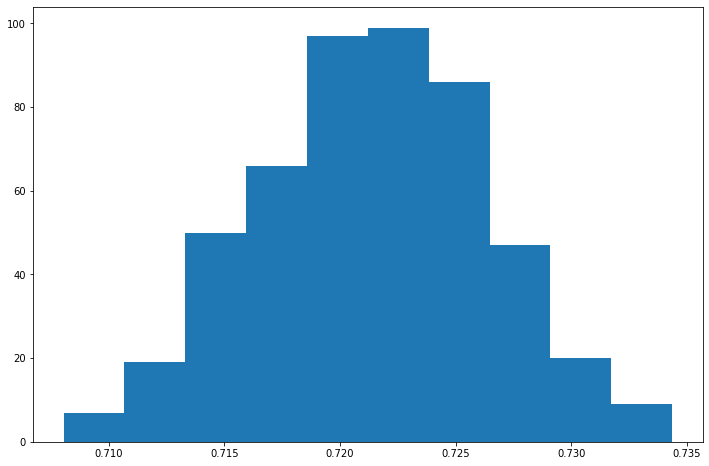

0.1
True entropy is: 0.5798783549819577


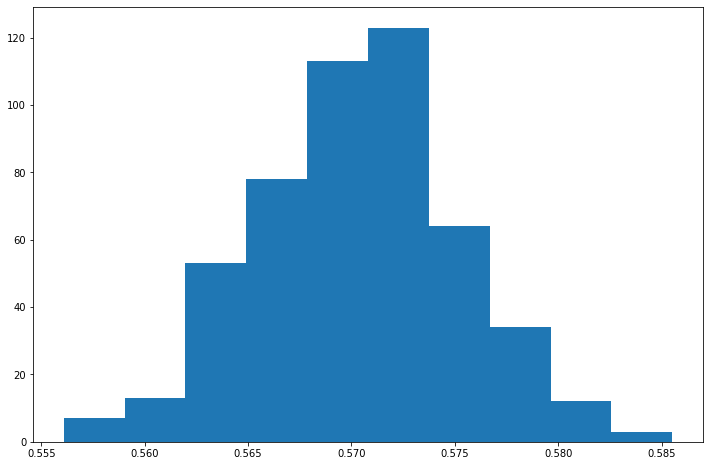

0.05
True entropy is: 0.38688078370413026


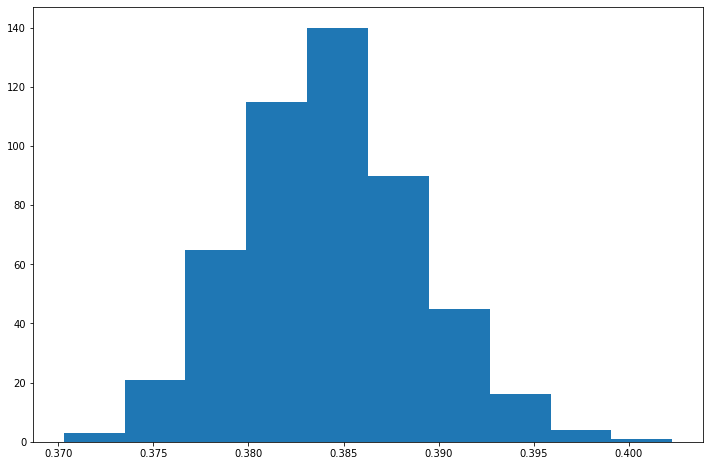

In [32]:
from spatial_coherence import get_spatial_entropy_distribution

for m in m_to_run:
    print(m)
    distribution = get_spatial_entropy_distribution(sliceA, sliceB, m_to_pi_real0010_05[m])
    plt.figure(figsize=(12, 8))
    plt.hist(distribution)
    plt.show()

whole slice spatial coherence score


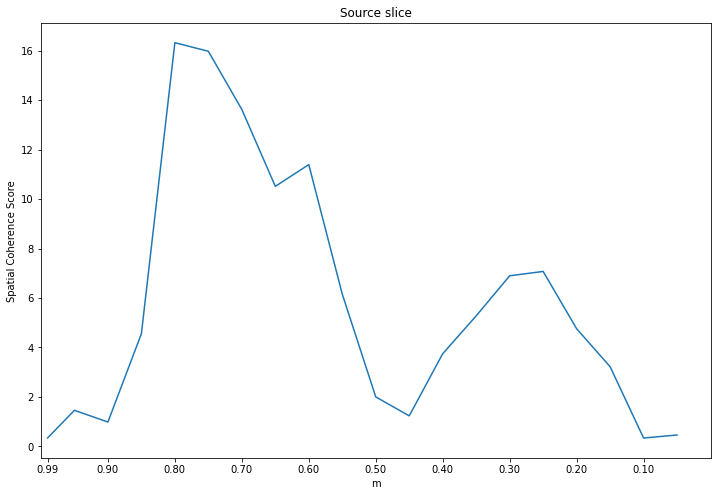

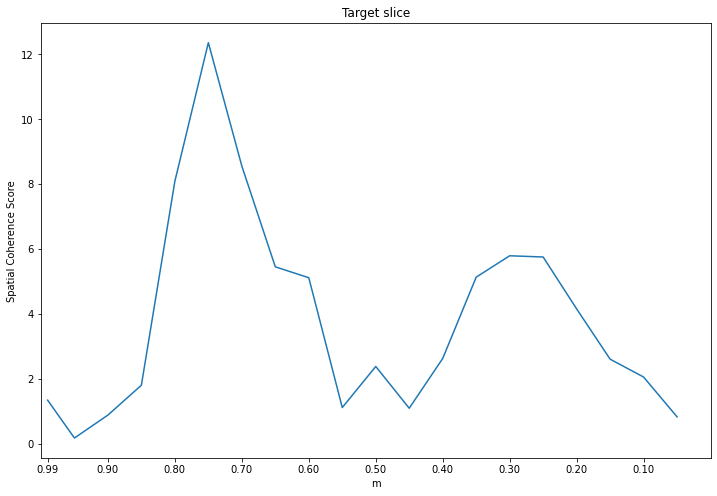

In [57]:
print("whole slice spatial coherence score")
sliceA_scores = []
sliceB_scores = []
for m in m_to_run:
    pi = m_to_pi_real0010_05[m]
    sliceA_score, sliceB_score = calculate_spatial_coherence_for_alignment(sliceA, sliceB, pi)
    sliceA_scores.append(sliceA_score)
    sliceB_scores.append(sliceB_score)
    
plot_score_curve(m_to_run, sliceA_scores, sliceB_scores)

whole slice spatial coherence score


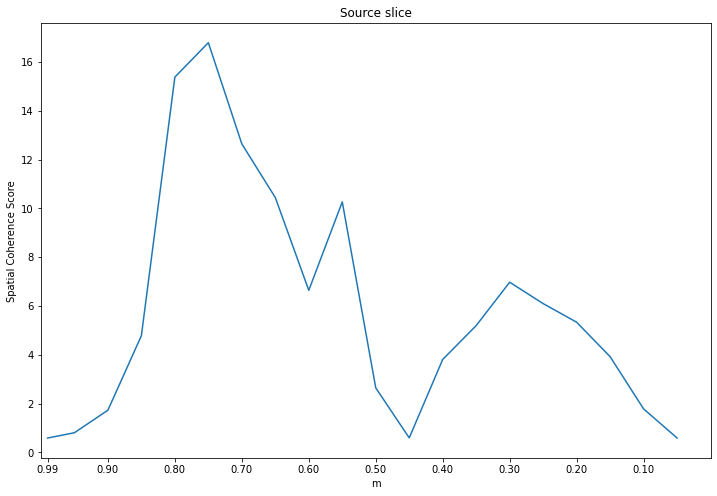

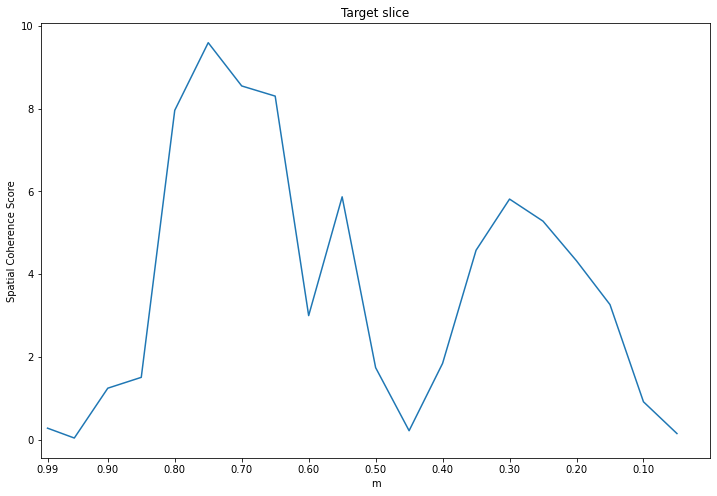

In [7]:
# 200
print("whole slice spatial coherence score")
sliceA_scores = []
sliceB_scores = []
for m in m_to_run:
    pi = m_to_pi_real0010_05[m]
    sliceA_score, sliceB_score = calculate_spatial_coherence_for_alignment(sliceA, sliceB, pi)
    sliceA_scores.append(sliceA_score)
    sliceB_scores.append(sliceB_score)
    
plot_score_curve(m_to_run, sliceA_scores, sliceB_scores)

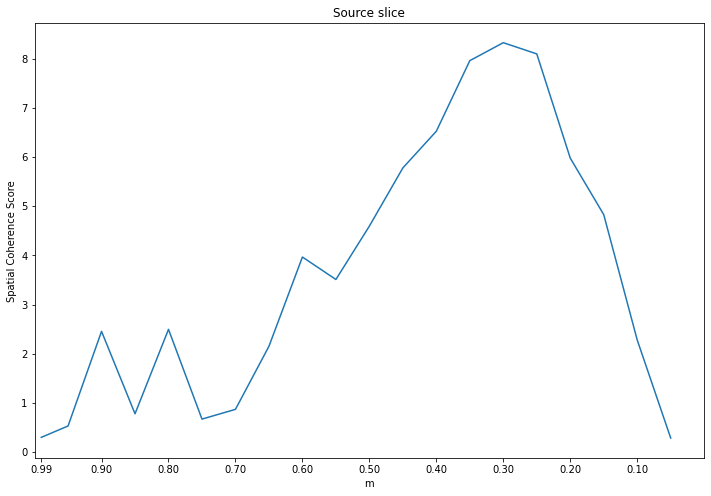

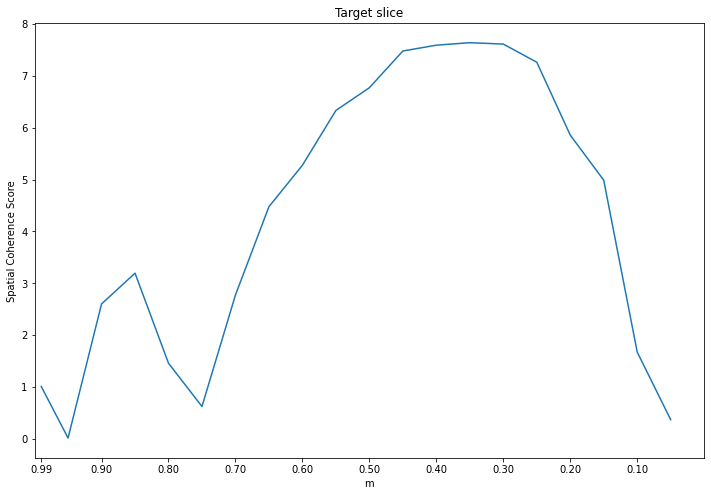

In [11]:
print("convex hull spatial coherence score")
sliceA_scores = []
sliceB_scores = []
for m in m_to_run:
    pi = m_to_pi_real0010_05[m]
    sliceA_score, sliceB_score = calculate_convex_hull_spatial_coherence_score(sliceA, sliceB, pi)
    sliceA_scores.append(sliceA_score)
    sliceB_scores.append(sliceB_score)
    
plot_score_curve(m_to_run, sliceA_scores, sliceB_scores)

convex hull unaligned percentage


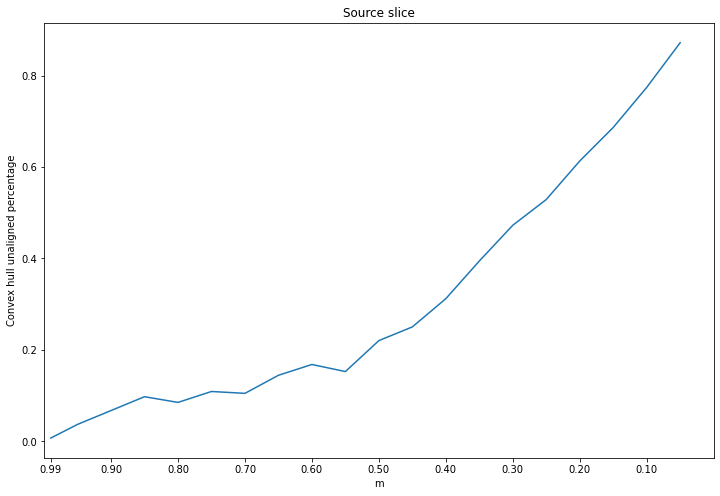

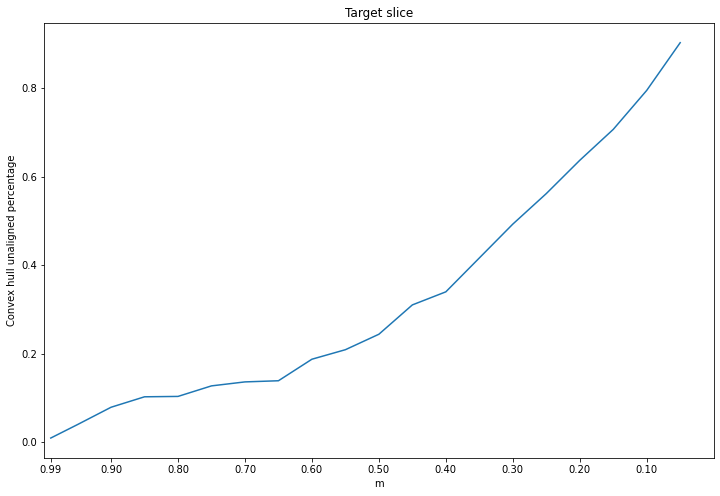

In [17]:
print("convex hull unaligned percentage")
sliceA_percentages = []
sliceB_percentages = []
for m in m_to_run:
    pi = m_to_pi_real0010_05[m]
    sliceA_percentage, sliceB_percentage = calculate_convex_hull_unaligned_percentage(sliceA, sliceB, pi)
    sliceA_percentages.append(sliceA_percentage)
    sliceB_percentages.append(sliceB_percentage)
    
plot_percentage_curve(m_to_run, sliceA_percentages, sliceB_percentages)

0.99


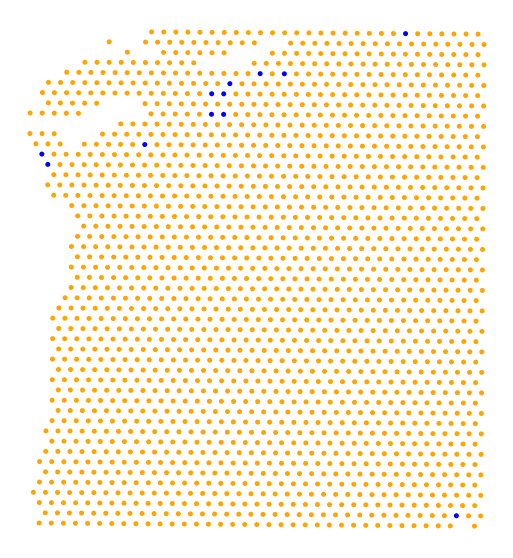

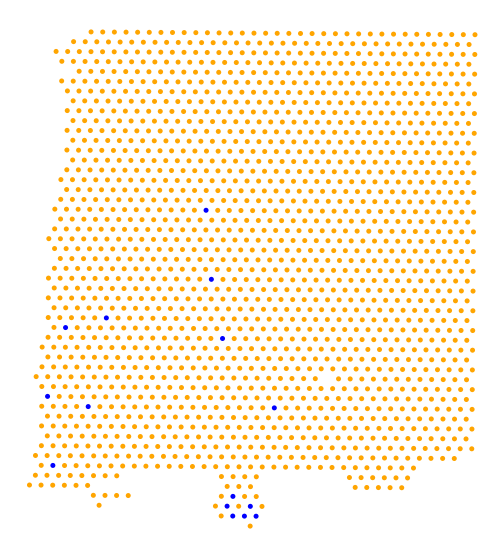

0.95


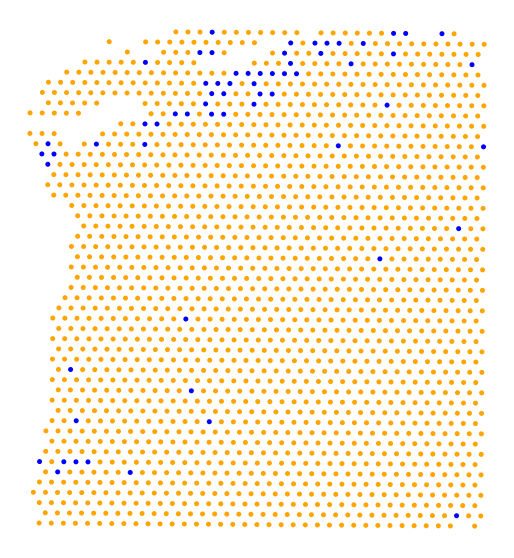

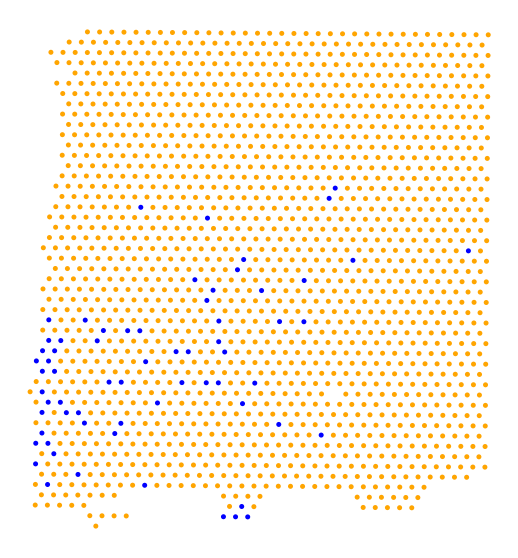

0.9


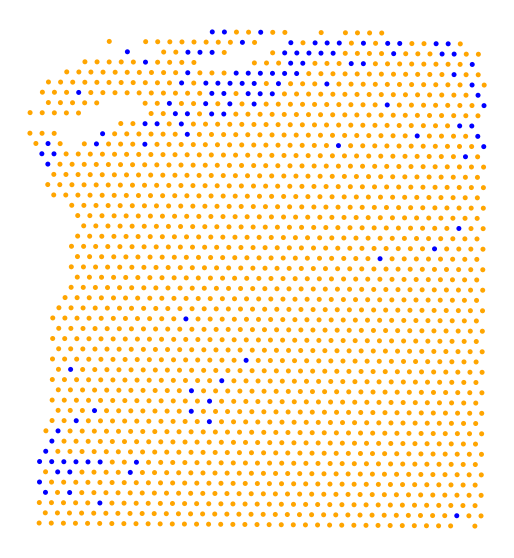

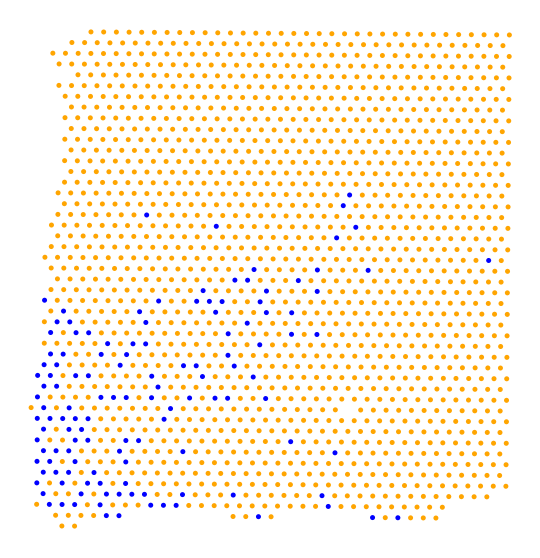

0.85


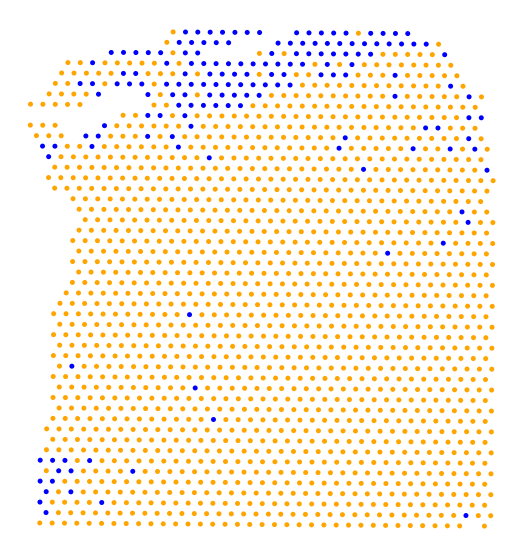

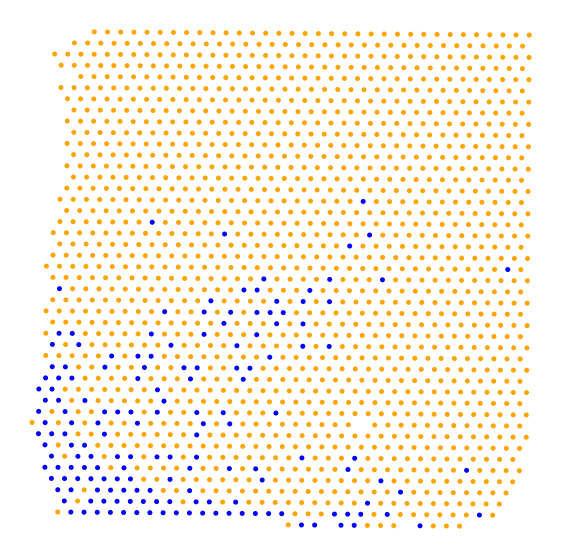

0.8


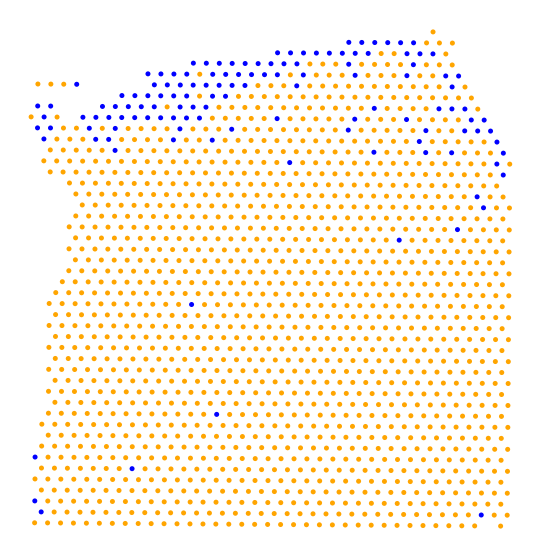

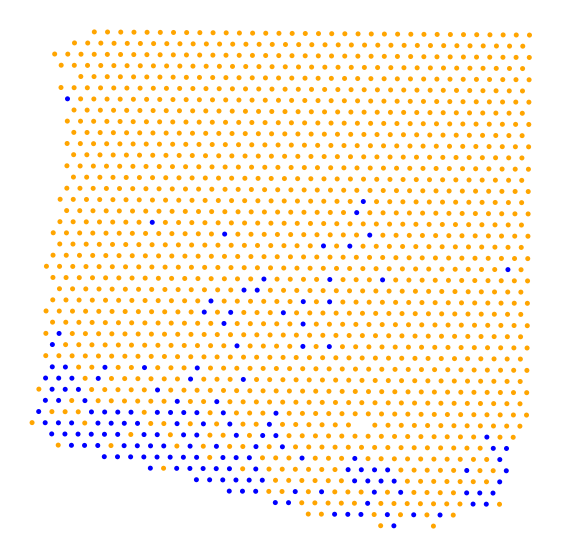

0.75


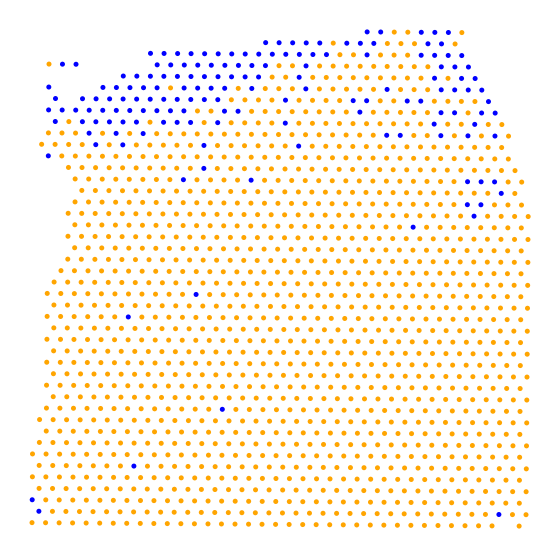

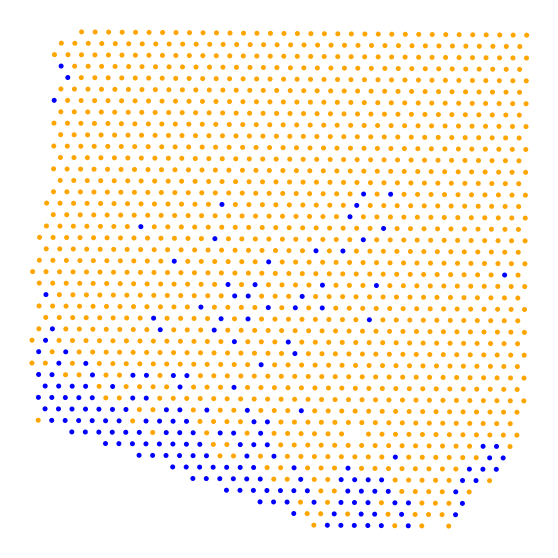

0.7


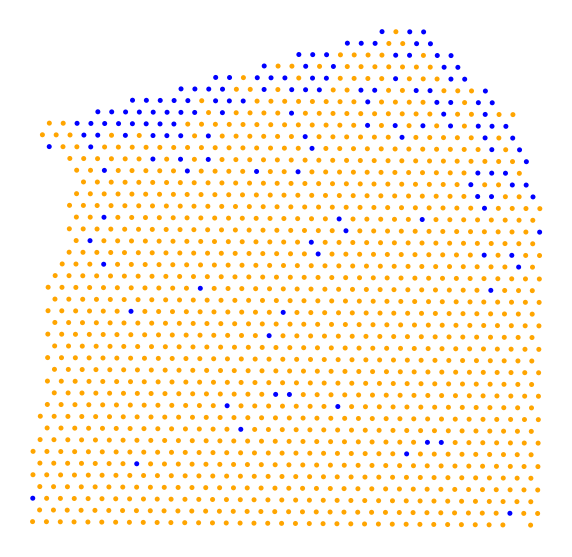

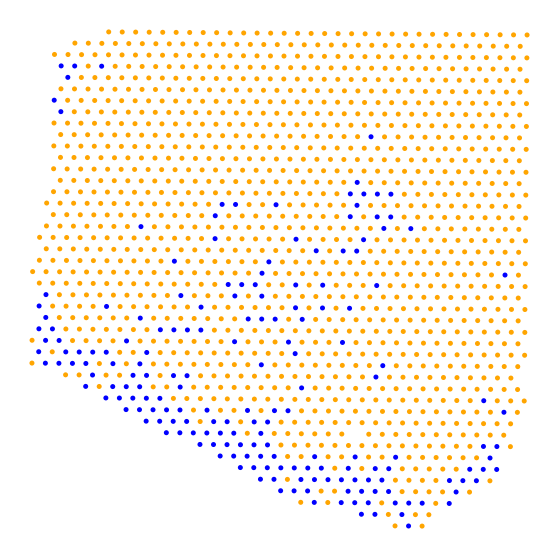

0.65


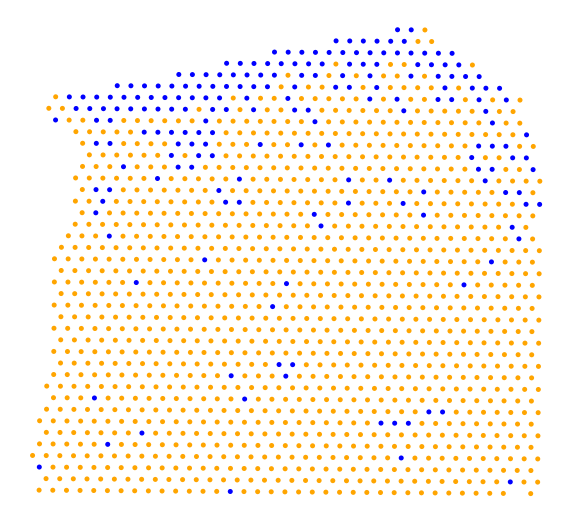

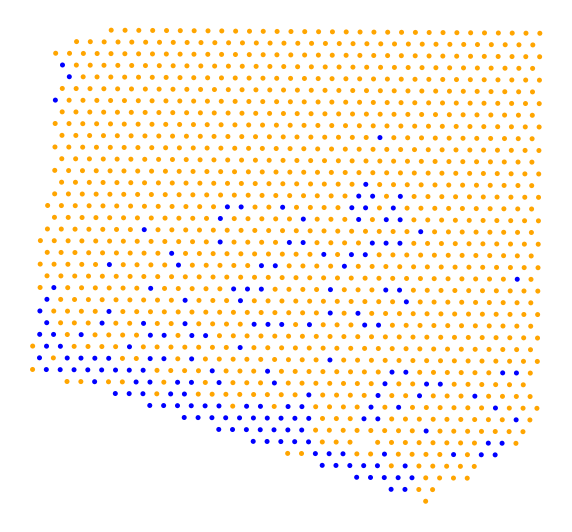

0.6


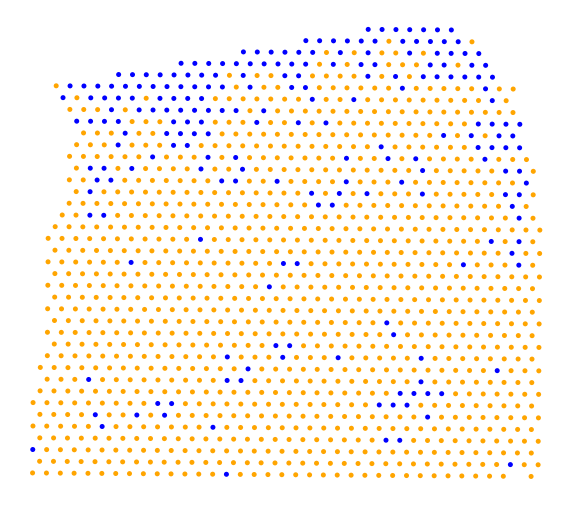

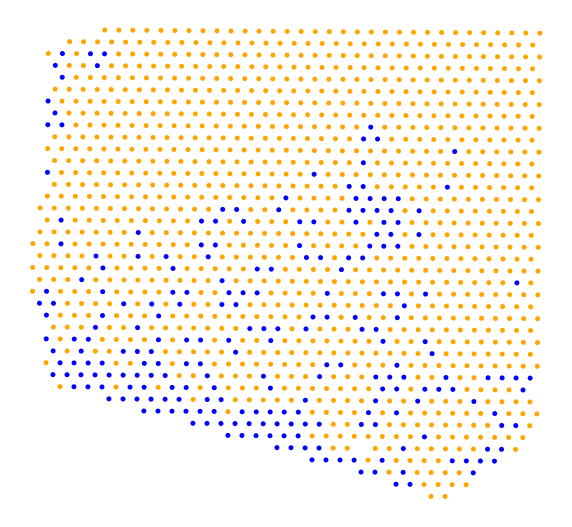

0.55


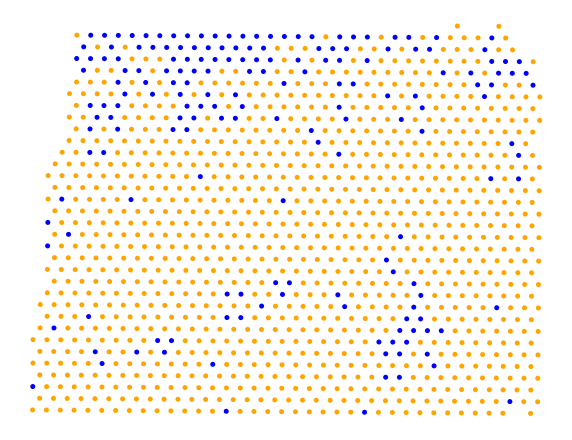

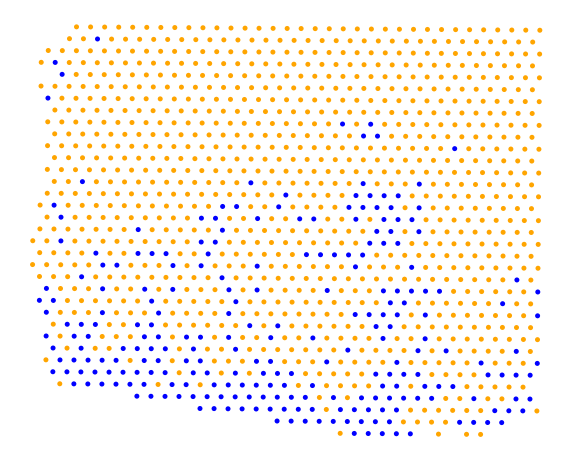

0.5


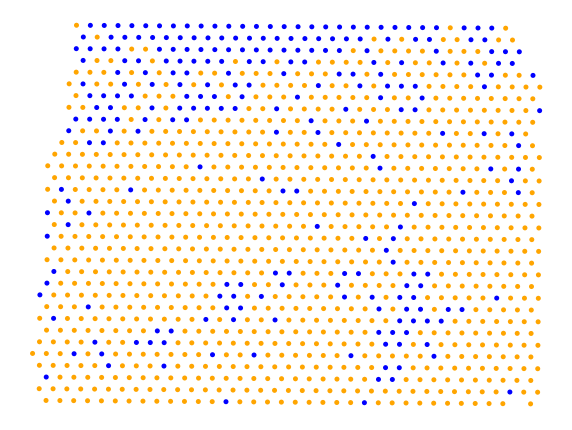

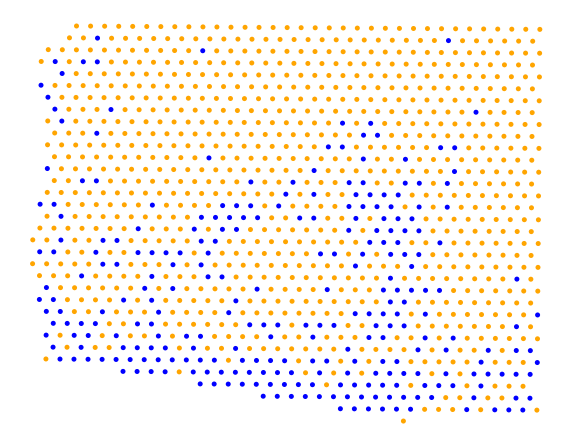

0.45


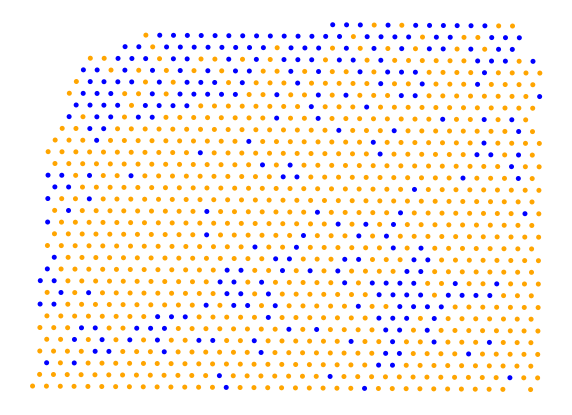

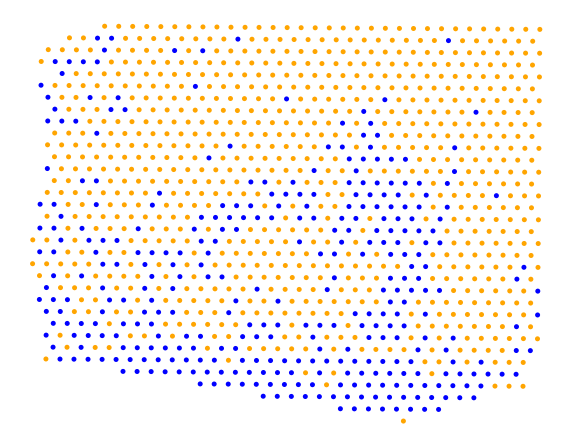

0.4


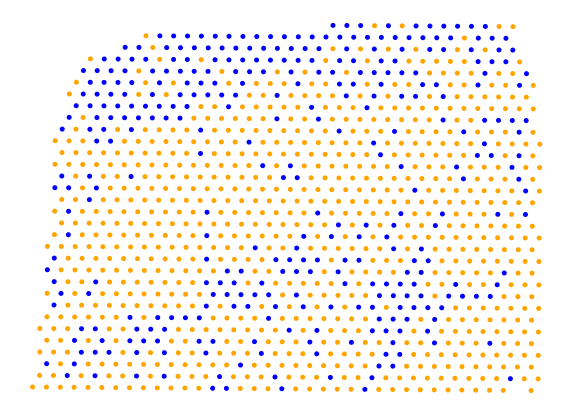

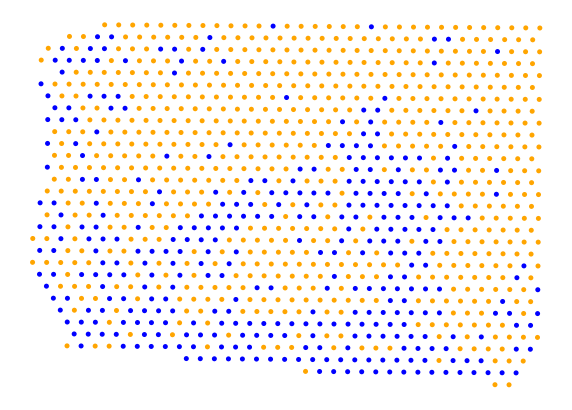

0.35


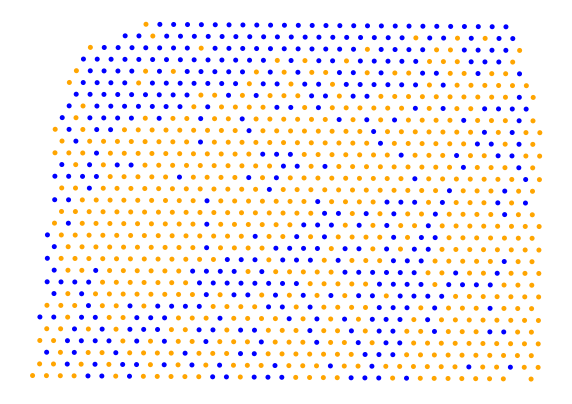

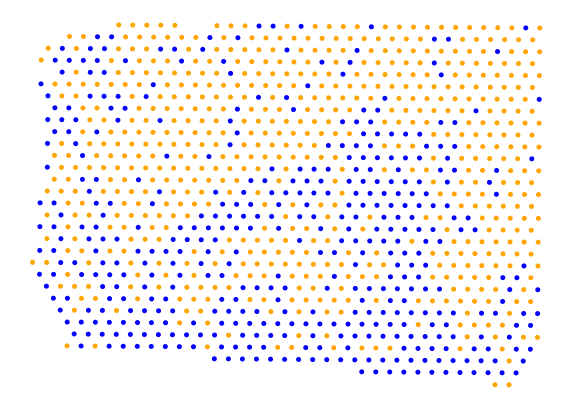

0.3


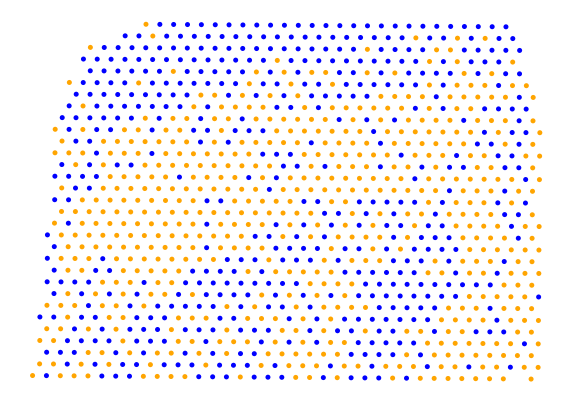

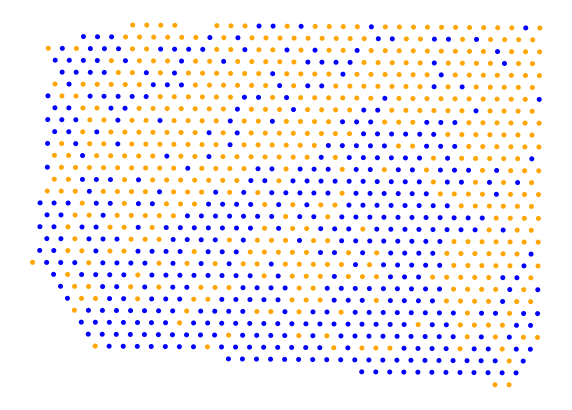

0.25


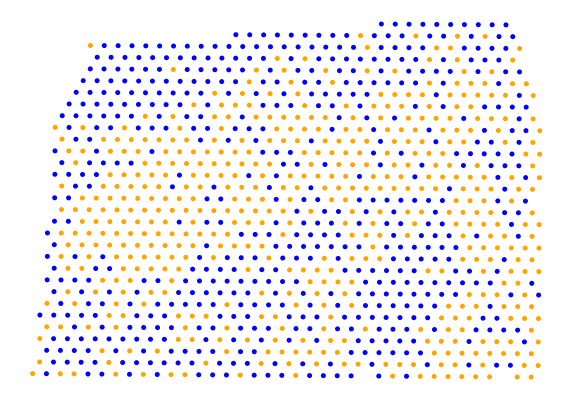

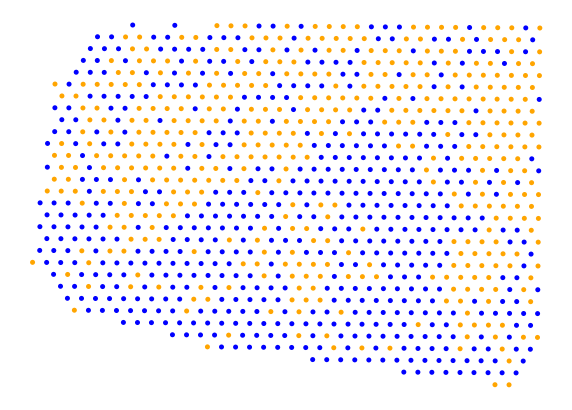

0.2


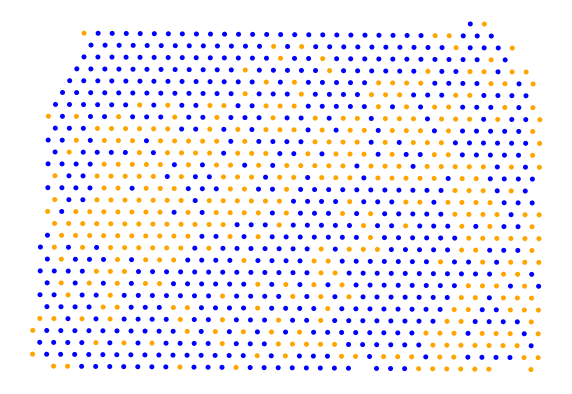

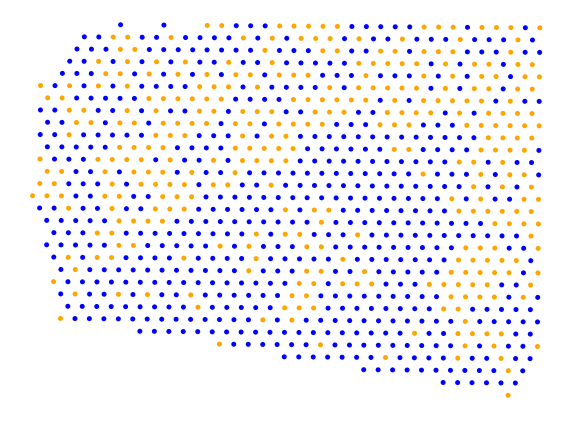

0.15


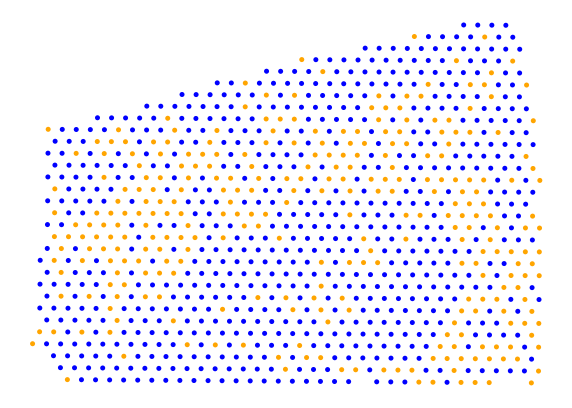

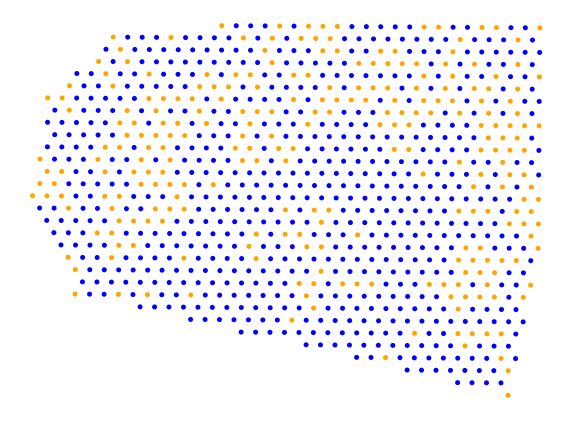

0.1


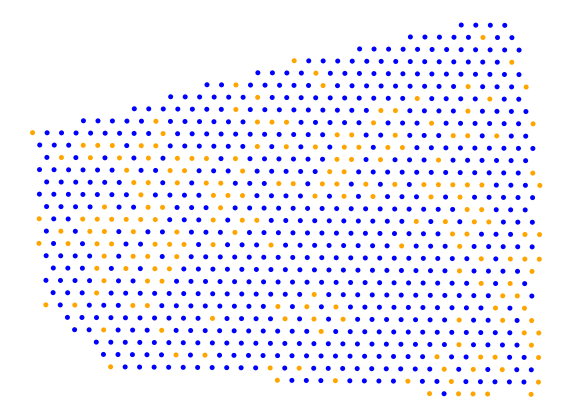

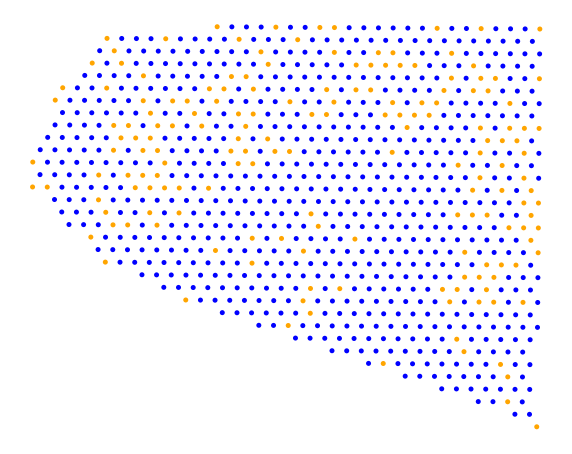

0.05


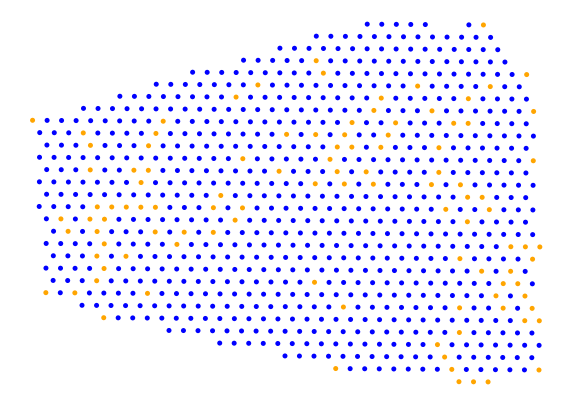

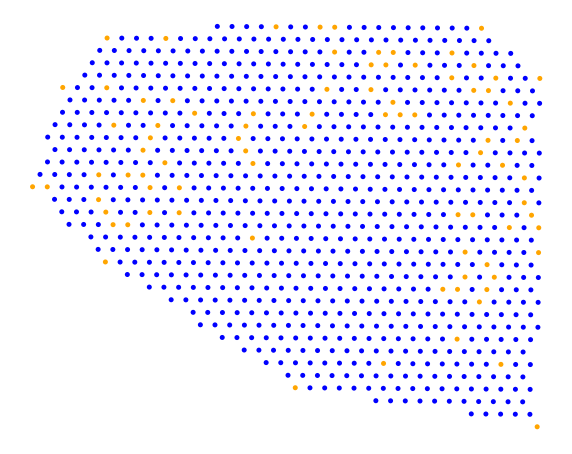

In [26]:
from convex_hull import visualize_convex_hull
for m in m_to_run:
    print(m)
    pi = m_to_pi_real0010_05[m]
    visualize_convex_hull(sliceA, sliceB, pi)

whole slice nonconsistent edge measure


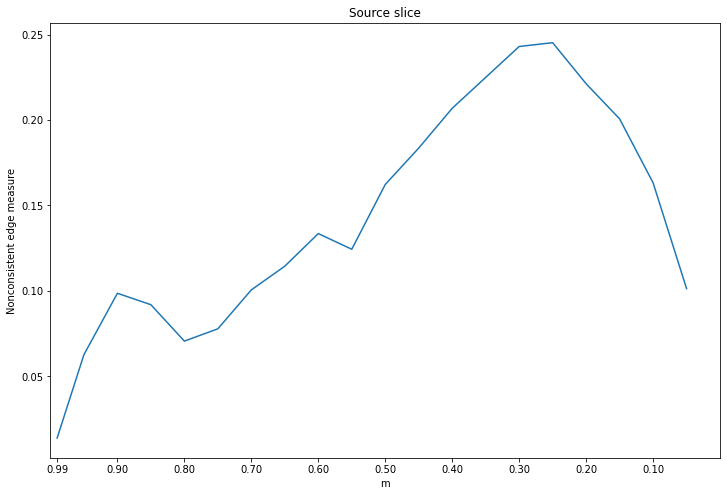

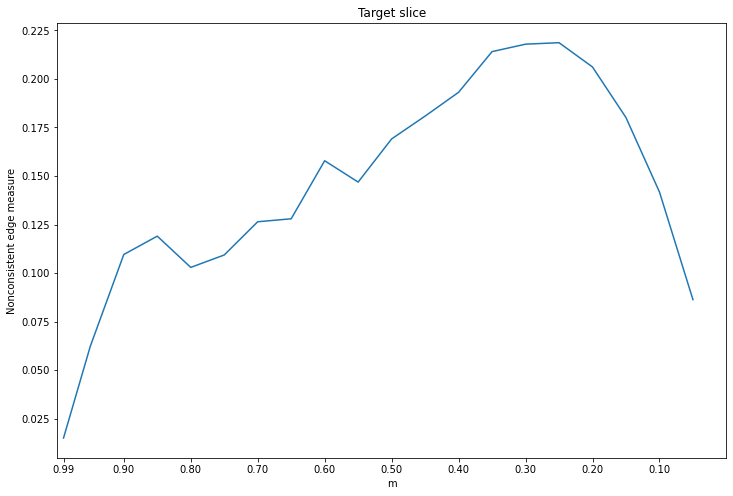

In [42]:
print("whole slice nonconsistent edge measure")
sliceA_measures = []
sliceB_measures = []
for m in m_to_run:
    pi = m_to_pi_real0010_05[m]
    sliceA_measure, sliceB_measure = calculate_nonconsistent_edge_measure_for_alignment(sliceA, sliceB, pi)
    sliceA_measures.append(sliceA_measure)
    sliceB_measures.append(sliceB_measure)
    
plot_edge_curve(m_to_run, sliceA_measures, sliceB_measures)

whole slice nonconsistent edge score


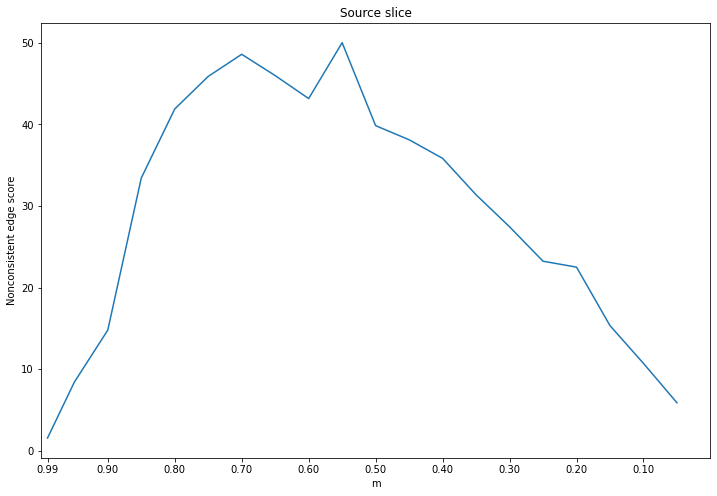

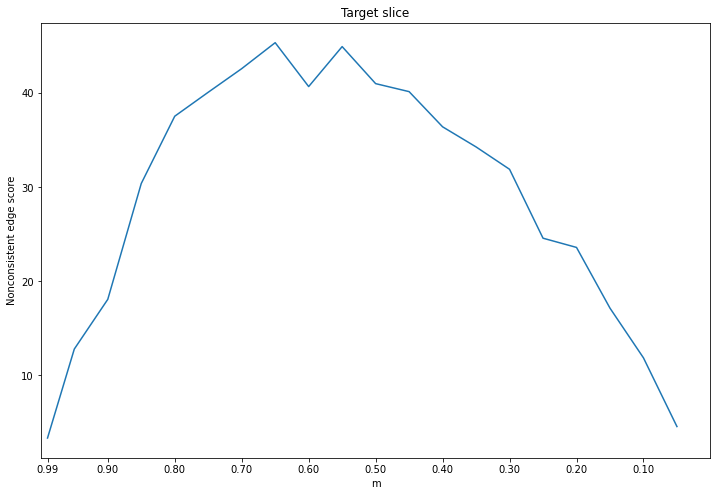

In [57]:
print("whole slice nonconsistent edge score")
sliceA_scores = []
sliceB_scores = []
for m in m_to_run:
    pi = m_to_pi_real0010_05[m]
    sliceA_score, sliceB_score = calculate_nonconsistent_edge_score_for_alignment(sliceA, sliceB, pi)
    sliceA_scores.append(sliceA_score)
    sliceB_scores.append(sliceB_score)
    
plot_edge_score_curve(m_to_run, sliceA_scores, sliceB_scores)

convex hull nonconsistent edge measure


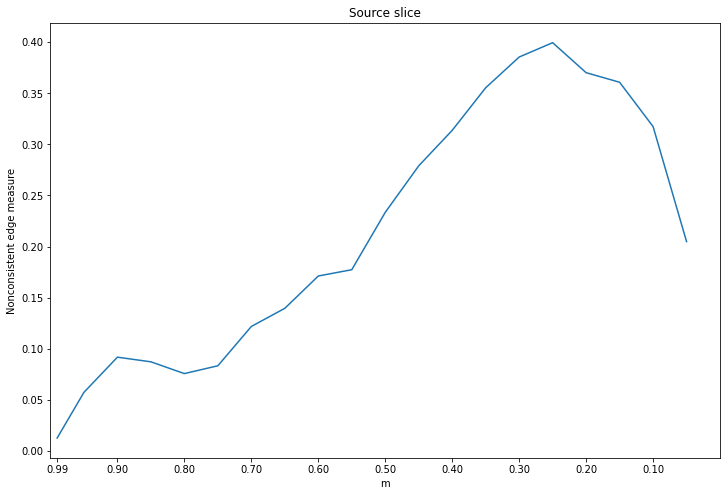

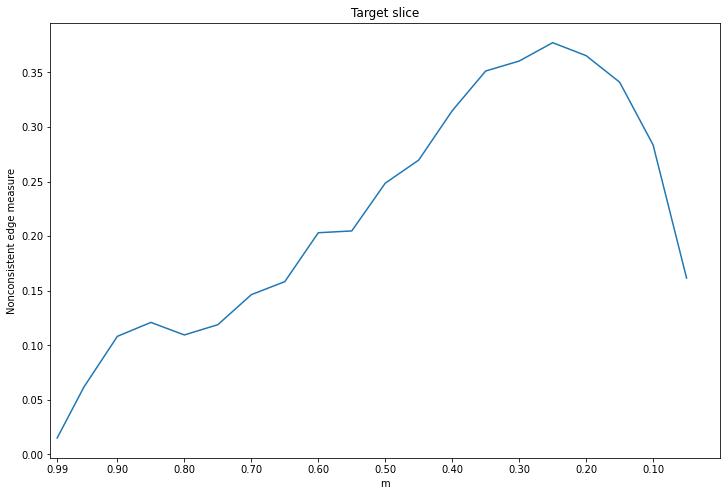

In [68]:
print("convex hull nonconsistent edge measure")
sliceA_measures = []
sliceB_measures = []
for m in m_to_run:
    pi = m_to_pi_real0010_05[m]
    sliceA_measure, sliceB_measure = calculate_convex_hull_noncosistent_edge_measure(sliceA, sliceB, pi)
    sliceA_measures.append(sliceA_measure)
    sliceB_measures.append(sliceB_measure)
    
plot_edge_curve(m_to_run, sliceA_measures, sliceB_measures)

In [ ]:
***
151673_00 - 151674_10
m=0.7
***

In [58]:
sliceA_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/151673/151673_overlap0.7_dropFalse_rotateFalse_resampleFalse_delta0.0_row0_col0.h5ad'
sliceB_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/151674/151674_overlap0.7_dropFalse_rotateFalse_resampleFalse_delta0.0_row1_col0.h5ad'
sliceA = sc.read_h5ad(sliceA_filename)
sliceB = sc.read_h5ad(sliceB_filename)
common_genes = intersect(sliceA.var.index, sliceB.var.index)
sliceA = sliceA[:, common_genes]
sliceB = sliceB[:, common_genes]

In [45]:
# Get transport cost matrix
A_X, B_X = to_dense_array(extract_data_matrix(sliceA, None)), to_dense_array(extract_data_matrix(sliceB, None))
M = glmpca_distance(A_X, B_X, latent_dim=50, filter=True)

Starting GLM-PCA...
Iteration: 0 | deviance=1.1096E+7
Iteration: 1 | deviance=1.1095E+7
Iteration: 2 | deviance=9.7147E+6
Iteration: 3 | deviance=9.4241E+6
Iteration: 4 | deviance=9.2975E+6
Iteration: 5 | deviance=9.2348E+6
Iteration: 6 | deviance=9.2008E+6
Iteration: 7 | deviance=9.1794E+6
Iteration: 8 | deviance=9.1645E+6
Iteration: 9 | deviance=9.1535E+6
Iteration: 10 | deviance=9.1450E+6
Iteration: 11 | deviance=9.1383E+6
Iteration: 12 | deviance=9.1329E+6
Iteration: 13 | deviance=9.1284E+6
Iteration: 14 | deviance=9.1246E+6
Iteration: 15 | deviance=9.1213E+6
Iteration: 16 | deviance=9.1185E+6
Iteration: 17 | deviance=9.1160E+6
Iteration: 18 | deviance=9.1138E+6
Iteration: 19 | deviance=9.1119E+6
Iteration: 20 | deviance=9.1101E+6
Iteration: 21 | deviance=9.1086E+6
Iteration: 22 | deviance=9.1071E+6
Iteration: 23 | deviance=9.1058E+6
Iteration: 24 | deviance=9.1047E+6
Iteration: 25 | deviance=9.1036E+6
Iteration: 26 | deviance=9.1026E+6
Iteration: 27 | deviance=9.1016E+6
GLM-PCA fi

In [46]:
m_to_pi_real0010_07 = {}
for m in m_to_run:
    pi, log = partial_pairwise_align_given_cost_matrix(sliceA, sliceB, M=M, alpha=0.1, m=m, armijo=False,
                                                       norm=True, return_obj=True, verbose=False)
    m_to_pi_real0010_07[m] = pi

0.99
True entropy is: 0.08290657125013032


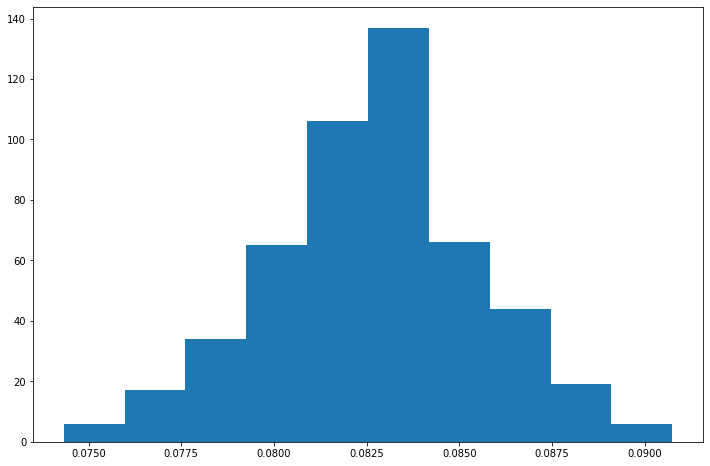

0.95
True entropy is: 0.29713804609482397


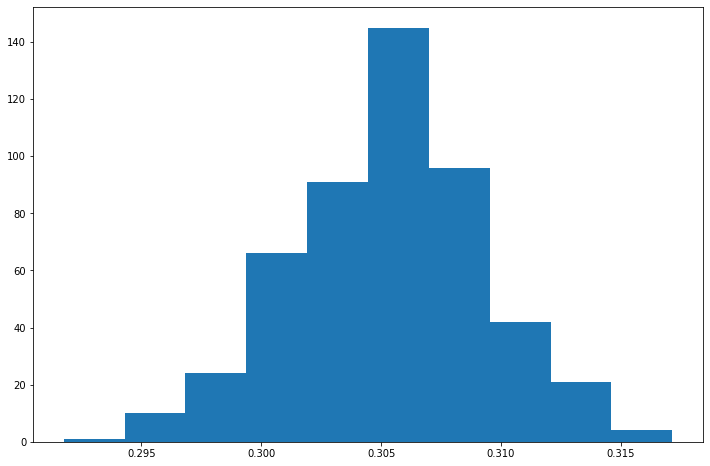

0.9
True entropy is: 0.4628463489470209


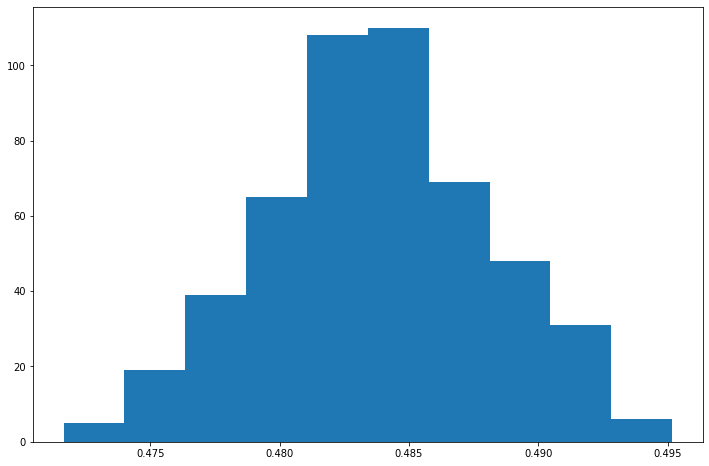

0.85
True entropy is: 0.5762928460238737


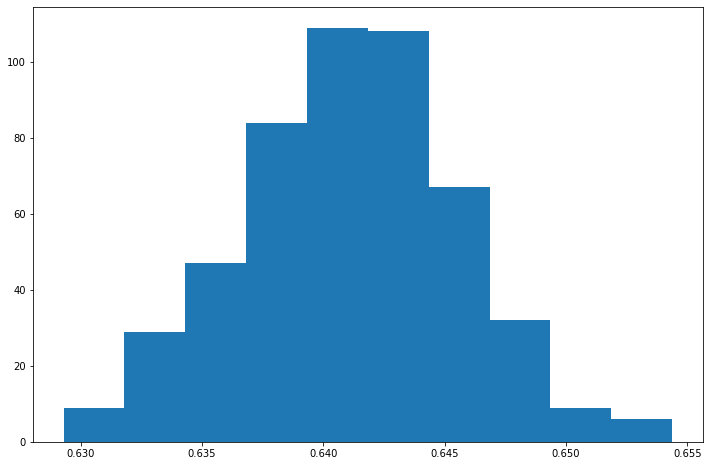

0.8
True entropy is: 0.6677101719027084


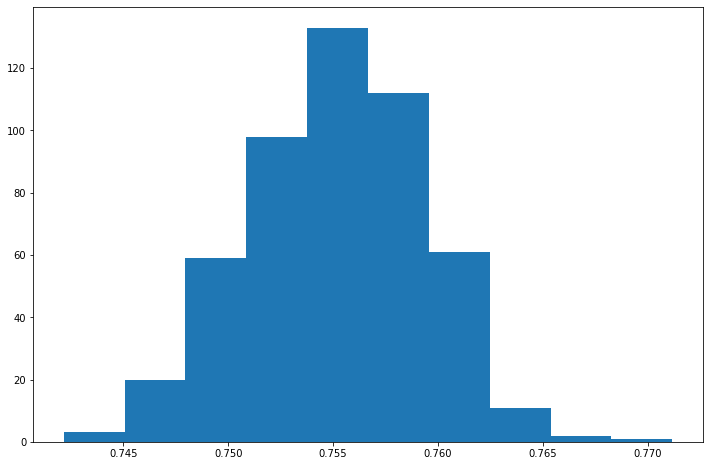

0.75
True entropy is: 0.7759501510043296


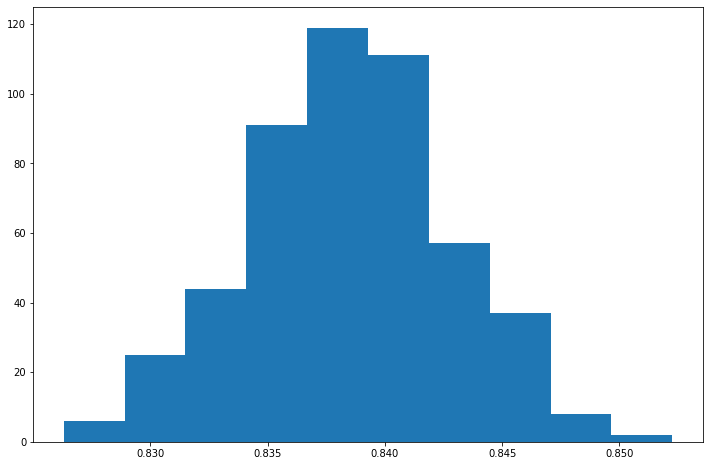

0.7
True entropy is: 0.8734046099910132


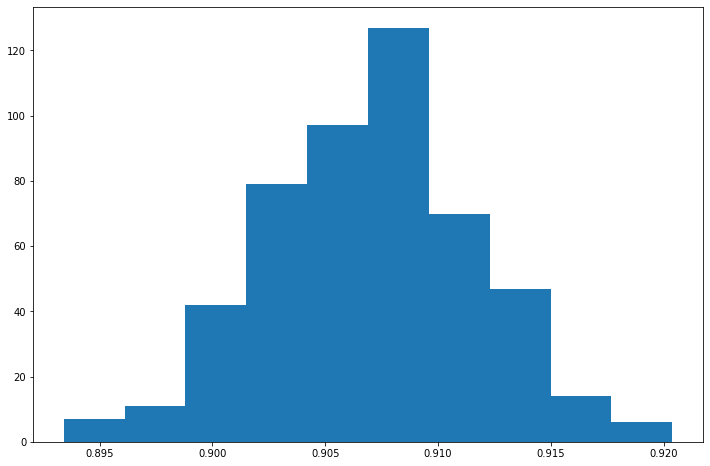

0.65
True entropy is: 0.948130593508687


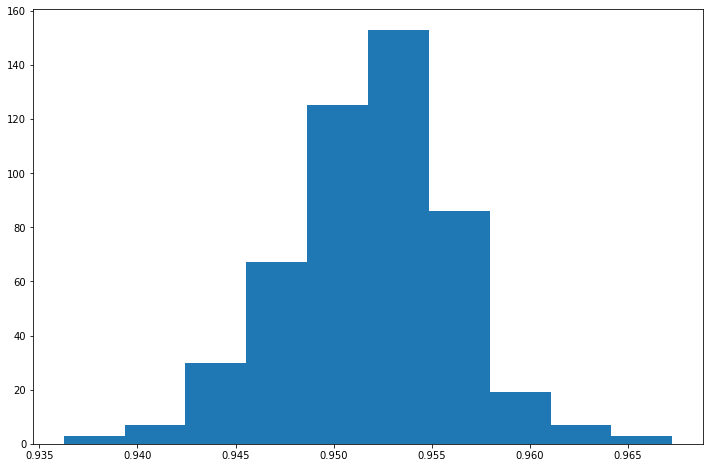

0.6
True entropy is: 1.0151472339703052


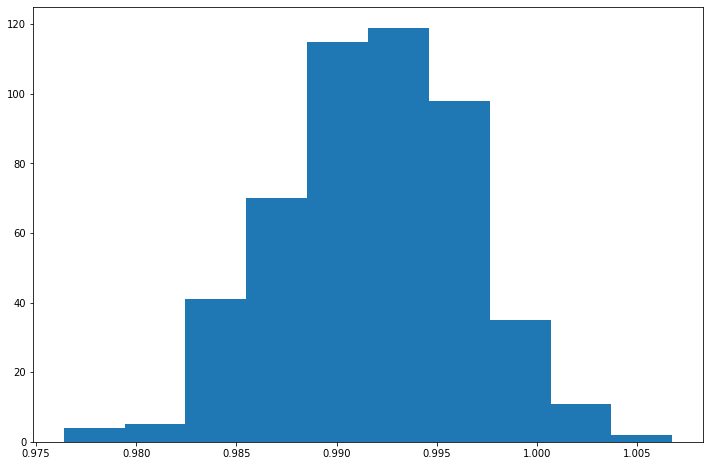

0.55
True entropy is: 1.0628805360184308


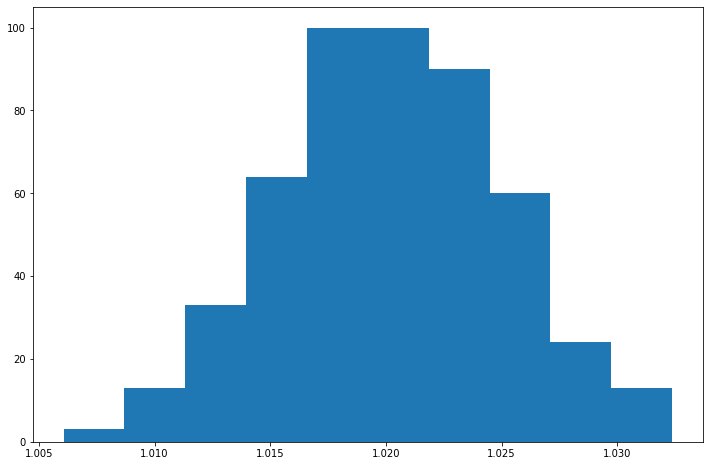

0.5
True entropy is: 1.0899500647710587


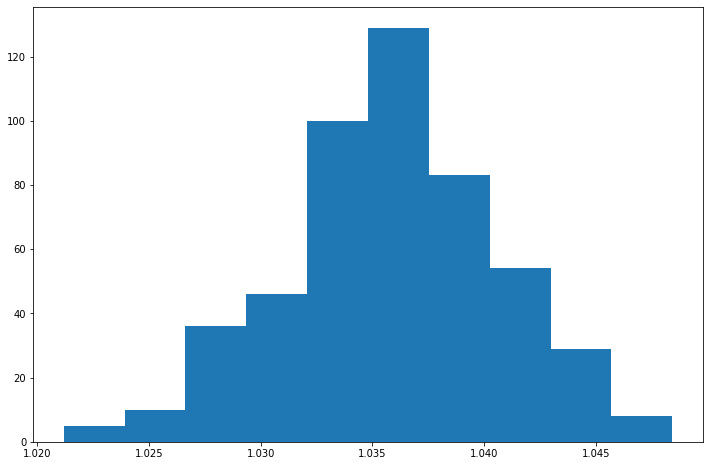

0.45
True entropy is: 1.094302542398224


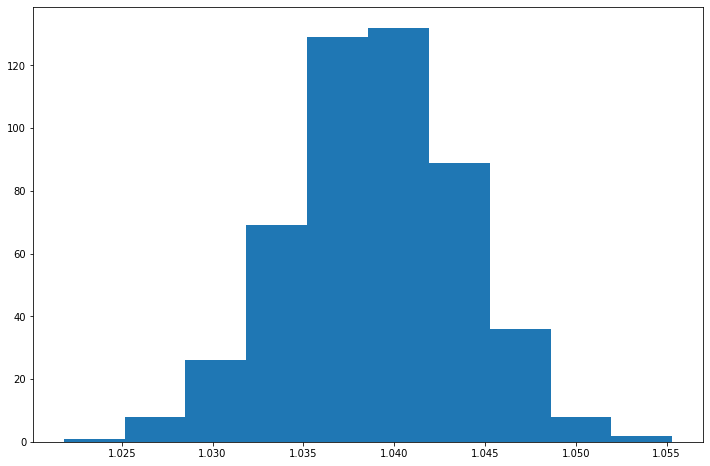

0.4
True entropy is: 1.0829460261814903


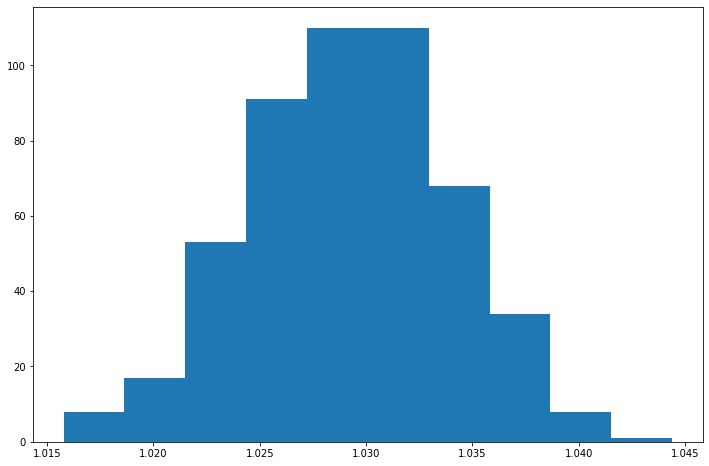

0.35
True entropy is: 1.0544718228791987


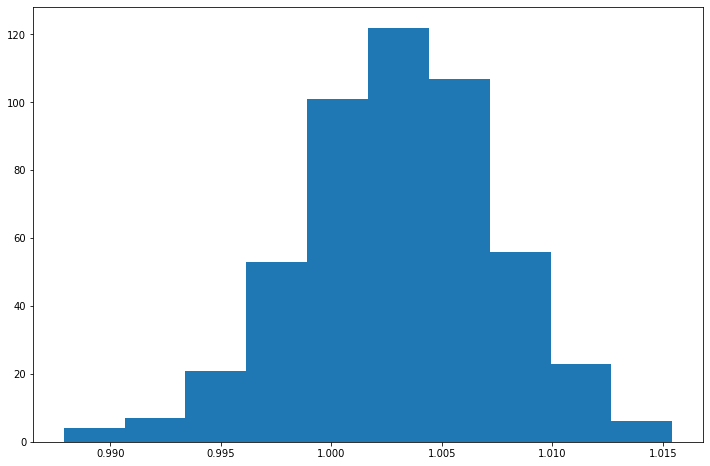

0.3
True entropy is: 1.016866350696489


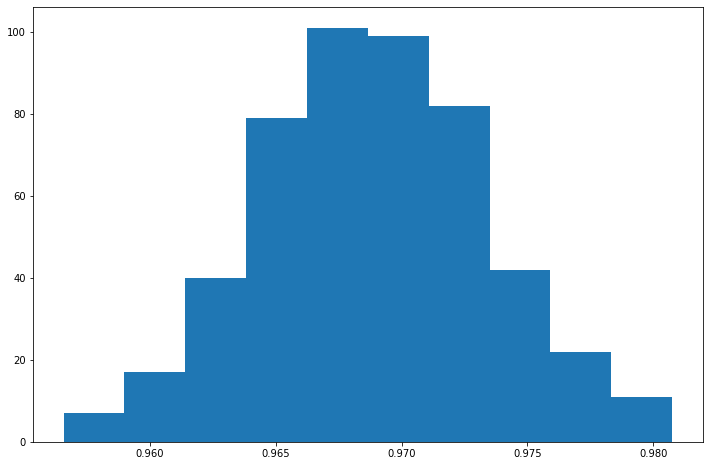

0.25
True entropy is: 0.9434675427121464


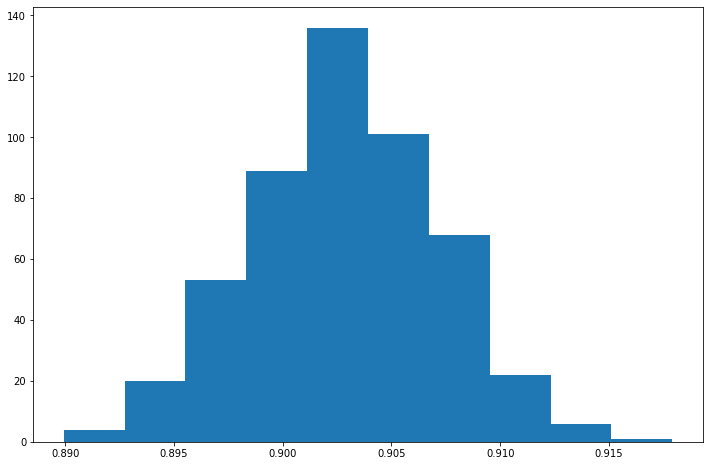

0.2
True entropy is: 0.8499336336026411


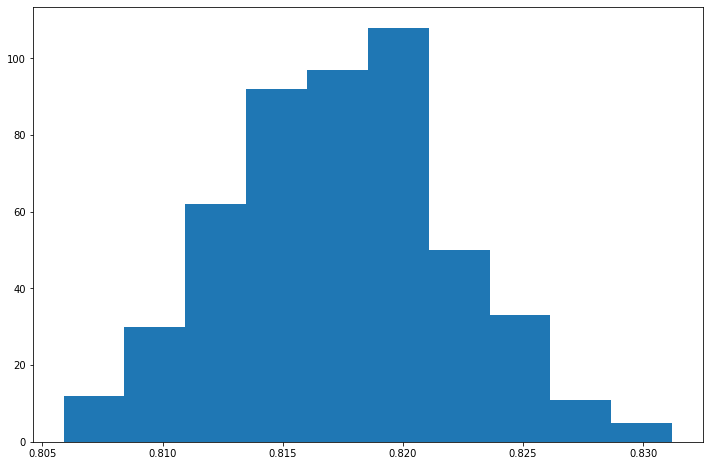

0.15
True entropy is: 0.7419875871809243


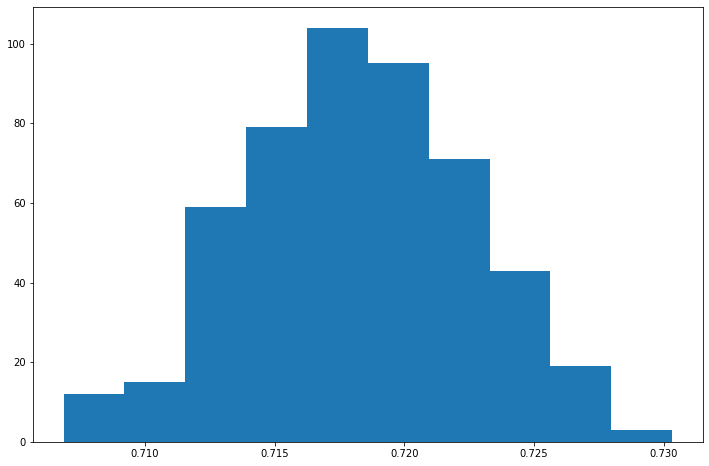

0.1
True entropy is: 0.578651075866613


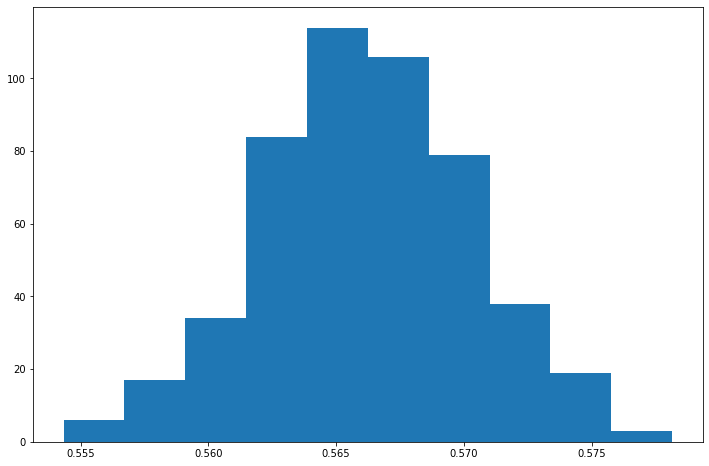

0.05
True entropy is: 0.3852727056552385


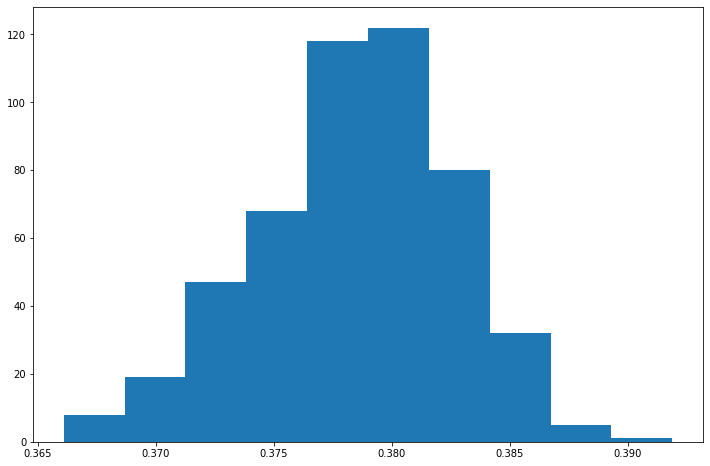

In [34]:
from spatial_coherence import get_spatial_entropy_distribution

for m in m_to_run:
    print(m)
    distribution = get_spatial_entropy_distribution(sliceA, sliceB, m_to_pi_real0010_07[m])
    plt.figure(figsize=(12, 8))
    plt.hist(distribution)
    plt.show()

whole slice spatial coherence score


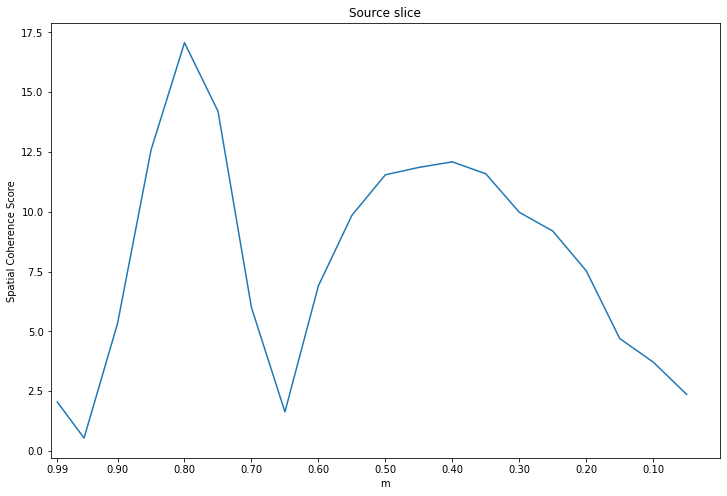

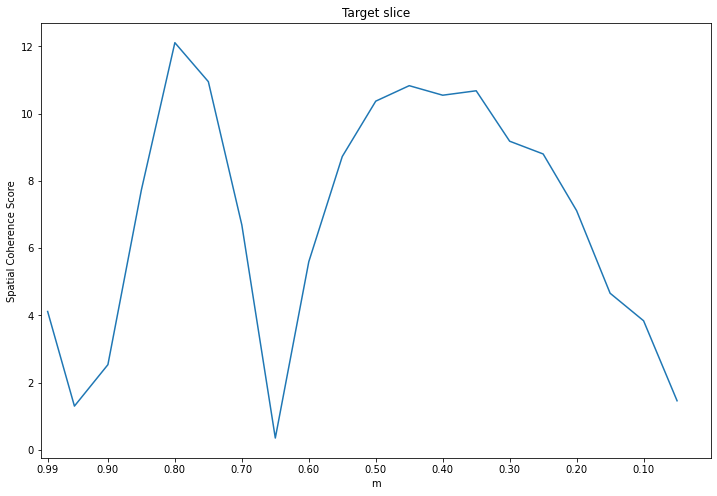

In [59]:
print("whole slice spatial coherence score")
sliceA_scores = []
sliceB_scores = []
for m in m_to_run:
    pi = m_to_pi_real0010_07[m]
    sliceA_score, sliceB_score = calculate_spatial_coherence_for_alignment(sliceA, sliceB, pi)
    sliceA_scores.append(sliceA_score)
    sliceB_scores.append(sliceB_score)
    
plot_score_curve(m_to_run, sliceA_scores, sliceB_scores)

whole slice spatial coherence score


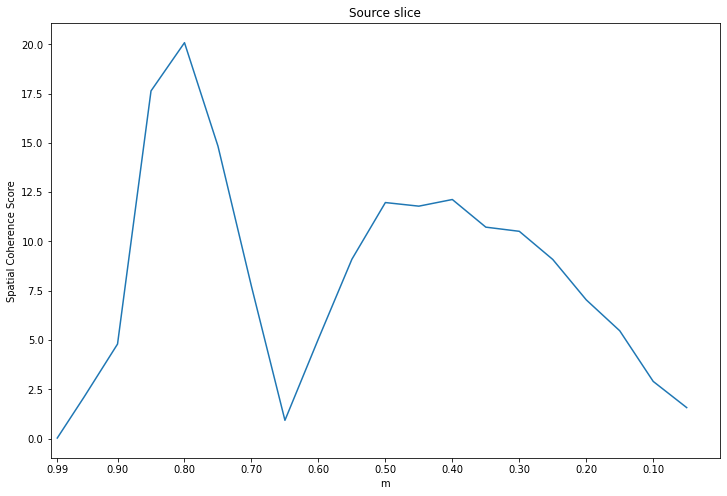

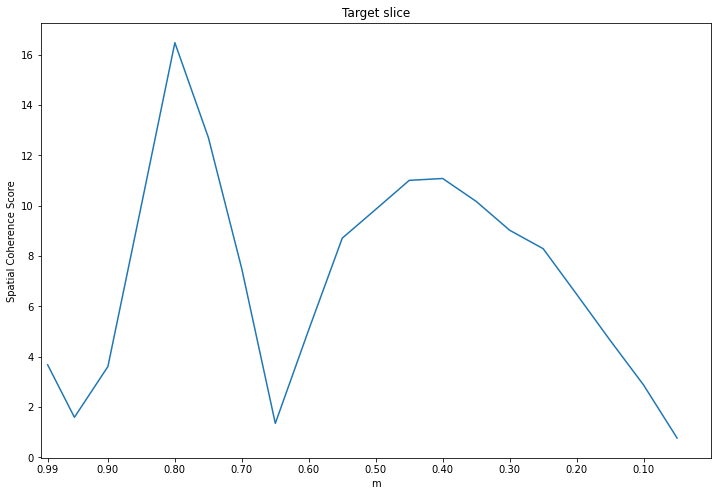

In [22]:
# 200
print("whole slice spatial coherence score")
sliceA_scores = []
sliceB_scores = []
for m in m_to_run:
    pi = m_to_pi_real0010_07[m]
    sliceA_score, sliceB_score = calculate_spatial_coherence_for_alignment(sliceA, sliceB, pi)
    sliceA_scores.append(sliceA_score)
    sliceB_scores.append(sliceB_score)
    
plot_score_curve(m_to_run, sliceA_scores, sliceB_scores)

convex hull unaligned percentage


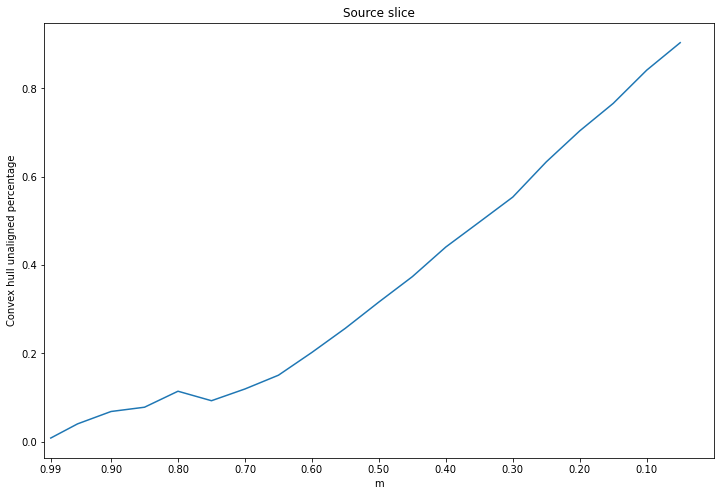

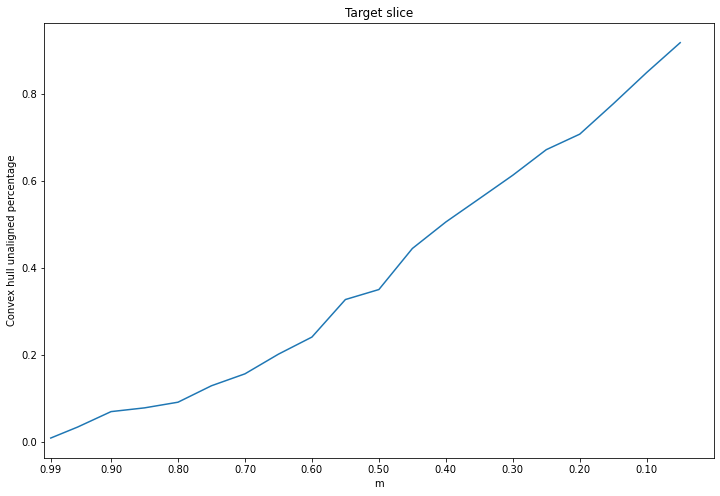

In [21]:
print("convex hull unaligned percentage")
sliceA_percentages = []
sliceB_percentages = []
for m in m_to_run:
    pi = m_to_pi_real0010_07[m]
    sliceA_percentage, sliceB_percentage = calculate_convex_hull_unaligned_percentage(sliceA, sliceB, pi)
    sliceA_percentages.append(sliceA_percentage)
    sliceB_percentages.append(sliceB_percentage)
    
plot_percentage_curve(m_to_run, sliceA_percentages, sliceB_percentages)

whole slice nonconsistent edge measure


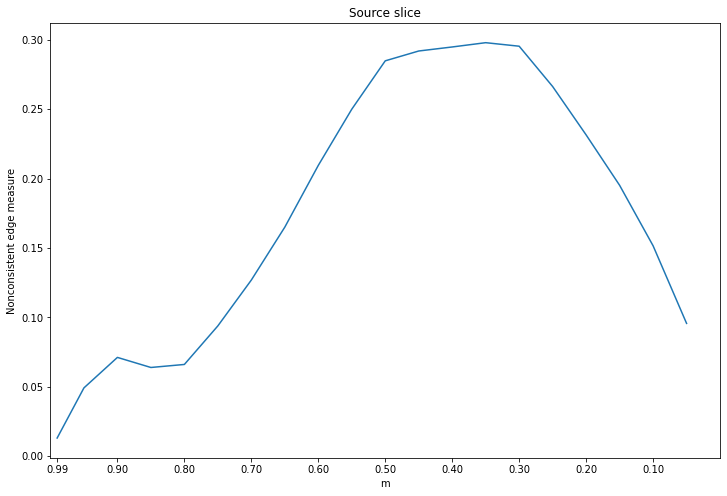

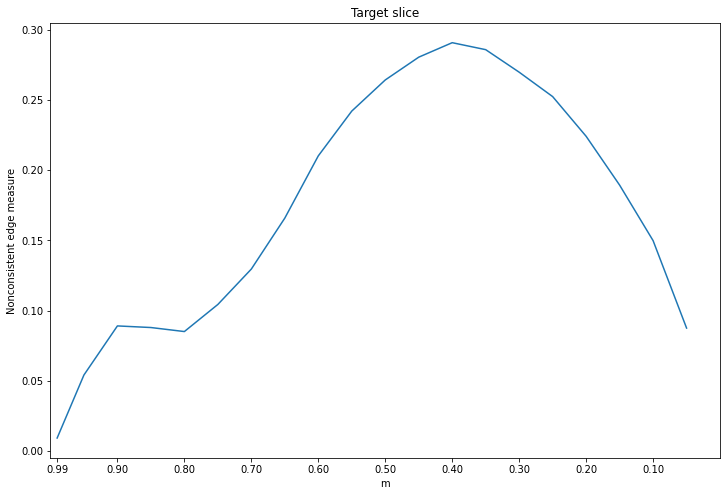

In [44]:
print("whole slice nonconsistent edge measure")
sliceA_measures = []
sliceB_measures = []
for m in m_to_run:
    pi = m_to_pi_real0010_07[m]
    sliceA_measure, sliceB_measure = calculate_nonconsistent_edge_measure_for_alignment(sliceA, sliceB, pi)
    sliceA_measures.append(sliceA_measure)
    sliceB_measures.append(sliceB_measure)
    
plot_edge_curve(m_to_run, sliceA_measures, sliceB_measures)

whole slice nonconsistent edge score


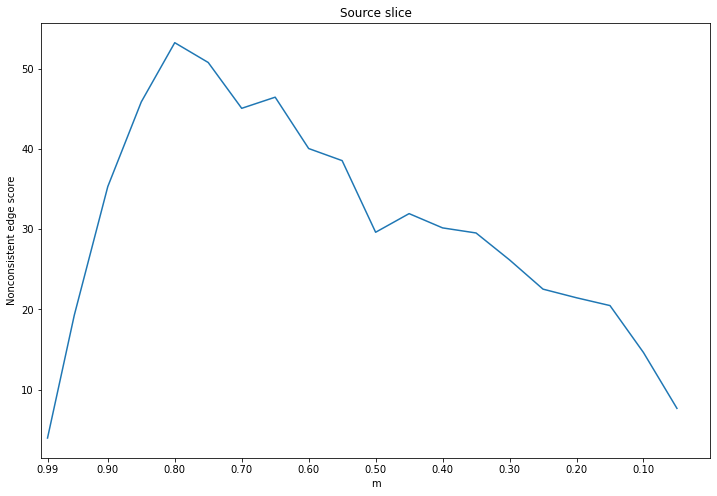

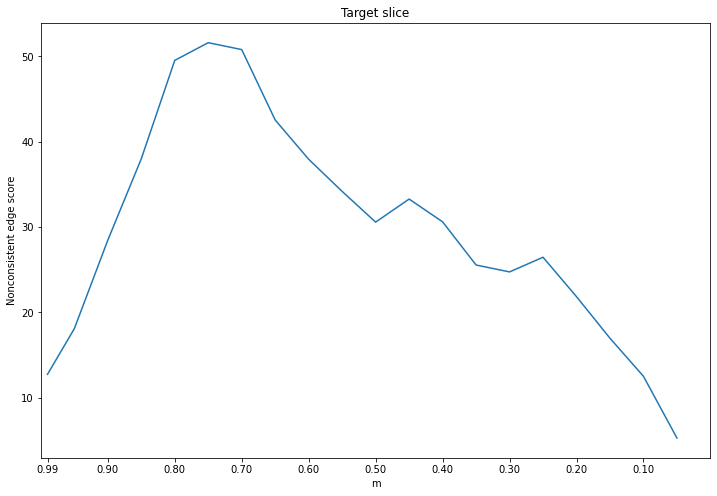

In [59]:
print("whole slice nonconsistent edge score")
sliceA_scores = []
sliceB_scores = []
for m in m_to_run:
    pi = m_to_pi_real0010_07[m]
    sliceA_score, sliceB_score = calculate_nonconsistent_edge_score_for_alignment(sliceA, sliceB, pi)
    sliceA_scores.append(sliceA_score)
    sliceB_scores.append(sliceB_score)
    
plot_edge_score_curve(m_to_run, sliceA_scores, sliceB_scores)

convex hull nonconsistent edge measure


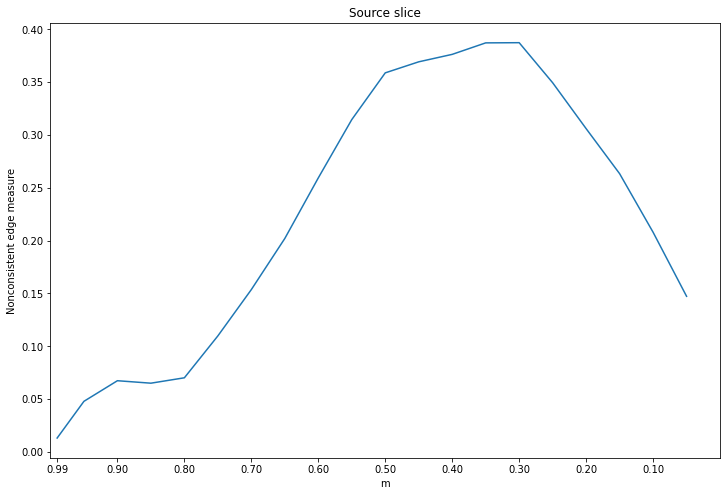

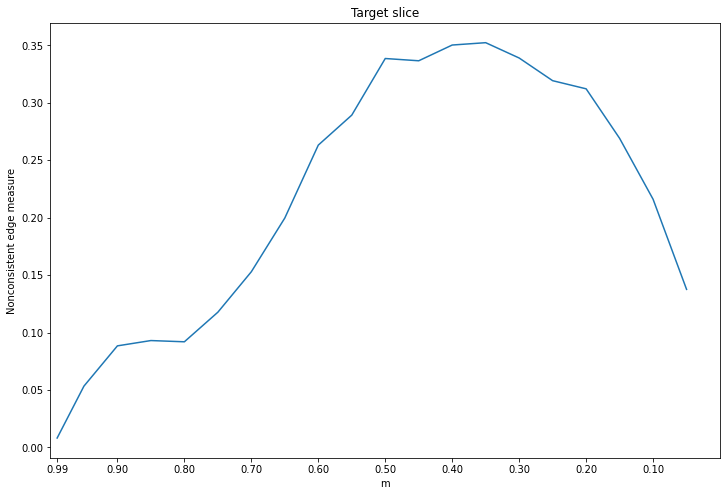

In [70]:
print("convex hull nonconsistent edge measure")
sliceA_measures = []
sliceB_measures = []
for m in m_to_run:
    pi = m_to_pi_real0010_07[m]
    sliceA_measure, sliceB_measure = calculate_convex_hull_noncosistent_edge_measure(sliceA, sliceB, pi)
    sliceA_measures.append(sliceA_measure)
    sliceB_measures.append(sliceB_measure)
    
plot_edge_curve(m_to_run, sliceA_measures, sliceB_measures)

In [ ]:
***
151673_00 - 151674_10
m=0.9
***

In [60]:
sliceA_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/151673/151673_overlap0.9_dropFalse_rotateFalse_resampleFalse_delta0.0_row0_col0.h5ad'
sliceB_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/151674/151674_overlap0.9_dropFalse_rotateFalse_resampleFalse_delta0.0_row1_col0.h5ad'
sliceA = sc.read_h5ad(sliceA_filename)
sliceB = sc.read_h5ad(sliceB_filename)
common_genes = intersect(sliceA.var.index, sliceB.var.index)
sliceA = sliceA[:, common_genes]
sliceB = sliceB[:, common_genes]

In [48]:
# Get transport cost matrix
A_X, B_X = to_dense_array(extract_data_matrix(sliceA, None)), to_dense_array(extract_data_matrix(sliceB, None))
M = glmpca_distance(A_X, B_X, latent_dim=50, filter=True)

Starting GLM-PCA...
Iteration: 0 | deviance=1.5920E+7
Iteration: 1 | deviance=1.5917E+7
Iteration: 2 | deviance=1.3879E+7
Iteration: 3 | deviance=1.3496E+7
Iteration: 4 | deviance=1.3337E+7
Iteration: 5 | deviance=1.3256E+7
Iteration: 6 | deviance=1.3209E+7
Iteration: 7 | deviance=1.3180E+7
Iteration: 8 | deviance=1.3160E+7
Iteration: 9 | deviance=1.3145E+7
Iteration: 10 | deviance=1.3134E+7
Iteration: 11 | deviance=1.3125E+7
Iteration: 12 | deviance=1.3118E+7
Iteration: 13 | deviance=1.3112E+7
Iteration: 14 | deviance=1.3107E+7
Iteration: 15 | deviance=1.3103E+7
Iteration: 16 | deviance=1.3099E+7
Iteration: 17 | deviance=1.3096E+7
Iteration: 18 | deviance=1.3093E+7
Iteration: 19 | deviance=1.3091E+7
Iteration: 20 | deviance=1.3088E+7
Iteration: 21 | deviance=1.3086E+7
Iteration: 22 | deviance=1.3084E+7
Iteration: 23 | deviance=1.3083E+7
Iteration: 24 | deviance=1.3081E+7
Iteration: 25 | deviance=1.3080E+7
GLM-PCA finished with joint matrix shape (6516, 50)


In [49]:
m_to_pi_real0010_09 = {}
for m in m_to_run:
    pi, log = partial_pairwise_align_given_cost_matrix(sliceA, sliceB, M=M, alpha=0.1, m=m, armijo=False,
                                                       norm=True, return_obj=True, verbose=False)
    m_to_pi_real0010_09[m] = pi

whole slice spatial coherence score


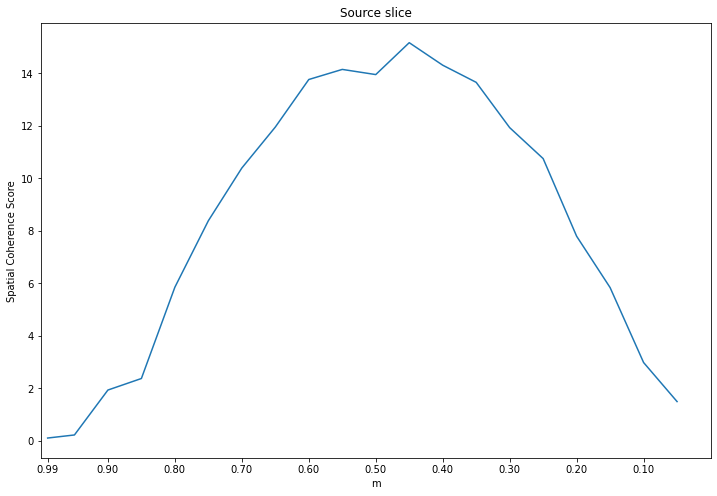

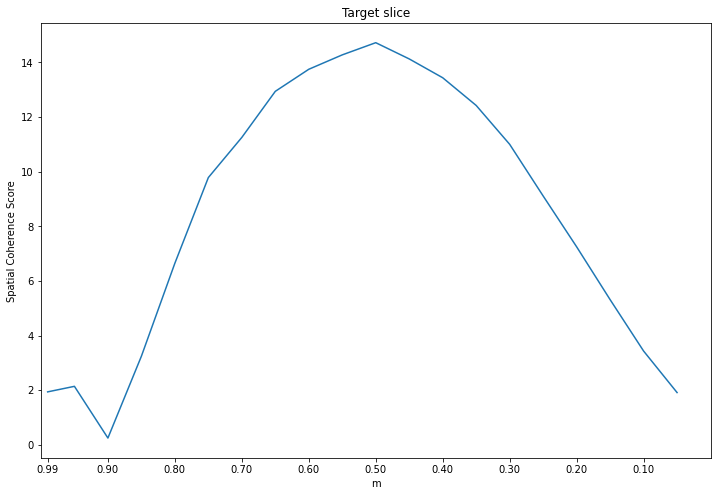

In [61]:
print("whole slice spatial coherence score")
sliceA_scores = []
sliceB_scores = []
for m in m_to_run:
    pi = m_to_pi_real0010_09[m]
    sliceA_score, sliceB_score = calculate_spatial_coherence_for_alignment(sliceA, sliceB, pi)
    sliceA_scores.append(sliceA_score)
    sliceB_scores.append(sliceB_score)
    
plot_score_curve(m_to_run, sliceA_scores, sliceB_scores)

convex hull nonconsistent edge measure


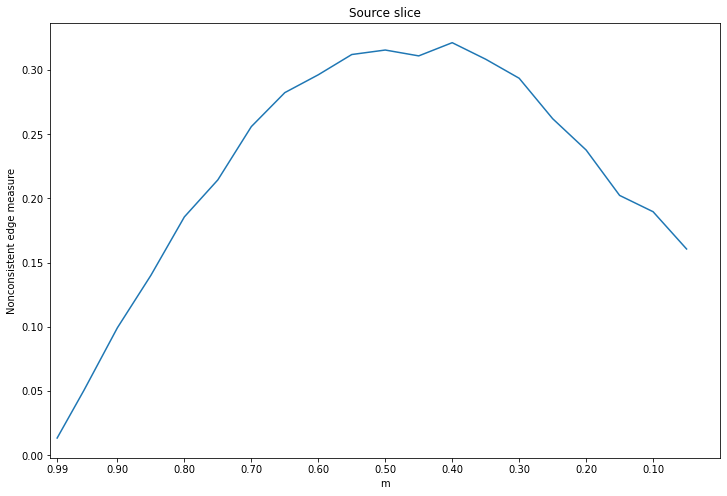

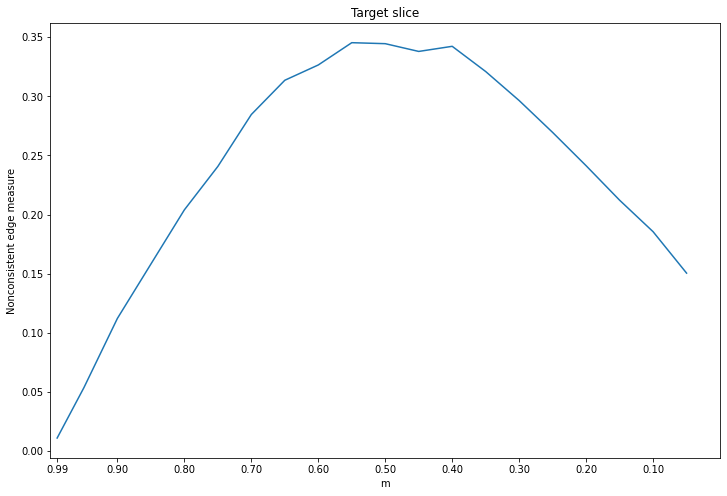

In [74]:
print("convex hull nonconsistent edge measure")
sliceA_measures = []
sliceB_measures = []
for m in m_to_run:
    pi = m_to_pi_real0010_09[m]
    sliceA_measure, sliceB_measure = calculate_convex_hull_noncosistent_edge_measure(sliceA, sliceB, pi)
    sliceA_measures.append(sliceA_measure)
    sliceB_measures.append(sliceB_measure)
    
plot_edge_curve(m_to_run, sliceA_measures, sliceB_measures)

In [ ]:
***
151673_00 - 151674_10
m=0.3
***

In [62]:
sliceA_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/151673/151673_overlap0.3_dropFalse_rotateFalse_resampleFalse_delta0.0_row0_col0.h5ad'
sliceB_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/151674/151674_overlap0.3_dropFalse_rotateFalse_resampleFalse_delta0.0_row1_col0.h5ad'
sliceA = sc.read_h5ad(sliceA_filename)
sliceB = sc.read_h5ad(sliceB_filename)
common_genes = intersect(sliceA.var.index, sliceB.var.index)
sliceA = sliceA[:, common_genes]
sliceB = sliceB[:, common_genes]

In [42]:
# Get transport cost matrix
A_X, B_X = to_dense_array(extract_data_matrix(sliceA, None)), to_dense_array(extract_data_matrix(sliceB, None))
M = glmpca_distance(A_X, B_X, latent_dim=50, filter=True)

Starting GLM-PCA...
Iteration: 0 | deviance=6.1313E+6
Iteration: 1 | deviance=6.1311E+6
Iteration: 2 | deviance=5.3503E+6
Iteration: 3 | deviance=5.1523E+6
Iteration: 4 | deviance=5.0675E+6
Iteration: 5 | deviance=5.0276E+6
Iteration: 6 | deviance=5.0044E+6
Iteration: 7 | deviance=4.9888E+6
Iteration: 8 | deviance=4.9775E+6
Iteration: 9 | deviance=4.9692E+6
Iteration: 10 | deviance=4.9627E+6
Iteration: 11 | deviance=4.9576E+6
Iteration: 12 | deviance=4.9534E+6
Iteration: 13 | deviance=4.9499E+6
Iteration: 14 | deviance=4.9470E+6
Iteration: 15 | deviance=4.9444E+6
Iteration: 16 | deviance=4.9422E+6
Iteration: 17 | deviance=4.9403E+6
Iteration: 18 | deviance=4.9387E+6
Iteration: 19 | deviance=4.9372E+6
Iteration: 20 | deviance=4.9358E+6
Iteration: 21 | deviance=4.9346E+6
Iteration: 22 | deviance=4.9336E+6
Iteration: 23 | deviance=4.9326E+6
Iteration: 24 | deviance=4.9317E+6
Iteration: 25 | deviance=4.9309E+6
Iteration: 26 | deviance=4.9301E+6
Iteration: 27 | deviance=4.9294E+6
Iteration:

In [43]:
m_to_pi_real0010_03 = {}
for m in m_to_run:
    pi, log = partial_pairwise_align_given_cost_matrix(sliceA, sliceB, M=M, alpha=0.1, m=m, armijo=False,
                                                       norm=True, return_obj=True, verbose=False)
    m_to_pi_real0010_03[m] = pi

whole slice spatial coherence score


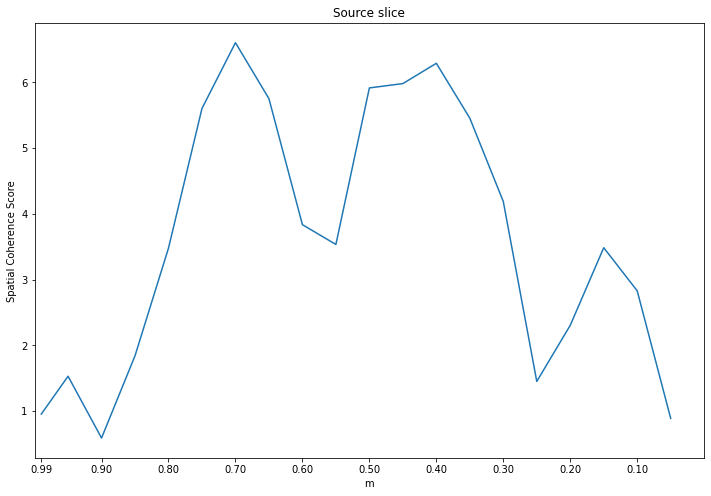

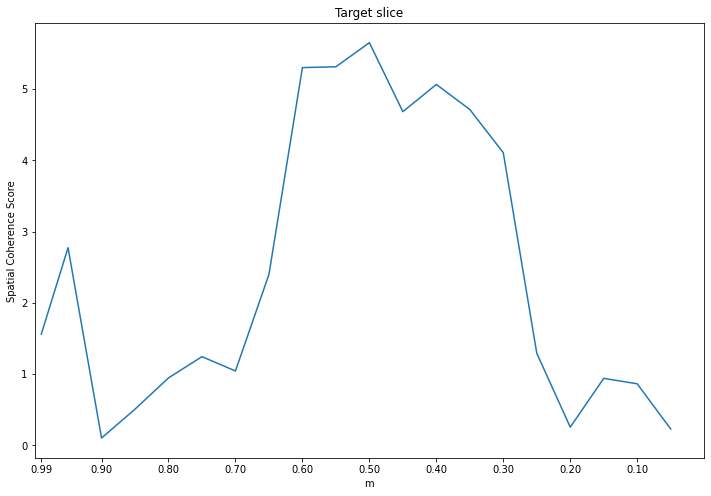

In [63]:
print("whole slice spatial coherence score")
sliceA_scores = []
sliceB_scores = []
for m in m_to_run:
    pi = m_to_pi_real0010_03[m]
    sliceA_score, sliceB_score = calculate_spatial_coherence_for_alignment(sliceA, sliceB, pi)
    sliceA_scores.append(sliceA_score)
    sliceB_scores.append(sliceB_score)
    
plot_score_curve(m_to_run, sliceA_scores, sliceB_scores)

whole slice nonconsistent edge measure


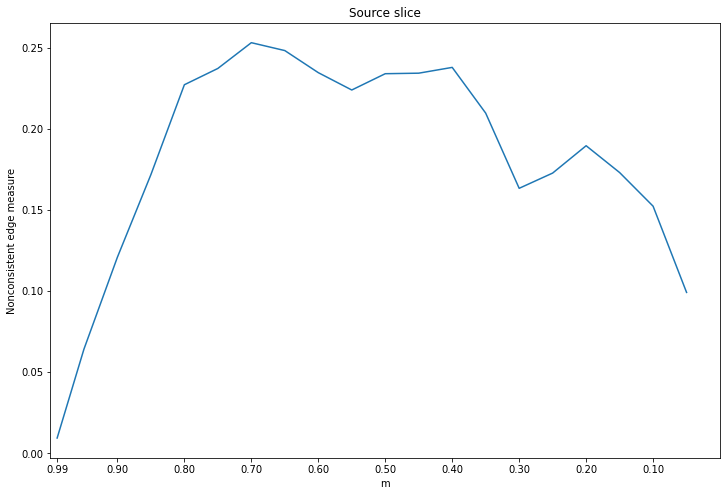

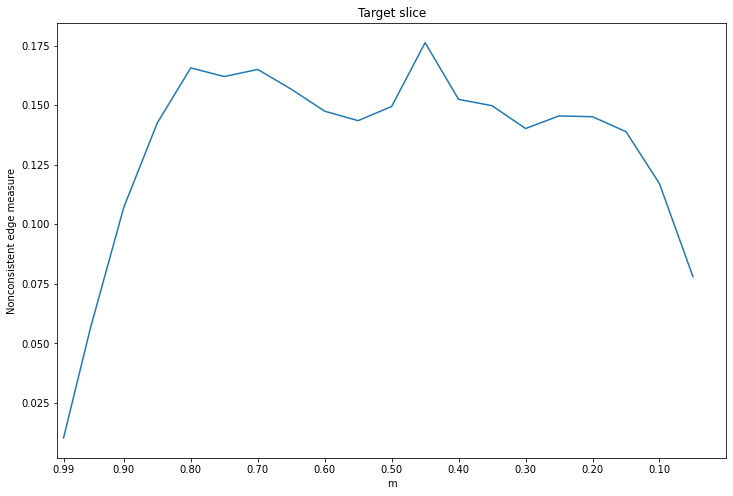

In [55]:
print("whole slice nonconsistent edge measure")
sliceA_measures = []
sliceB_measures = []
for m in m_to_run:
    pi = m_to_pi_real0010_03[m]
    sliceA_measure, sliceB_measure = calculate_nonconsistent_edge_measure_for_alignment(sliceA, sliceB, pi)
    sliceA_measures.append(sliceA_measure)
    sliceB_measures.append(sliceB_measure)
    
plot_edge_curve(m_to_run, sliceA_measures, sliceB_measures)

convex hull nonconsistent edge measure


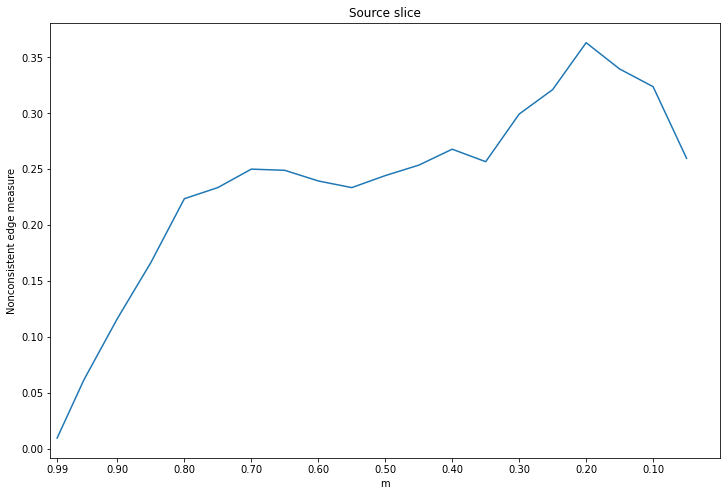

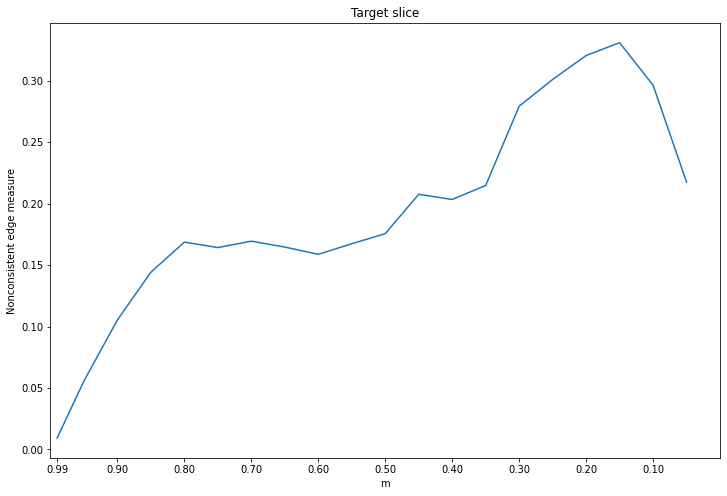

In [72]:
print("convex hull nonconsistent edge measure")
sliceA_measures = []
sliceB_measures = []
for m in m_to_run:
    pi = m_to_pi_real0010_03[m]
    sliceA_measure, sliceB_measure = calculate_convex_hull_noncosistent_edge_measure(sliceA, sliceB, pi)
    sliceA_measures.append(sliceA_measure)
    sliceB_measures.append(sliceB_measure)
    
plot_edge_curve(m_to_run, sliceA_measures, sliceB_measures)

In [ ]:
***
151673_00 - 151674_01
m=0.3
***

In [85]:
sliceA_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/151673/151673_overlap0.3_dropFalse_rotateFalse_resampleFalse_delta0.0_row0_col0.h5ad'
sliceB_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/151674/151674_overlap0.3_dropFalse_rotateFalse_resampleFalse_delta0.0_row0_col1.h5ad'
sliceA = sc.read_h5ad(sliceA_filename)
sliceB = sc.read_h5ad(sliceB_filename)
common_genes = intersect(sliceA.var.index, sliceB.var.index)
sliceA = sliceA[:, common_genes]
sliceB = sliceB[:, common_genes]

In [86]:
# Get transport cost matrix
A_X, B_X = to_dense_array(extract_data_matrix(sliceA, None)), to_dense_array(extract_data_matrix(sliceB, None))
M = glmpca_distance(A_X, B_X, latent_dim=50, filter=True)

Starting GLM-PCA...
Iteration: 0 | deviance=5.9347E+6
Iteration: 1 | deviance=5.9345E+6
Iteration: 2 | deviance=5.5677E+6
Iteration: 3 | deviance=5.3869E+6
Iteration: 4 | deviance=5.3027E+6
Iteration: 5 | deviance=5.2616E+6
Iteration: 6 | deviance=5.2390E+6
Iteration: 7 | deviance=5.2240E+6
Iteration: 8 | deviance=5.2131E+6
Iteration: 9 | deviance=5.2049E+6
Iteration: 10 | deviance=5.1983E+6
Iteration: 11 | deviance=5.1929E+6
Iteration: 12 | deviance=5.1884E+6
Iteration: 13 | deviance=5.1846E+6
Iteration: 14 | deviance=5.1813E+6
Iteration: 15 | deviance=5.1785E+6
Iteration: 16 | deviance=5.1760E+6
Iteration: 17 | deviance=5.1738E+6
Iteration: 18 | deviance=5.1719E+6
Iteration: 19 | deviance=5.1702E+6
Iteration: 20 | deviance=5.1686E+6
Iteration: 21 | deviance=5.1672E+6
Iteration: 22 | deviance=5.1660E+6
Iteration: 23 | deviance=5.1648E+6
Iteration: 24 | deviance=5.1638E+6
Iteration: 25 | deviance=5.1628E+6
Iteration: 26 | deviance=5.1620E+6
Iteration: 27 | deviance=5.1612E+6
Iteration:

In [87]:
m_to_pi_real0001_03 = {}
for m in m_to_run:
    pi, log = partial_pairwise_align_given_cost_matrix(sliceA, sliceB, M=M, alpha=0.1, m=m, armijo=False,
                                                       norm=True, return_obj=True, verbose=False)
    m_to_pi_real0001_03[m] = pi

convex hull nonconsistent edge measure


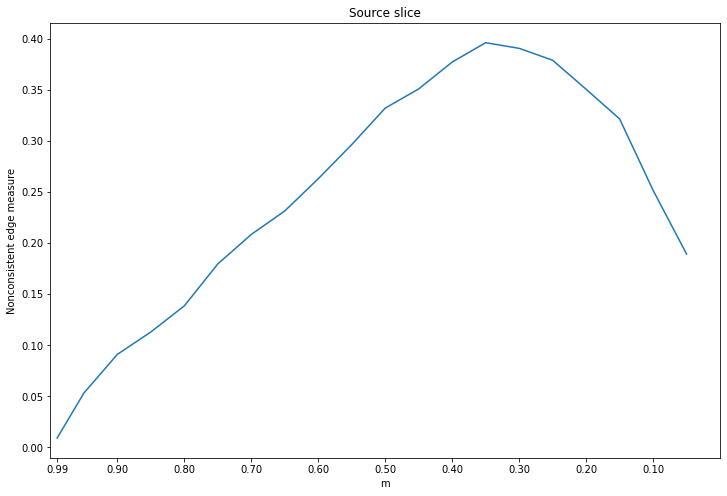

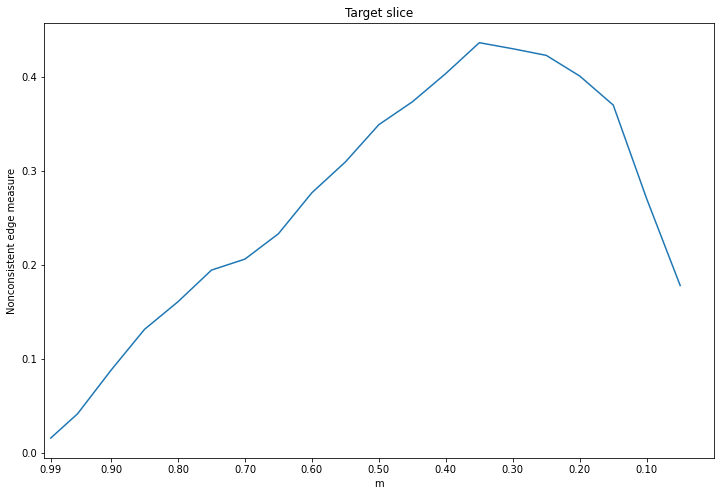

In [88]:
print("convex hull nonconsistent edge measure")
sliceA_measures = []
sliceB_measures = []
for m in m_to_run:
    pi = m_to_pi_real0001_03[m]
    sliceA_measure, sliceB_measure = calculate_convex_hull_noncosistent_edge_measure(sliceA, sliceB, pi)
    sliceA_measures.append(sliceA_measure)
    sliceB_measures.append(sliceB_measure)
    
plot_edge_curve(m_to_run, sliceA_measures, sliceB_measures)

In [ ]:
***
151673_00 - 151674_01
m=0.5
***

In [96]:
sliceA_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/151673/151673_overlap0.5_dropFalse_rotateFalse_resampleFalse_delta0.0_row0_col0.h5ad'
sliceB_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/151674/151674_overlap0.5_dropFalse_rotateFalse_resampleFalse_delta0.0_row0_col1.h5ad'
sliceA = sc.read_h5ad(sliceA_filename)
sliceB = sc.read_h5ad(sliceB_filename)
common_genes = intersect(sliceA.var.index, sliceB.var.index)
sliceA = sliceA[:, common_genes]
sliceB = sliceB[:, common_genes]

In [90]:
# Get transport cost matrix
A_X, B_X = to_dense_array(extract_data_matrix(sliceA, None)), to_dense_array(extract_data_matrix(sliceB, None))
M = glmpca_distance(A_X, B_X, latent_dim=50, filter=True)

Starting GLM-PCA...
Iteration: 0 | deviance=7.9526E+6
Iteration: 1 | deviance=7.9522E+6
Iteration: 2 | deviance=7.4041E+6
Iteration: 3 | deviance=7.1752E+6
Iteration: 4 | deviance=7.0662E+6
Iteration: 5 | deviance=7.0074E+6
Iteration: 6 | deviance=6.9746E+6
Iteration: 7 | deviance=6.9537E+6
Iteration: 8 | deviance=6.9392E+6
Iteration: 9 | deviance=6.9284E+6
Iteration: 10 | deviance=6.9200E+6
Iteration: 11 | deviance=6.9133E+6
Iteration: 12 | deviance=6.9077E+6
Iteration: 13 | deviance=6.9031E+6
Iteration: 14 | deviance=6.8993E+6
Iteration: 15 | deviance=6.8961E+6
Iteration: 16 | deviance=6.8933E+6
Iteration: 17 | deviance=6.8909E+6
Iteration: 18 | deviance=6.8888E+6
Iteration: 19 | deviance=6.8870E+6
Iteration: 20 | deviance=6.8853E+6
Iteration: 21 | deviance=6.8839E+6
Iteration: 22 | deviance=6.8826E+6
Iteration: 23 | deviance=6.8814E+6
Iteration: 24 | deviance=6.8803E+6
Iteration: 25 | deviance=6.8793E+6
Iteration: 26 | deviance=6.8784E+6
Iteration: 27 | deviance=6.8776E+6
Iteration:

In [91]:
m_to_pi_real0001_05 = {}
for m in m_to_run:
    pi, log = partial_pairwise_align_given_cost_matrix(sliceA, sliceB, M=M, alpha=0.1, m=m, armijo=False,
                                                       norm=True, return_obj=True, verbose=False)
    m_to_pi_real0001_05[m] = pi

convex hull nonconsistent edge measure


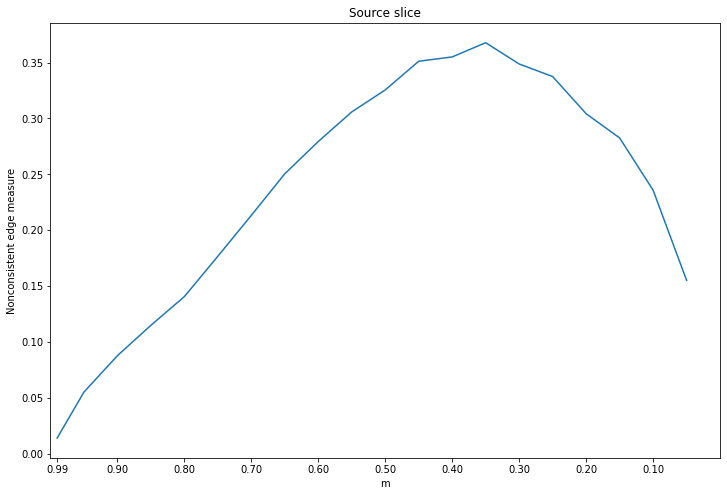

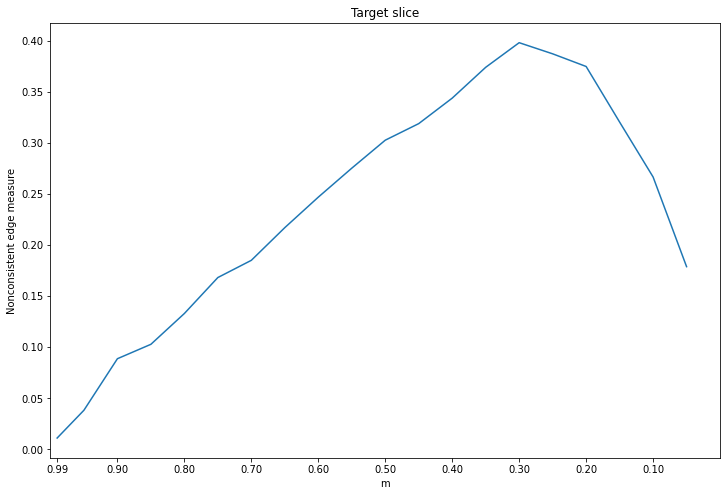

In [97]:
print("convex hull nonconsistent edge measure")
sliceA_measures = []
sliceB_measures = []
for m in m_to_run:
    pi = m_to_pi_real0001_05[m]
    sliceA_measure, sliceB_measure = calculate_convex_hull_noncosistent_edge_measure(sliceA, sliceB, pi)
    sliceA_measures.append(sliceA_measure)
    sliceB_measures.append(sliceB_measure)
    
plot_edge_curve(m_to_run, sliceA_measures, sliceB_measures)

In [ ]:
***
151673_00 - 151674_01
m=0.7
***

In [92]:
sliceA_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/151673/151673_overlap0.7_dropFalse_rotateFalse_resampleFalse_delta0.0_row0_col0.h5ad'
sliceB_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/151674/151674_overlap0.7_dropFalse_rotateFalse_resampleFalse_delta0.0_row0_col1.h5ad'
sliceA = sc.read_h5ad(sliceA_filename)
sliceB = sc.read_h5ad(sliceB_filename)
common_genes = intersect(sliceA.var.index, sliceB.var.index)
sliceA = sliceA[:, common_genes]
sliceB = sliceB[:, common_genes]

In [93]:
# Get transport cost matrix
A_X, B_X = to_dense_array(extract_data_matrix(sliceA, None)), to_dense_array(extract_data_matrix(sliceB, None))
M = glmpca_distance(A_X, B_X, latent_dim=50, filter=True)

Starting GLM-PCA...
Iteration: 0 | deviance=1.1158E+7
Iteration: 1 | deviance=1.1157E+7
Iteration: 2 | deviance=1.0092E+7
Iteration: 3 | deviance=9.8123E+6
Iteration: 4 | deviance=9.6818E+6
Iteration: 5 | deviance=9.6181E+6
Iteration: 6 | deviance=9.5839E+6
Iteration: 7 | deviance=9.5628E+6
Iteration: 8 | deviance=9.5482E+6
Iteration: 9 | deviance=9.5373E+6
Iteration: 10 | deviance=9.5289E+6
Iteration: 11 | deviance=9.5221E+6
Iteration: 12 | deviance=9.5165E+6
Iteration: 13 | deviance=9.5118E+6
Iteration: 14 | deviance=9.5078E+6
Iteration: 15 | deviance=9.5044E+6
Iteration: 16 | deviance=9.5015E+6
Iteration: 17 | deviance=9.4989E+6
Iteration: 18 | deviance=9.4966E+6
Iteration: 19 | deviance=9.4946E+6
Iteration: 20 | deviance=9.4928E+6
Iteration: 21 | deviance=9.4912E+6
Iteration: 22 | deviance=9.4897E+6
Iteration: 23 | deviance=9.4883E+6
Iteration: 24 | deviance=9.4871E+6
Iteration: 25 | deviance=9.4860E+6
Iteration: 26 | deviance=9.4849E+6
Iteration: 27 | deviance=9.4840E+6
GLM-PCA fi

In [94]:
m_to_pi_real0001_07 = {}
for m in m_to_run:
    pi, log = partial_pairwise_align_given_cost_matrix(sliceA, sliceB, M=M, alpha=0.1, m=m, armijo=False,
                                                       norm=True, return_obj=True, verbose=False)
    m_to_pi_real0001_07[m] = pi

convex hull nonconsistent edge measure


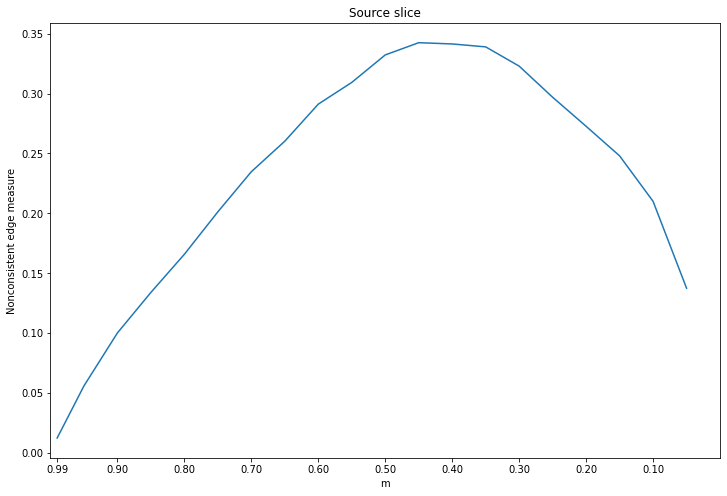

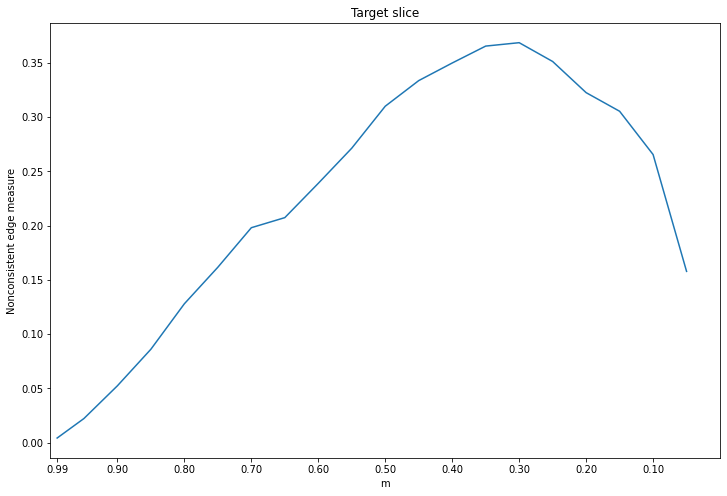

In [95]:
print("convex hull nonconsistent edge measure")
sliceA_measures = []
sliceB_measures = []
for m in m_to_run:
    pi = m_to_pi_real0001_07[m]
    sliceA_measure, sliceB_measure = calculate_convex_hull_noncosistent_edge_measure(sliceA, sliceB, pi)
    sliceA_measures.append(sliceA_measure)
    sliceB_measures.append(sliceB_measure)
    
plot_edge_curve(m_to_run, sliceA_measures, sliceB_measures)

In [ ]:
***
151673_00 - 151674_01
m=0.9
***

In [24]:
sliceA_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/151673/151673_overlap0.9_dropFalse_rotateFalse_resampleFalse_delta0.0_row0_col0.h5ad'
sliceB_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/151674/151674_overlap0.9_dropFalse_rotateFalse_resampleFalse_delta0.0_row0_col1.h5ad'
sliceA = sc.read_h5ad(sliceA_filename)
sliceB = sc.read_h5ad(sliceB_filename)
common_genes = intersect(sliceA.var.index, sliceB.var.index)
sliceA = sliceA[:, common_genes]
sliceB = sliceB[:, common_genes]

In [16]:
# Get transport cost matrix
A_X, B_X = to_dense_array(extract_data_matrix(sliceA, None)), to_dense_array(extract_data_matrix(sliceB, None))
M = glmpca_distance(A_X, B_X, latent_dim=50, filter=True)

Starting GLM-PCA...
Iteration: 0 | deviance=1.6159E+7
Iteration: 1 | deviance=1.6157E+7
Iteration: 2 | deviance=1.4256E+7
Iteration: 3 | deviance=1.3865E+7
Iteration: 4 | deviance=1.3695E+7
Iteration: 5 | deviance=1.3608E+7
Iteration: 6 | deviance=1.3560E+7
Iteration: 7 | deviance=1.3528E+7
Iteration: 8 | deviance=1.3506E+7
Iteration: 9 | deviance=1.3490E+7
Iteration: 10 | deviance=1.3478E+7
Iteration: 11 | deviance=1.3468E+7
Iteration: 12 | deviance=1.3461E+7
Iteration: 13 | deviance=1.3454E+7
Iteration: 14 | deviance=1.3449E+7
Iteration: 15 | deviance=1.3445E+7
Iteration: 16 | deviance=1.3441E+7
Iteration: 17 | deviance=1.3438E+7
Iteration: 18 | deviance=1.3435E+7
Iteration: 19 | deviance=1.3432E+7
Iteration: 20 | deviance=1.3430E+7
Iteration: 21 | deviance=1.3428E+7
Iteration: 22 | deviance=1.3426E+7
Iteration: 23 | deviance=1.3424E+7
Iteration: 24 | deviance=1.3423E+7
Iteration: 25 | deviance=1.3421E+7
GLM-PCA finished with joint matrix shape (6667, 50)


In [17]:
m_to_pi_real0001_09 = {}
for m in m_to_run:
    pi, log = partial_pairwise_align_given_cost_matrix(sliceA, sliceB, M=M, alpha=0.1, m=m, armijo=False,
                                                       norm=True, return_obj=True, verbose=False)
    m_to_pi_real0001_09[m] = pi

convex hull nonconsistent edge measure


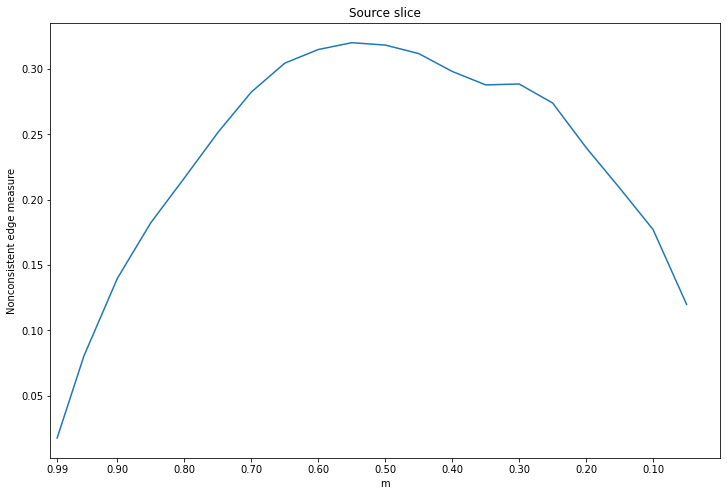

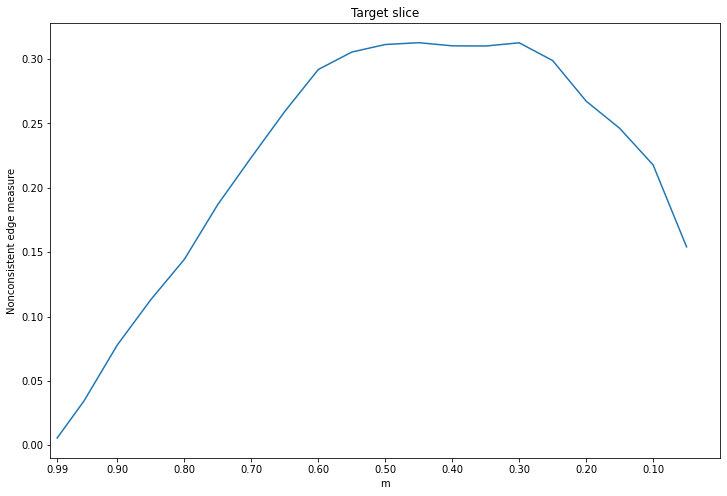

In [25]:
print("convex hull nonconsistent edge measure")
sliceA_measures = []
sliceB_measures = []
for m in m_to_run:
    pi = m_to_pi_real0001_09[m]
    sliceA_measure, sliceB_measure = calculate_convex_hull_noncosistent_edge_measure(sliceA, sliceB, pi)
    sliceA_measures.append(sliceA_measure)
    sliceB_measures.append(sliceB_measure)
    
plot_edge_curve(m_to_run, sliceA_measures, sliceB_measures)

In [ ]:
***
sim00-10
m=0.3
delta=0.1
***

In [64]:
sliceA_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/single_resample/pca/151674_overlap0.3_dropFalse_rotateFalse_resampleTrue_delta0.1_row0_col0.h5ad'
sliceB_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/single_resample/pca/151674_overlap0.3_dropFalse_rotateFalse_resampleTrue_delta0.1_row1_col0.h5ad'
sliceA = sc.read_h5ad(sliceA_filename)
sliceB = sc.read_h5ad(sliceB_filename)
common_genes = intersect(sliceA.var.index, sliceB.var.index)
sliceA = sliceA[:, common_genes]
sliceB = sliceB[:, common_genes]

In [51]:
# Get transport cost matrix
A_X, B_X = to_dense_array(extract_data_matrix(sliceA, None)), to_dense_array(extract_data_matrix(sliceB, None))
M = glmpca_distance(A_X, B_X, latent_dim=50, filter=True)

Starting GLM-PCA...
Iteration: 0 | deviance=7.3866E+6
Iteration: 1 | deviance=7.3865E+6
Iteration: 2 | deviance=6.6723E+6
Iteration: 3 | deviance=6.4193E+6
Iteration: 4 | deviance=6.3032E+6
Iteration: 5 | deviance=6.2414E+6
Iteration: 6 | deviance=6.2045E+6
Iteration: 7 | deviance=6.1802E+6
Iteration: 8 | deviance=6.1628E+6
Iteration: 9 | deviance=6.1497E+6
Iteration: 10 | deviance=6.1396E+6
Iteration: 11 | deviance=6.1315E+6
Iteration: 12 | deviance=6.1250E+6
Iteration: 13 | deviance=6.1197E+6
Iteration: 14 | deviance=6.1152E+6
Iteration: 15 | deviance=6.1114E+6
Iteration: 16 | deviance=6.1082E+6
Iteration: 17 | deviance=6.1054E+6
Iteration: 18 | deviance=6.1029E+6
Iteration: 19 | deviance=6.1008E+6
Iteration: 20 | deviance=6.0988E+6
Iteration: 21 | deviance=6.0971E+6
Iteration: 22 | deviance=6.0956E+6
Iteration: 23 | deviance=6.0942E+6
Iteration: 24 | deviance=6.0929E+6
Iteration: 25 | deviance=6.0917E+6
Iteration: 26 | deviance=6.0906E+6
Iteration: 27 | deviance=6.0896E+6
Iteration:

In [52]:
m_to_pi_sim03_01 = {}
for m in m_to_run:
    pi, log = partial_pairwise_align_given_cost_matrix(sliceA, sliceB, M=M, alpha=0.1, m=m, armijo=False,
                                                       norm=True, return_obj=True, verbose=False)
    m_to_pi_sim03_01[m] = pi

whole slice spatial coherence score


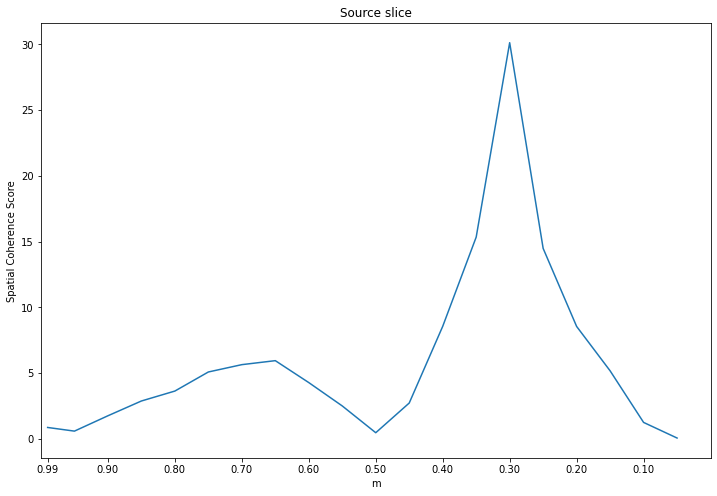

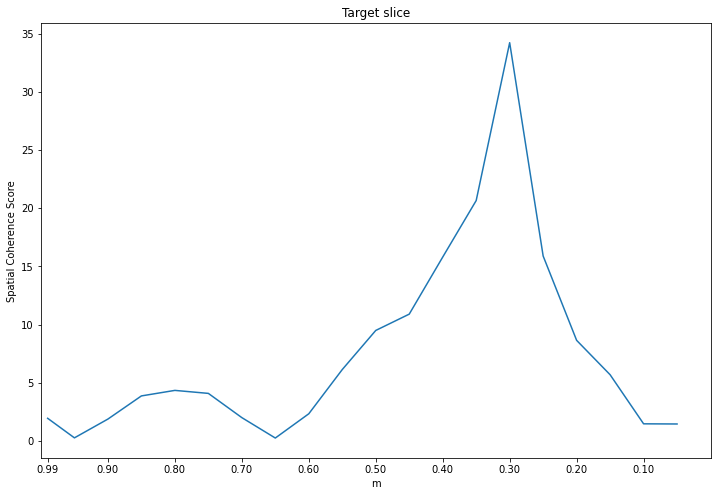

In [65]:
print("whole slice spatial coherence score")
sliceA_scores = []
sliceB_scores = []
for m in m_to_run:
    pi = m_to_pi_sim03_01[m]
    sliceA_score, sliceB_score = calculate_spatial_coherence_for_alignment(sliceA, sliceB, pi)
    sliceA_scores.append(sliceA_score)
    sliceB_scores.append(sliceB_score)
    
plot_score_curve(m_to_run, sliceA_scores, sliceB_scores)

convex hull nonconsistent edge measure


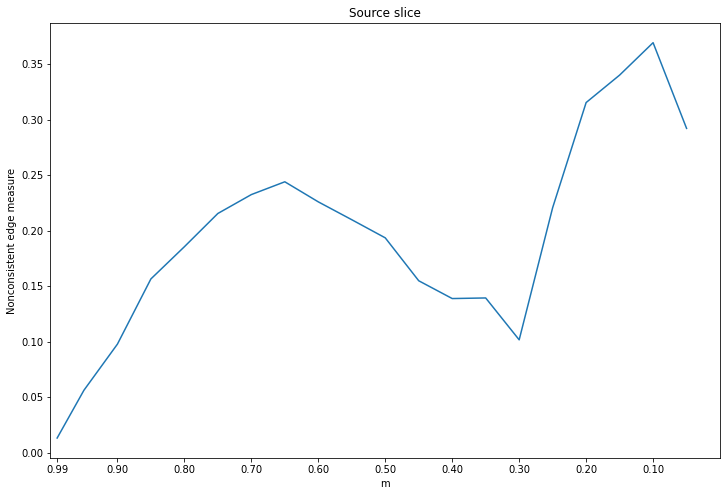

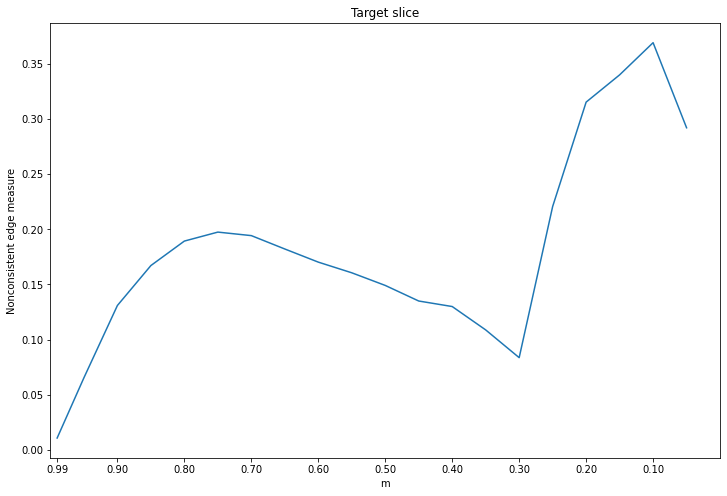

In [84]:
print("convex hull nonconsistent edge measure")
sliceA_measures = []
sliceB_measures = []
for m in m_to_run:
    pi = m_to_pi_sim03_01[m]
    sliceA_measure, sliceB_measure = calculate_convex_hull_noncosistent_edge_measure(sliceA, sliceB, pi)
    sliceA_measures.append(sliceA_measure)
    sliceB_measures.append(sliceB_measure)
    
plot_edge_curve(m_to_run, sliceA_measures, sliceB_measures)

In [ ]:
***
sim00-10
m=0.5
delta=0.1
***

In [75]:
sliceA_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/single_resample/pca/151674_overlap0.5_dropFalse_rotateFalse_resampleTrue_delta0.1_row0_col0.h5ad'
sliceB_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/single_resample/pca/151674_overlap0.5_dropFalse_rotateFalse_resampleTrue_delta0.1_row1_col0.h5ad'
sliceA = sc.read_h5ad(sliceA_filename)
sliceB = sc.read_h5ad(sliceB_filename)
common_genes = intersect(sliceA.var.index, sliceB.var.index)
sliceA = sliceA[:, common_genes]
sliceB = sliceB[:, common_genes]

In [9]:
# Get transport cost matrix
A_X, B_X = to_dense_array(extract_data_matrix(sliceA, None)), to_dense_array(extract_data_matrix(sliceB, None))
M = glmpca_distance(A_X, B_X, latent_dim=50, filter=True)

Starting GLM-PCA...
Iteration: 0 | deviance=9.6993E+6
Iteration: 1 | deviance=9.6990E+6
Iteration: 2 | deviance=8.7842E+6
Iteration: 3 | deviance=8.4742E+6
Iteration: 4 | deviance=8.3424E+6
Iteration: 5 | deviance=8.2812E+6
Iteration: 6 | deviance=8.2440E+6
Iteration: 7 | deviance=8.2181E+6
Iteration: 8 | deviance=8.1992E+6
Iteration: 9 | deviance=8.1848E+6
Iteration: 10 | deviance=8.1736E+6
Iteration: 11 | deviance=8.1646E+6
Iteration: 12 | deviance=8.1573E+6
Iteration: 13 | deviance=8.1511E+6
Iteration: 14 | deviance=8.1460E+6
Iteration: 15 | deviance=8.1416E+6
Iteration: 16 | deviance=8.1378E+6
Iteration: 17 | deviance=8.1346E+6
Iteration: 18 | deviance=8.1317E+6
Iteration: 19 | deviance=8.1292E+6
Iteration: 20 | deviance=8.1270E+6
Iteration: 21 | deviance=8.1251E+6
Iteration: 22 | deviance=8.1233E+6
Iteration: 23 | deviance=8.1217E+6
Iteration: 24 | deviance=8.1203E+6
Iteration: 25 | deviance=8.1190E+6
Iteration: 26 | deviance=8.1178E+6
Iteration: 27 | deviance=8.1168E+6
Iteration:

In [10]:
m_to_pi_sim05_01 = {}
for m in m_to_run:
    pi, log = partial_pairwise_align_given_cost_matrix(sliceA, sliceB, M=M, alpha=0.1, m=m, armijo=False,
                                                       norm=True, return_obj=True, verbose=False)
    m_to_pi_sim05_01[m] = pi

whole slice spatial coherence score


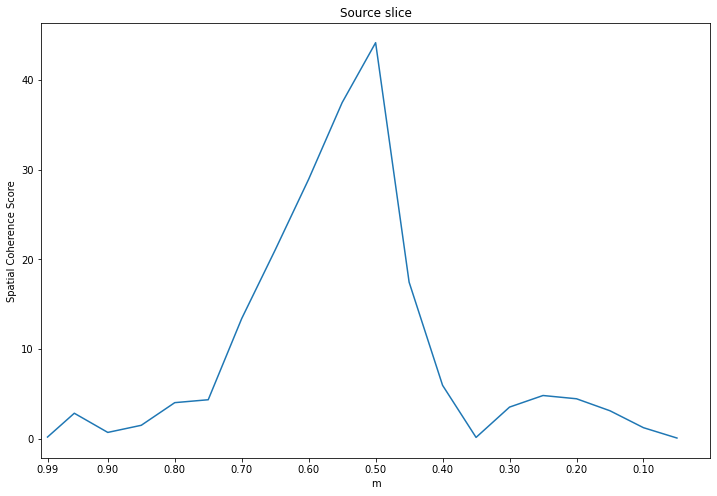

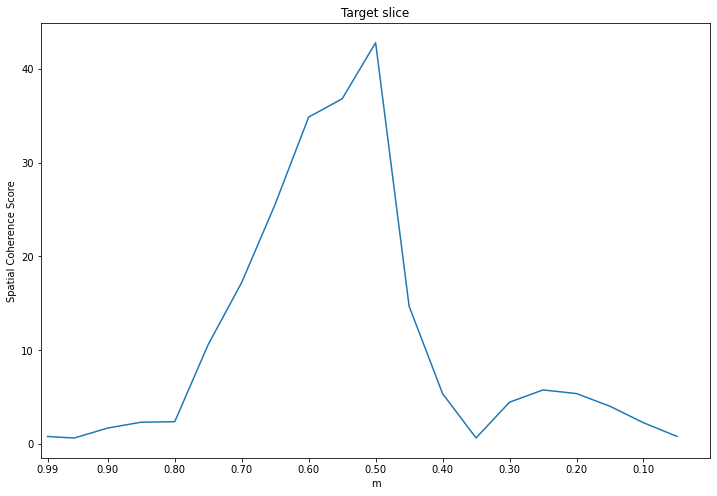

In [11]:
print("whole slice spatial coherence score")
sliceA_scores = []
sliceB_scores = []
for m in m_to_run:
    pi = m_to_pi_sim05_01[m]
    sliceA_score, sliceB_score = calculate_spatial_coherence_for_alignment(sliceA, sliceB, pi)
    sliceA_scores.append(sliceA_score)
    sliceB_scores.append(sliceB_score)
    
plot_score_curve(m_to_run, sliceA_scores, sliceB_scores)

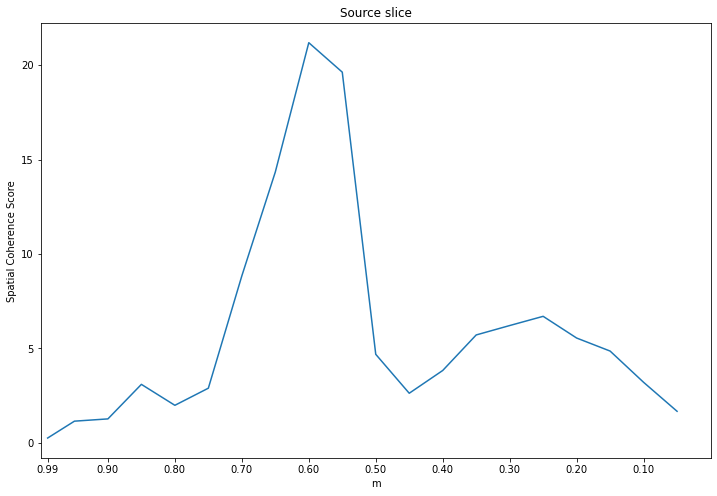

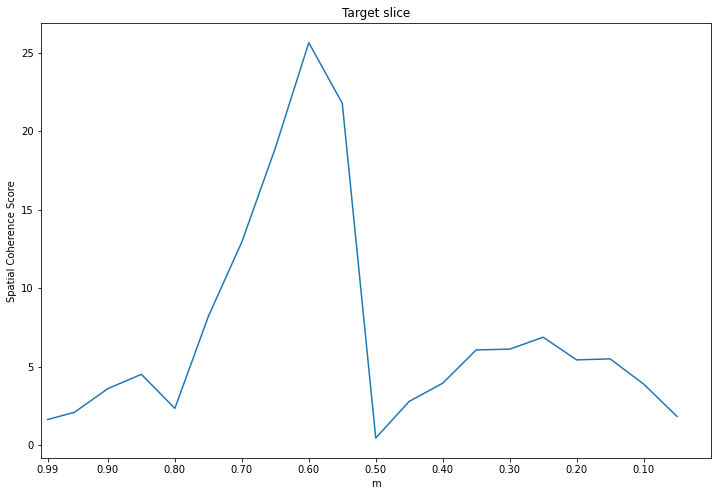

In [14]:
print("convex hull spatial coherence score")
sliceA_scores = []
sliceB_scores = []
m_to_run = [0.99, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]
for m in m_to_run:
    pi, log = partial_pairwise_align_given_cost_matrix(sliceA, sliceB, M=M, alpha=0.1, m=m, armijo=False,
                                                       norm=True, return_obj=True, verbose=False)
    sliceA_score, sliceB_score = calculate_convex_hull_spatial_coherence_score(sliceA, sliceB, pi)
    sliceA_scores.append(sliceA_score)
    sliceB_scores.append(sliceB_score)
    
plot_score_curve(m_to_run, sliceA_scores, sliceB_scores)

convex hull unaligned percentage


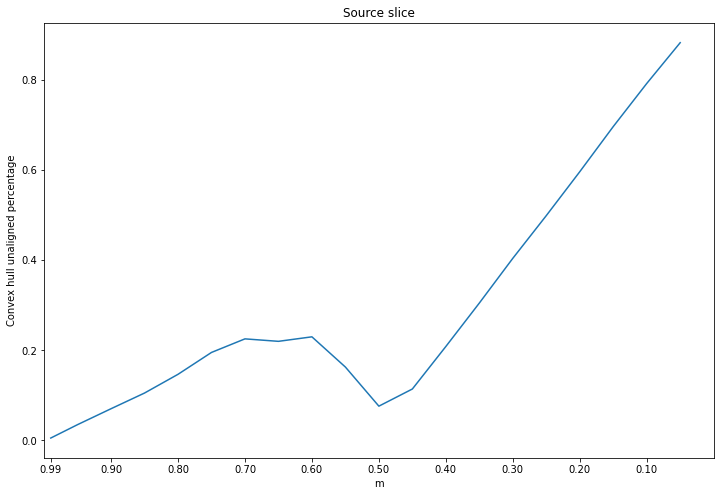

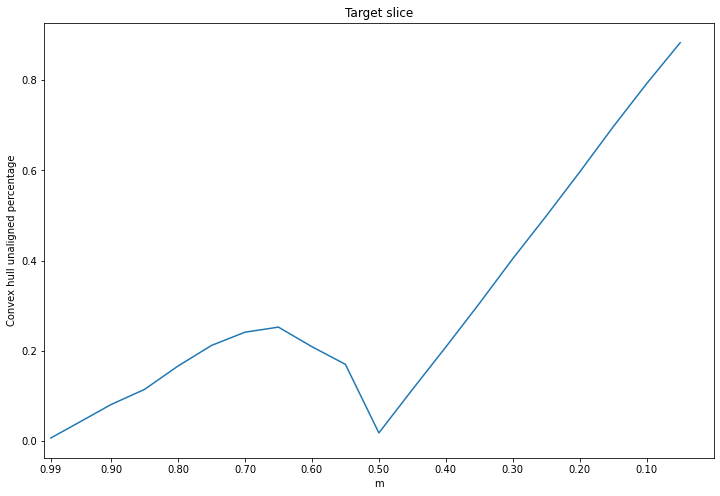

In [14]:
print("convex hull unaligned percentage")
sliceA_percentages = []
sliceB_percentages = []
for m in m_to_run:
    pi = m_to_pi_sim05_01[m]
    sliceA_percentage, sliceB_percentage = calculate_convex_hull_unaligned_percentage(sliceA, sliceB, pi)
    sliceA_percentages.append(sliceA_percentage)
    sliceB_percentages.append(sliceB_percentage)
    
plot_percentage_curve(m_to_run, sliceA_percentages, sliceB_percentages)

whole slice nonconsistent edge measure


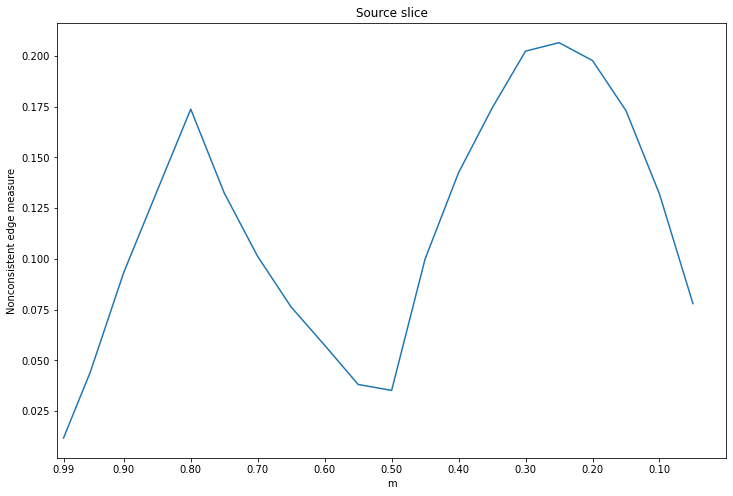

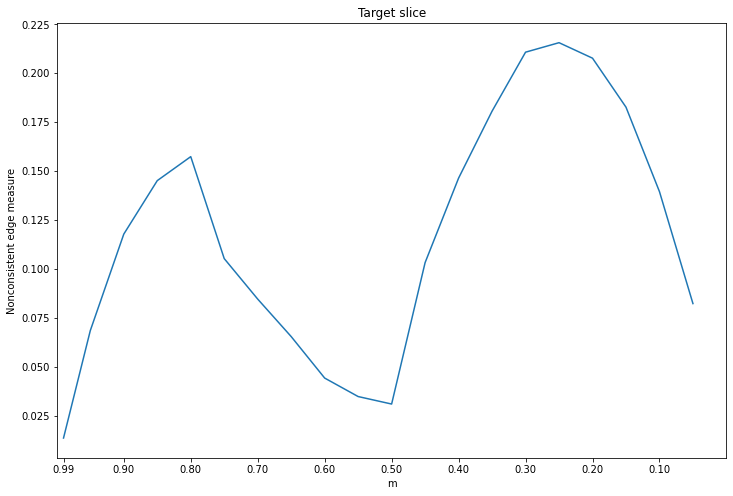

In [46]:
print("whole slice nonconsistent edge measure")
sliceA_measures = []
sliceB_measures = []
for m in m_to_run:
    pi = m_to_pi_sim05_01[m]
    sliceA_measure, sliceB_measure = calculate_nonconsistent_edge_measure_for_alignment(sliceA, sliceB, pi)
    sliceA_measures.append(sliceA_measure)
    sliceB_measures.append(sliceB_measure)
    
plot_edge_curve(m_to_run, sliceA_measures, sliceB_measures)

convex hull nonconsistent edge measure


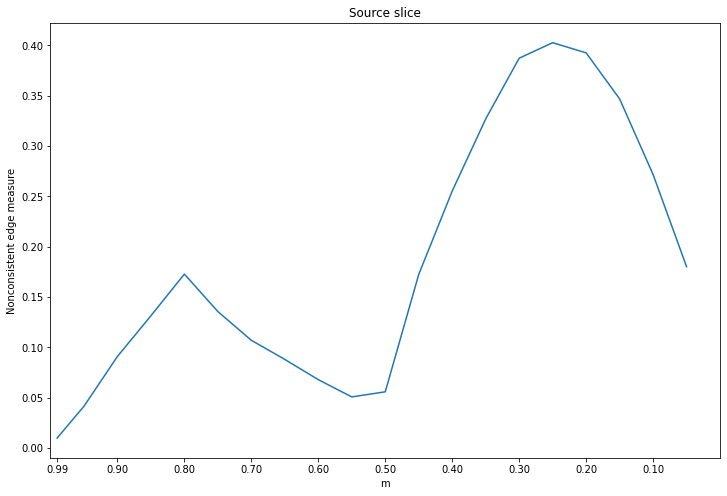

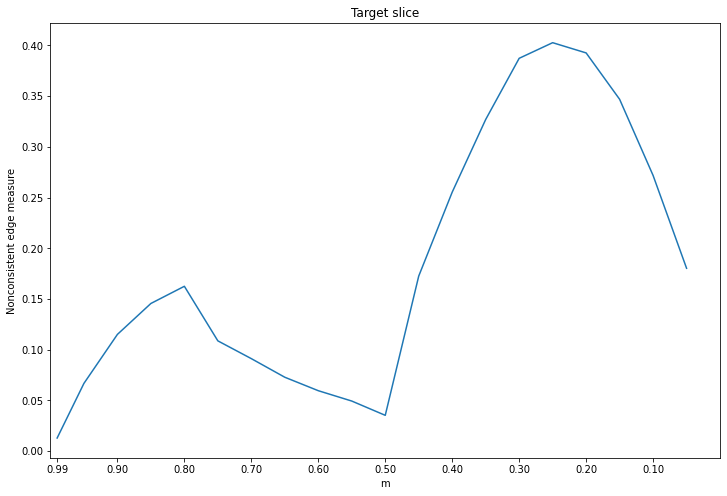

In [76]:
print("convex hull nonconsistent edge measure")
sliceA_measures = []
sliceB_measures = []
for m in m_to_run:
    pi = m_to_pi_sim05_01[m]
    sliceA_measure, sliceB_measure = calculate_convex_hull_noncosistent_edge_measure(sliceA, sliceB, pi)
    sliceA_measures.append(sliceA_measure)
    sliceB_measures.append(sliceB_measure)
    
plot_edge_curve(m_to_run, sliceA_measures, sliceB_measures)

In [ ]:
***
sim00-10
m=0.7
delta=0.1
***

In [77]:
sliceA_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/single_resample/pca/151674_overlap0.7_dropFalse_rotateFalse_resampleTrue_delta0.1_row0_col0.h5ad'
sliceB_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/single_resample/pca/151674_overlap0.7_dropFalse_rotateFalse_resampleTrue_delta0.1_row1_col0.h5ad'
sliceA = sc.read_h5ad(sliceA_filename)
sliceB = sc.read_h5ad(sliceB_filename)
common_genes = intersect(sliceA.var.index, sliceB.var.index)
sliceA = sliceA[:, common_genes]
sliceB = sliceB[:, common_genes]

In [36]:
# Get transport cost matrix
A_X, B_X = to_dense_array(extract_data_matrix(sliceA, None)), to_dense_array(extract_data_matrix(sliceB, None))
M = glmpca_distance(A_X, B_X, latent_dim=50, filter=True)

Starting GLM-PCA...
Iteration: 0 | deviance=1.3396E+7
Iteration: 1 | deviance=1.3395E+7
Iteration: 2 | deviance=1.2083E+7
Iteration: 3 | deviance=1.1693E+7
Iteration: 4 | deviance=1.1530E+7
Iteration: 5 | deviance=1.1452E+7
Iteration: 6 | deviance=1.1408E+7
Iteration: 7 | deviance=1.1379E+7
Iteration: 8 | deviance=1.1358E+7
Iteration: 9 | deviance=1.1343E+7
Iteration: 10 | deviance=1.1330E+7
Iteration: 11 | deviance=1.1321E+7
Iteration: 12 | deviance=1.1313E+7
Iteration: 13 | deviance=1.1306E+7
Iteration: 14 | deviance=1.1300E+7
Iteration: 15 | deviance=1.1296E+7
Iteration: 16 | deviance=1.1292E+7
Iteration: 17 | deviance=1.1288E+7
Iteration: 18 | deviance=1.1285E+7
Iteration: 19 | deviance=1.1282E+7
Iteration: 20 | deviance=1.1280E+7
Iteration: 21 | deviance=1.1277E+7
Iteration: 22 | deviance=1.1276E+7
Iteration: 23 | deviance=1.1274E+7
Iteration: 24 | deviance=1.1272E+7
Iteration: 25 | deviance=1.1271E+7
Iteration: 26 | deviance=1.1269E+7
Iteration: 27 | deviance=1.1268E+7
GLM-PCA fi

In [37]:
m_to_pi_sim07_01 = {}
for m in m_to_run:
    pi, log = partial_pairwise_align_given_cost_matrix(sliceA, sliceB, M=M, alpha=0.1, m=m, armijo=False,
                                                       norm=True, return_obj=True, verbose=False)
    m_to_pi_sim07_01[m] = pi

whole slice spatial coherence score


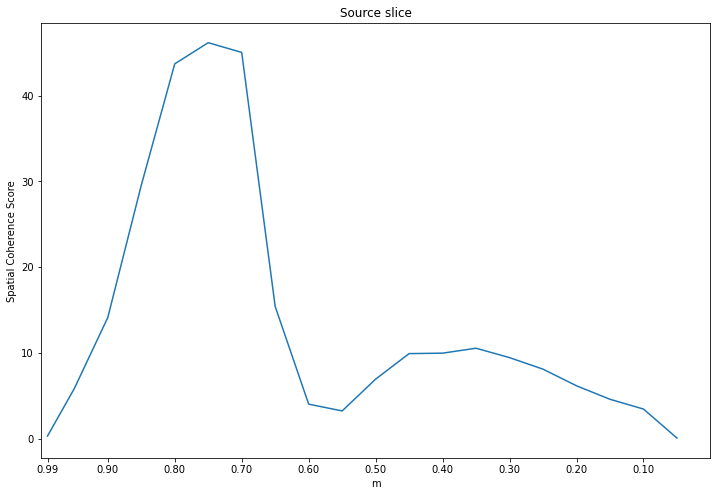

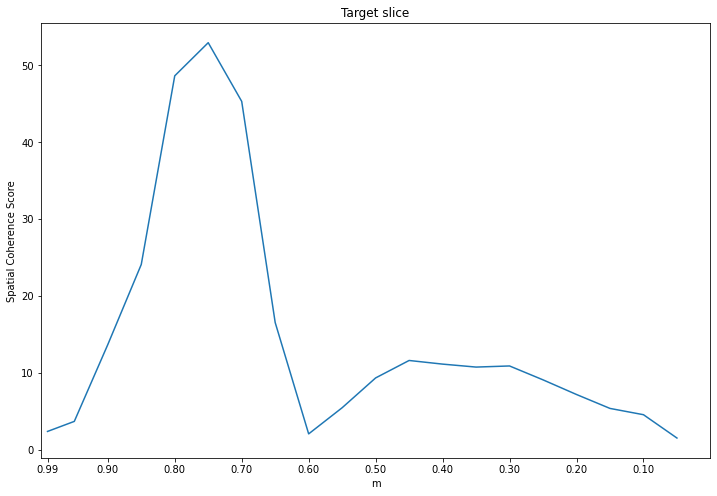

In [38]:
print("whole slice spatial coherence score")
sliceA_scores = []
sliceB_scores = []
for m in m_to_run:
    pi = m_to_pi_sim07_01[m]
    sliceA_score, sliceB_score = calculate_spatial_coherence_for_alignment(sliceA, sliceB, pi)
    sliceA_scores.append(sliceA_score)
    sliceB_scores.append(sliceB_score)
    
plot_score_curve(m_to_run, sliceA_scores, sliceB_scores)

whole slice nonconsistent edge measure


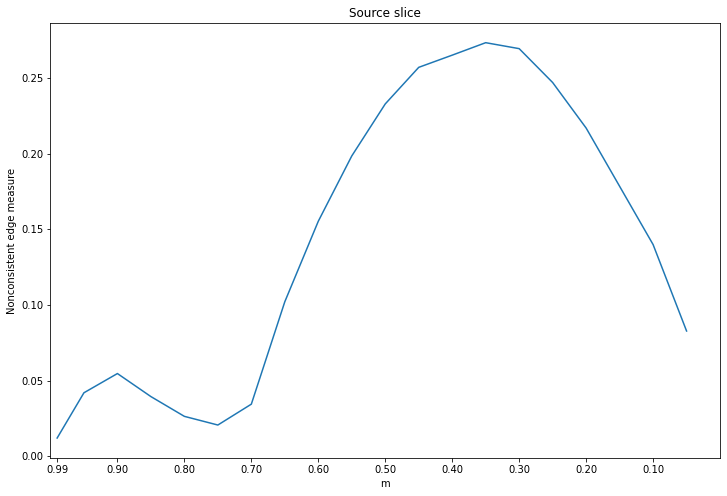

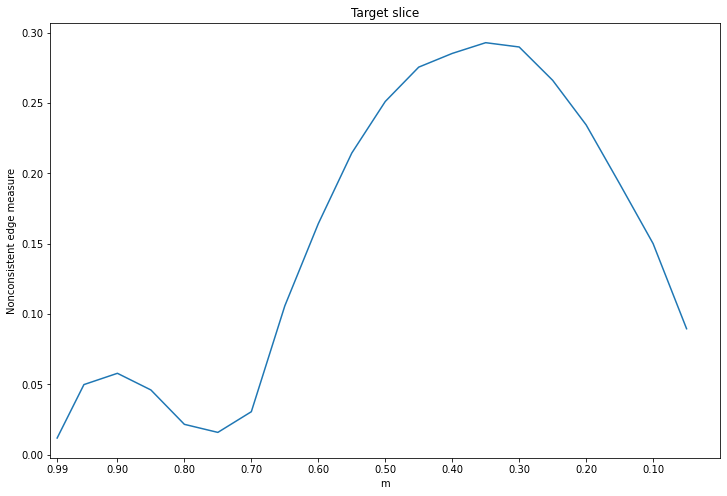

In [48]:
print("whole slice nonconsistent edge measure")
sliceA_measures = []
sliceB_measures = []
for m in m_to_run:
    pi = m_to_pi_sim07_01[m]
    sliceA_measure, sliceB_measure = calculate_nonconsistent_edge_measure_for_alignment(sliceA, sliceB, pi)
    sliceA_measures.append(sliceA_measure)
    sliceB_measures.append(sliceB_measure)
    
plot_edge_curve(m_to_run, sliceA_measures, sliceB_measures)

convex hull nonconsistent edge measure


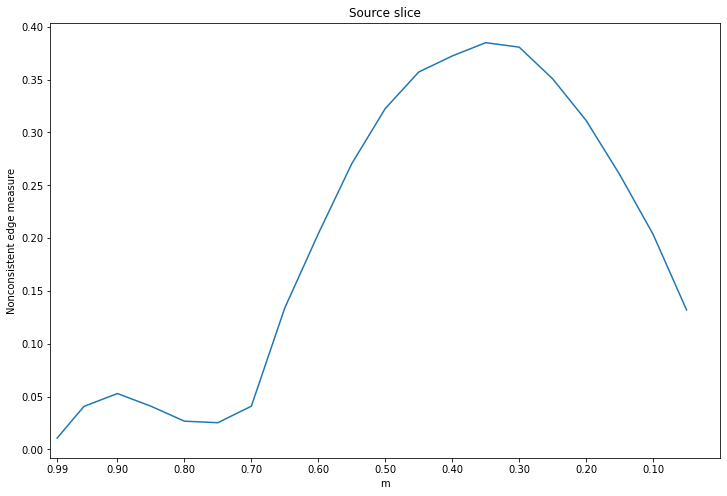

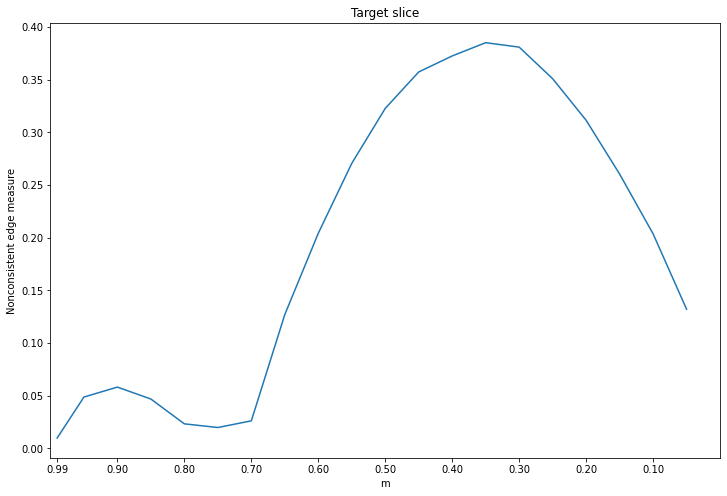

In [78]:
print("convex hull nonconsistent edge measure")
sliceA_measures = []
sliceB_measures = []
for m in m_to_run:
    pi = m_to_pi_sim07_01[m]
    sliceA_measure, sliceB_measure = calculate_convex_hull_noncosistent_edge_measure(sliceA, sliceB, pi)
    sliceA_measures.append(sliceA_measure)
    sliceB_measures.append(sliceB_measure)
    
plot_edge_curve(m_to_run, sliceA_measures, sliceB_measures)

In [ ]:
***
sim00-10
m=0.9
delta=0.1
***

In [66]:
sliceA_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/single_resample/pca/151674_overlap0.9_dropFalse_rotateFalse_resampleTrue_delta0.1_row0_col0.h5ad'
sliceB_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/single_resample/pca/151674_overlap0.9_dropFalse_rotateFalse_resampleTrue_delta0.1_row1_col0.h5ad'
sliceA = sc.read_h5ad(sliceA_filename)
sliceB = sc.read_h5ad(sliceB_filename)
common_genes = intersect(sliceA.var.index, sliceB.var.index)
sliceA = sliceA[:, common_genes]
sliceB = sliceB[:, common_genes]

In [54]:
# Get transport cost matrix
A_X, B_X = to_dense_array(extract_data_matrix(sliceA, None)), to_dense_array(extract_data_matrix(sliceB, None))
M = glmpca_distance(A_X, B_X, latent_dim=50, filter=True)

Starting GLM-PCA...
Iteration: 0 | deviance=1.9186E+7
Iteration: 1 | deviance=1.9183E+7
Iteration: 2 | deviance=1.7257E+7
Iteration: 3 | deviance=1.6740E+7
Iteration: 4 | deviance=1.6518E+7
Iteration: 5 | deviance=1.6411E+7
Iteration: 6 | deviance=1.6352E+7
Iteration: 7 | deviance=1.6312E+7
Iteration: 8 | deviance=1.6283E+7
Iteration: 9 | deviance=1.6261E+7
Iteration: 10 | deviance=1.6245E+7
Iteration: 11 | deviance=1.6232E+7
Iteration: 12 | deviance=1.6221E+7
Iteration: 13 | deviance=1.6213E+7
Iteration: 14 | deviance=1.6206E+7
Iteration: 15 | deviance=1.6200E+7
Iteration: 16 | deviance=1.6194E+7
Iteration: 17 | deviance=1.6190E+7
Iteration: 18 | deviance=1.6186E+7
Iteration: 19 | deviance=1.6182E+7
Iteration: 20 | deviance=1.6179E+7
Iteration: 21 | deviance=1.6177E+7
Iteration: 22 | deviance=1.6174E+7
Iteration: 23 | deviance=1.6172E+7
Iteration: 24 | deviance=1.6170E+7
Iteration: 25 | deviance=1.6168E+7
Iteration: 26 | deviance=1.6167E+7
GLM-PCA finished with joint matrix shape (657

In [55]:
m_to_pi_sim09_01 = {}
for m in m_to_run:
    pi, log = partial_pairwise_align_given_cost_matrix(sliceA, sliceB, M=M, alpha=0.1, m=m, armijo=False,
                                                       norm=True, return_obj=True, verbose=False)
    m_to_pi_sim09_01[m] = pi

whole slice spatial coherence score


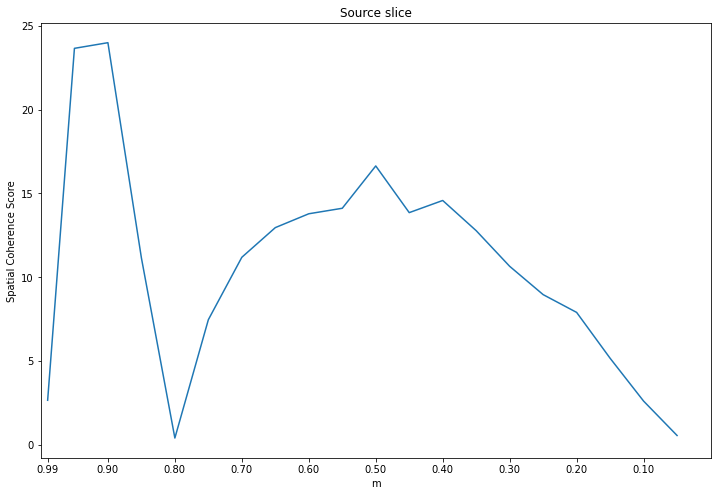

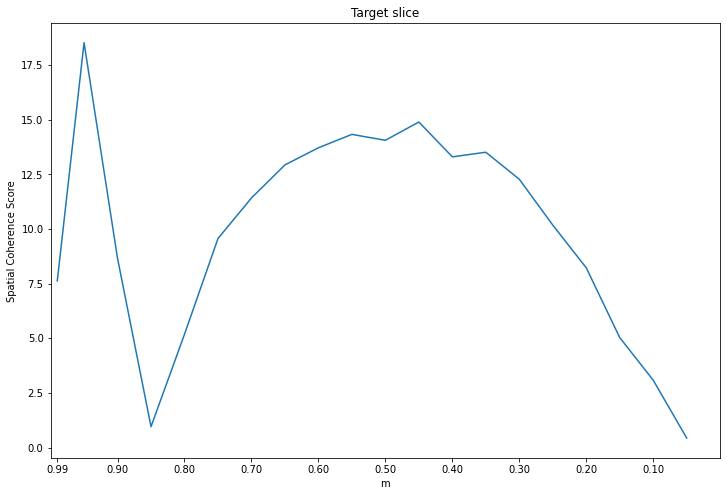

In [67]:
print("whole slice spatial coherence score")
sliceA_scores = []
sliceB_scores = []
for m in m_to_run:
    pi = m_to_pi_sim09_01[m]
    sliceA_score, sliceB_score = calculate_spatial_coherence_for_alignment(sliceA, sliceB, pi)
    sliceA_scores.append(sliceA_score)
    sliceB_scores.append(sliceB_score)
    
plot_score_curve(m_to_run, sliceA_scores, sliceB_scores)

convex hull nonconsistent edge measure


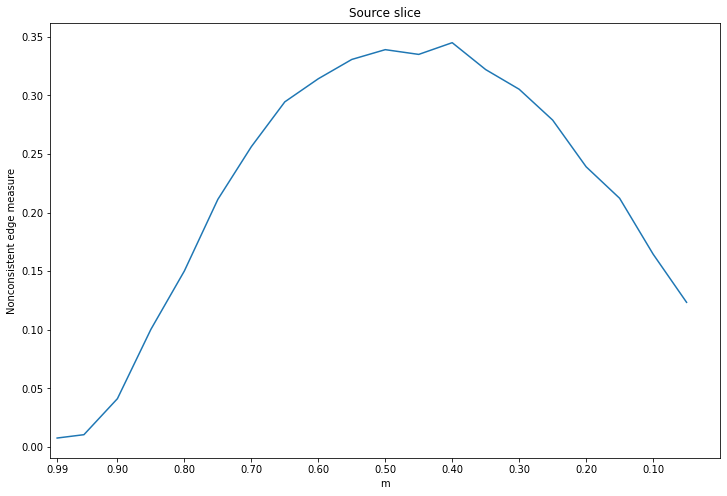

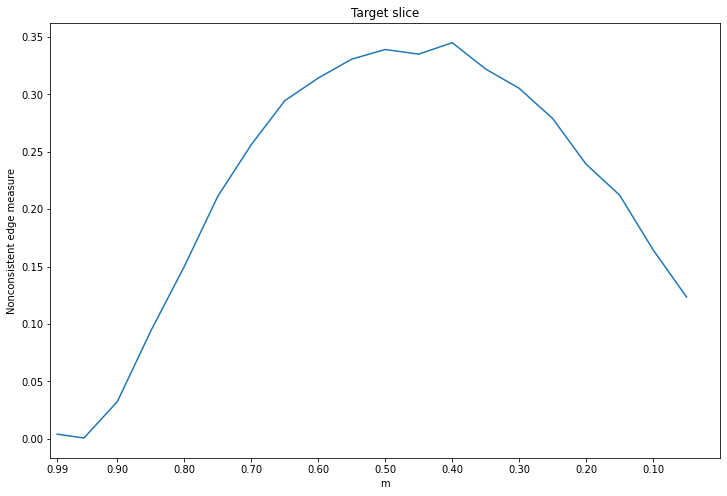

In [80]:
print("convex hull nonconsistent edge measure")
sliceA_measures = []
sliceB_measures = []
for m in m_to_run:
    pi = m_to_pi_sim09_01[m]
    sliceA_measure, sliceB_measure = calculate_convex_hull_noncosistent_edge_measure(sliceA, sliceB, pi)
    sliceA_measures.append(sliceA_measure)
    sliceB_measures.append(sliceB_measure)
    
plot_edge_curve(m_to_run, sliceA_measures, sliceB_measures)

In [ ]:
***
sim00-10
m=0.3
delta=1.0
***

In [104]:
sliceA_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/single_resample/pca/151674_overlap0.3_dropFalse_rotateFalse_resampleTrue_delta1.0_row0_col0.h5ad'
sliceB_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/single_resample/pca/151674_overlap0.3_dropFalse_rotateFalse_resampleTrue_delta1.0_row1_col0.h5ad'
sliceA = sc.read_h5ad(sliceA_filename)
sliceB = sc.read_h5ad(sliceB_filename)
common_genes = intersect(sliceA.var.index, sliceB.var.index)
sliceA = sliceA[:, common_genes]
sliceB = sliceB[:, common_genes]

In [99]:
# Get transport cost matrix
A_X, B_X = to_dense_array(extract_data_matrix(sliceA, None)), to_dense_array(extract_data_matrix(sliceB, None))
M = glmpca_distance(A_X, B_X, latent_dim=50, filter=True)

Starting GLM-PCA...
Iteration: 0 | deviance=6.1433E+6
Iteration: 1 | deviance=6.1432E+6
Iteration: 2 | deviance=5.6261E+6
Iteration: 3 | deviance=5.4495E+6
Iteration: 4 | deviance=5.3493E+6
Iteration: 5 | deviance=5.2973E+6
Iteration: 6 | deviance=5.2690E+6
Iteration: 7 | deviance=5.2508E+6
Iteration: 8 | deviance=5.2378E+6
Iteration: 9 | deviance=5.2282E+6
Iteration: 10 | deviance=5.2206E+6
Iteration: 11 | deviance=5.2146E+6
Iteration: 12 | deviance=5.2096E+6
Iteration: 13 | deviance=5.2055E+6
Iteration: 14 | deviance=5.2021E+6
Iteration: 15 | deviance=5.1991E+6
Iteration: 16 | deviance=5.1966E+6
Iteration: 17 | deviance=5.1944E+6
Iteration: 18 | deviance=5.1925E+6
Iteration: 19 | deviance=5.1908E+6
Iteration: 20 | deviance=5.1892E+6
Iteration: 21 | deviance=5.1879E+6
Iteration: 22 | deviance=5.1866E+6
Iteration: 23 | deviance=5.1855E+6
Iteration: 24 | deviance=5.1845E+6
Iteration: 25 | deviance=5.1835E+6
Iteration: 26 | deviance=5.1826E+6
Iteration: 27 | deviance=5.1818E+6
Iteration:

In [100]:
m_to_pi_sim03_10 = {}
for m in m_to_run:
    pi, log = partial_pairwise_align_given_cost_matrix(sliceA, sliceB, M=M, alpha=0.1, m=m, armijo=False,
                                                       norm=True, return_obj=True, verbose=False)
    m_to_pi_sim03_10[m] = pi

convex hull nonconsistent edge measure


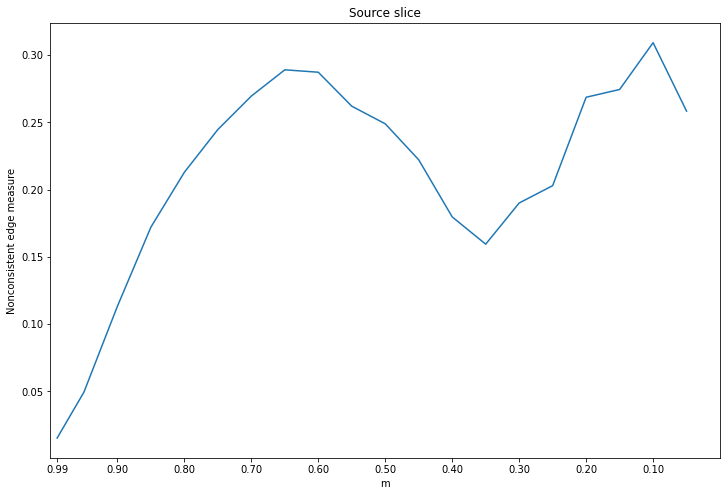

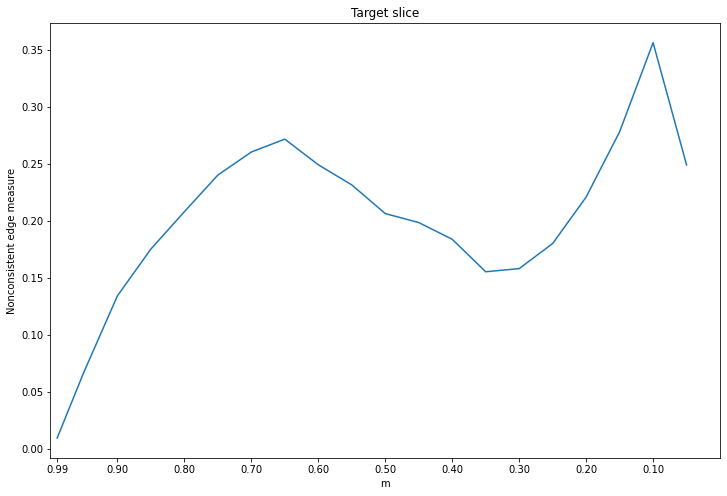

In [105]:
print("convex hull nonconsistent edge measure")
sliceA_measures = []
sliceB_measures = []
for m in m_to_run:
    pi = m_to_pi_sim03_10[m]
    sliceA_measure, sliceB_measure = calculate_convex_hull_noncosistent_edge_measure(sliceA, sliceB, pi)
    sliceA_measures.append(sliceA_measure)
    sliceB_measures.append(sliceB_measure)
    
plot_edge_curve(m_to_run, sliceA_measures, sliceB_measures)

In [ ]:
***
sim00-10
m=0.5
delta=1.0
***

In [106]:
sliceA_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/single_resample/pca/151674_overlap0.5_dropFalse_rotateFalse_resampleTrue_delta1.0_row0_col0.h5ad'
sliceB_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/single_resample/pca/151674_overlap0.5_dropFalse_rotateFalse_resampleTrue_delta1.0_row1_col0.h5ad'
sliceA = sc.read_h5ad(sliceA_filename)
sliceB = sc.read_h5ad(sliceB_filename)
common_genes = intersect(sliceA.var.index, sliceB.var.index)
sliceA = sliceA[:, common_genes]
sliceB = sliceB[:, common_genes]

In [102]:
# Get transport cost matrix
A_X, B_X = to_dense_array(extract_data_matrix(sliceA, None)), to_dense_array(extract_data_matrix(sliceB, None))
M = glmpca_distance(A_X, B_X, latent_dim=50, filter=True)

Starting GLM-PCA...
Iteration: 0 | deviance=8.1306E+6
Iteration: 1 | deviance=8.1304E+6
Iteration: 2 | deviance=7.4196E+6
Iteration: 3 | deviance=7.1880E+6
Iteration: 4 | deviance=7.0779E+6
Iteration: 5 | deviance=7.0222E+6
Iteration: 6 | deviance=6.9906E+6
Iteration: 7 | deviance=6.9703E+6
Iteration: 8 | deviance=6.9559E+6
Iteration: 9 | deviance=6.9449E+6
Iteration: 10 | deviance=6.9363E+6
Iteration: 11 | deviance=6.9293E+6
Iteration: 12 | deviance=6.9235E+6
Iteration: 13 | deviance=6.9186E+6
Iteration: 14 | deviance=6.9145E+6
Iteration: 15 | deviance=6.9110E+6
Iteration: 16 | deviance=6.9081E+6
Iteration: 17 | deviance=6.9055E+6
Iteration: 18 | deviance=6.9032E+6
Iteration: 19 | deviance=6.9013E+6
Iteration: 20 | deviance=6.8996E+6
Iteration: 21 | deviance=6.8980E+6
Iteration: 22 | deviance=6.8967E+6
Iteration: 23 | deviance=6.8954E+6
Iteration: 24 | deviance=6.8943E+6
Iteration: 25 | deviance=6.8933E+6
Iteration: 26 | deviance=6.8923E+6
Iteration: 27 | deviance=6.8915E+6
Iteration:

In [103]:
m_to_pi_sim05_10 = {}
for m in m_to_run:
    pi, log = partial_pairwise_align_given_cost_matrix(sliceA, sliceB, M=M, alpha=0.1, m=m, armijo=False,
                                                       norm=True, return_obj=True, verbose=False)
    m_to_pi_sim05_10[m] = pi

convex hull nonconsistent edge measure


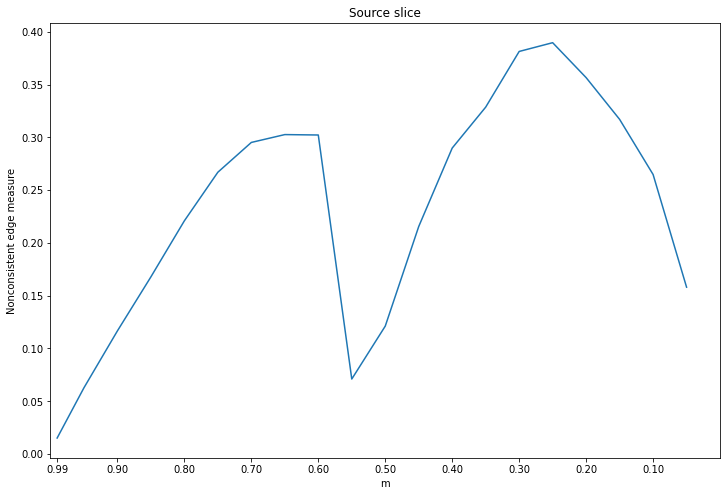

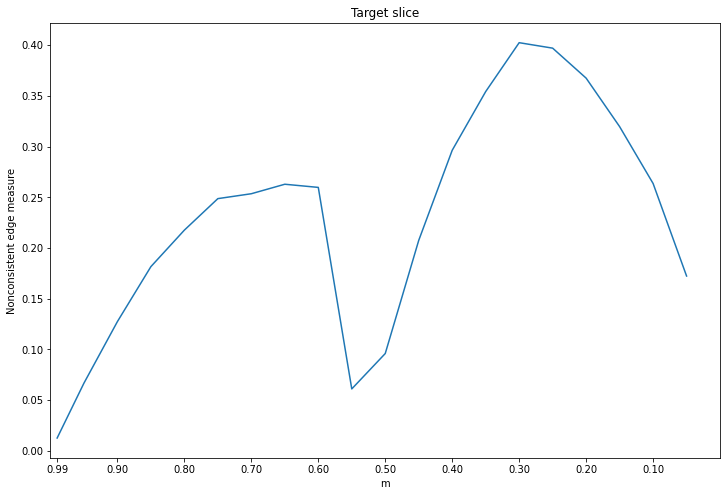

In [107]:
print("convex hull nonconsistent edge measure")
sliceA_measures = []
sliceB_measures = []
for m in m_to_run:
    pi = m_to_pi_sim05_10[m]
    sliceA_measure, sliceB_measure = calculate_convex_hull_noncosistent_edge_measure(sliceA, sliceB, pi)
    sliceA_measures.append(sliceA_measure)
    sliceB_measures.append(sliceB_measure)
    
plot_edge_curve(m_to_run, sliceA_measures, sliceB_measures)

In [ ]:
***
sim00-10
m=0.7
delta=1.0
***

In [26]:
sliceA_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/single_resample/pca/151674_overlap0.7_dropFalse_rotateFalse_resampleTrue_delta1.0_row0_col0.h5ad'
sliceB_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/single_resample/pca/151674_overlap0.7_dropFalse_rotateFalse_resampleTrue_delta1.0_row1_col0.h5ad'
sliceA = sc.read_h5ad(sliceA_filename)
sliceB = sc.read_h5ad(sliceB_filename)
common_genes = intersect(sliceA.var.index, sliceB.var.index)
sliceA = sliceA[:, common_genes]
sliceB = sliceB[:, common_genes]

In [19]:
# Get transport cost matrix
A_X, B_X = to_dense_array(extract_data_matrix(sliceA, None)), to_dense_array(extract_data_matrix(sliceB, None))
M = glmpca_distance(A_X, B_X, latent_dim=50, filter=True)

Starting GLM-PCA...
Iteration: 0 | deviance=1.1327E+7
Iteration: 1 | deviance=1.1326E+7
Iteration: 2 | deviance=1.0201E+7
Iteration: 3 | deviance=9.8989E+6
Iteration: 4 | deviance=9.7611E+6
Iteration: 5 | deviance=9.6952E+6
Iteration: 6 | deviance=9.6594E+6
Iteration: 7 | deviance=9.6367E+6
Iteration: 8 | deviance=9.6212E+6
Iteration: 9 | deviance=9.6100E+6
Iteration: 10 | deviance=9.6015E+6
Iteration: 11 | deviance=9.5947E+6
Iteration: 12 | deviance=9.5891E+6
Iteration: 13 | deviance=9.5844E+6
Iteration: 14 | deviance=9.5804E+6
Iteration: 15 | deviance=9.5770E+6
Iteration: 16 | deviance=9.5740E+6
Iteration: 17 | deviance=9.5714E+6
Iteration: 18 | deviance=9.5691E+6
Iteration: 19 | deviance=9.5671E+6
Iteration: 20 | deviance=9.5653E+6
Iteration: 21 | deviance=9.5637E+6
Iteration: 22 | deviance=9.5622E+6
Iteration: 23 | deviance=9.5609E+6
Iteration: 24 | deviance=9.5597E+6
Iteration: 25 | deviance=9.5586E+6
Iteration: 26 | deviance=9.5576E+6
GLM-PCA finished with joint matrix shape (467

In [20]:
m_to_pi_sim07_10 = {}
for m in m_to_run:
    pi, log = partial_pairwise_align_given_cost_matrix(sliceA, sliceB, M=M, alpha=0.1, m=m, armijo=False,
                                                       norm=True, return_obj=True, verbose=False)
    m_to_pi_sim07_10[m] = pi

convex hull nonconsistent edge measure


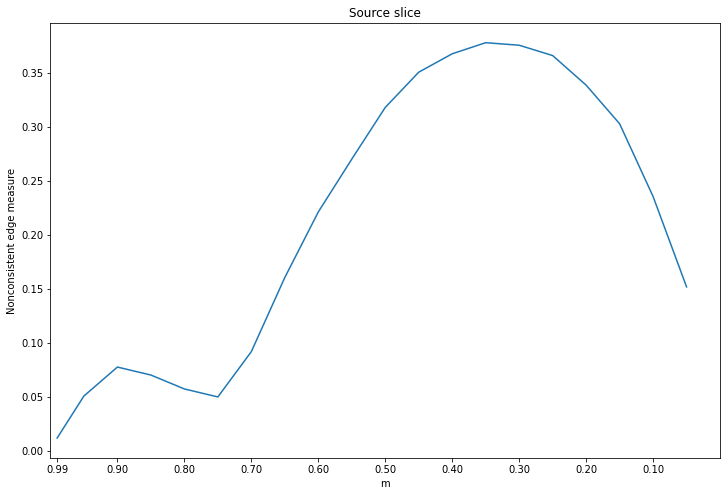

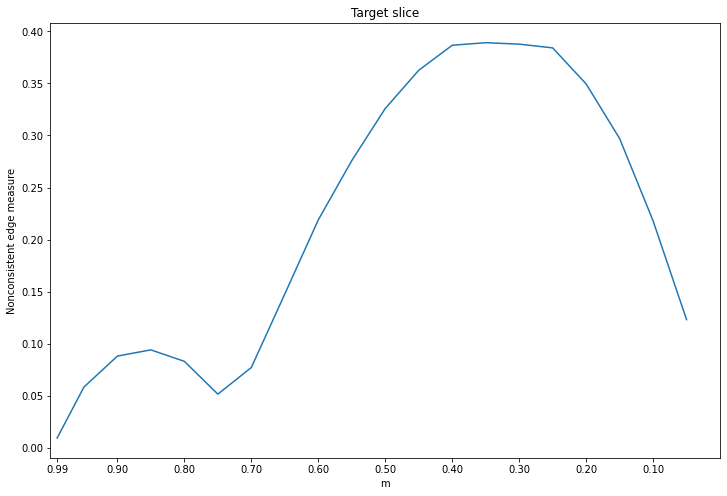

In [27]:
print("convex hull nonconsistent edge measure")
sliceA_measures = []
sliceB_measures = []
for m in m_to_run:
    pi = m_to_pi_sim07_10[m]
    sliceA_measure, sliceB_measure = calculate_convex_hull_noncosistent_edge_measure(sliceA, sliceB, pi)
    sliceA_measures.append(sliceA_measure)
    sliceB_measures.append(sliceB_measure)
    
plot_edge_curve(m_to_run, sliceA_measures, sliceB_measures)

In [ ]:
***
sim00-10
m=0.9
delta=1.0
***

In [28]:
sliceA_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/single_resample/pca/151674_overlap0.9_dropFalse_rotateFalse_resampleTrue_delta1.0_row0_col0.h5ad'
sliceB_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/single_resample/pca/151674_overlap0.9_dropFalse_rotateFalse_resampleTrue_delta1.0_row1_col0.h5ad'
sliceA = sc.read_h5ad(sliceA_filename)
sliceB = sc.read_h5ad(sliceB_filename)
common_genes = intersect(sliceA.var.index, sliceB.var.index)
sliceA = sliceA[:, common_genes]
sliceB = sliceB[:, common_genes]

In [4]:
# Get transport cost matrix
A_X, B_X = to_dense_array(extract_data_matrix(sliceA, None)), to_dense_array(extract_data_matrix(sliceB, None))
M = glmpca_distance(A_X, B_X, latent_dim=50, filter=True)

Starting GLM-PCA...
Iteration: 0 | deviance=1.6316E+7
Iteration: 1 | deviance=1.6314E+7
Iteration: 2 | deviance=1.4496E+7
Iteration: 3 | deviance=1.4137E+7
Iteration: 4 | deviance=1.3960E+7
Iteration: 5 | deviance=1.3868E+7
Iteration: 6 | deviance=1.3817E+7
Iteration: 7 | deviance=1.3785E+7
Iteration: 8 | deviance=1.3764E+7
Iteration: 9 | deviance=1.3749E+7
Iteration: 10 | deviance=1.3737E+7
Iteration: 11 | deviance=1.3727E+7
Iteration: 12 | deviance=1.3719E+7
Iteration: 13 | deviance=1.3713E+7
Iteration: 14 | deviance=1.3707E+7
Iteration: 15 | deviance=1.3702E+7
Iteration: 16 | deviance=1.3698E+7
Iteration: 17 | deviance=1.3694E+7
Iteration: 18 | deviance=1.3691E+7
Iteration: 19 | deviance=1.3688E+7
Iteration: 20 | deviance=1.3686E+7
Iteration: 21 | deviance=1.3683E+7
Iteration: 22 | deviance=1.3681E+7
Iteration: 23 | deviance=1.3679E+7
Iteration: 24 | deviance=1.3678E+7
Iteration: 25 | deviance=1.3676E+7
Iteration: 26 | deviance=1.3675E+7
GLM-PCA finished with joint matrix shape (657

In [5]:
m_to_pi_sim09_10 = {}
for m in m_to_run:
    pi, log = partial_pairwise_align_given_cost_matrix(sliceA, sliceB, M=M, alpha=0.1, m=m, armijo=False,
                                                       norm=True, return_obj=True, verbose=False)
    m_to_pi_sim09_10[m] = pi

convex hull nonconsistent edge measure


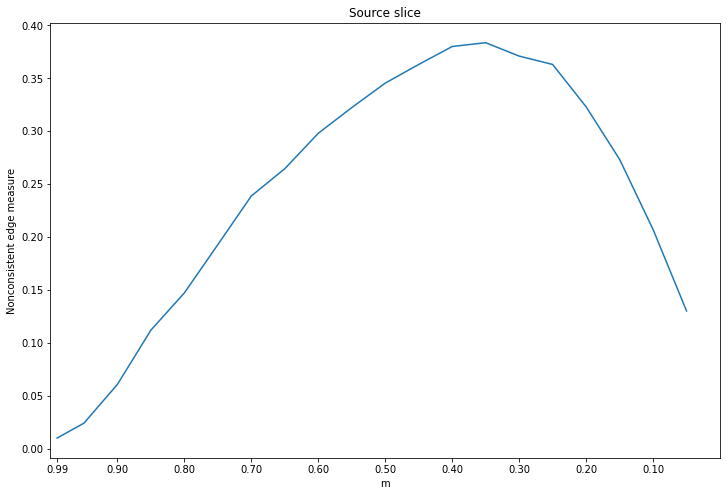

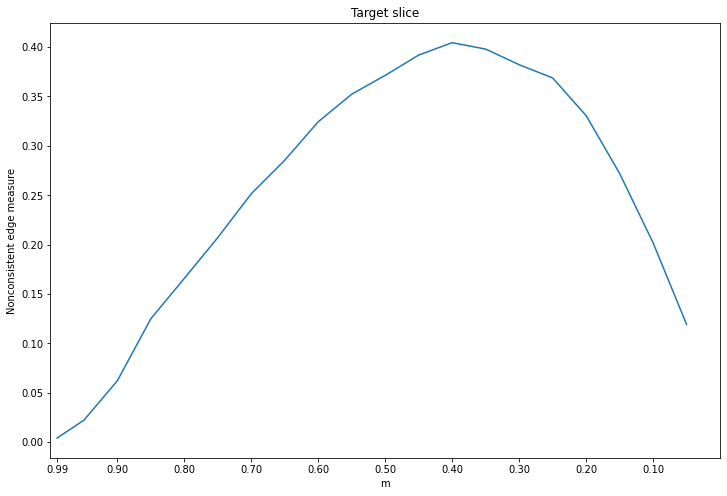

In [29]:
print("convex hull nonconsistent edge measure")
sliceA_measures = []
sliceB_measures = []
for m in m_to_run:
    pi = m_to_pi_sim09_10[m]
    sliceA_measure, sliceB_measure = calculate_convex_hull_noncosistent_edge_measure(sliceA, sliceB, pi)
    sliceA_measures.append(sliceA_measure)
    sliceB_measures.append(sliceB_measure)
    
plot_edge_curve(m_to_run, sliceA_measures, sliceB_measures)

In [ ]:
***
sim00-10
m=0.3
delta=3.0
***

In [30]:
sliceA_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/single_resample/pca/151674_overlap0.3_dropFalse_rotateFalse_resampleTrue_delta3.0_row0_col0.h5ad'
sliceB_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/single_resample/pca/151674_overlap0.3_dropFalse_rotateFalse_resampleTrue_delta3.0_row1_col0.h5ad'
sliceA = sc.read_h5ad(sliceA_filename)
sliceB = sc.read_h5ad(sliceB_filename)
common_genes = intersect(sliceA.var.index, sliceB.var.index)
sliceA = sliceA[:, common_genes]
sliceB = sliceB[:, common_genes]

In [7]:
# Get transport cost matrix
A_X, B_X = to_dense_array(extract_data_matrix(sliceA, None)), to_dense_array(extract_data_matrix(sliceB, None))
M = glmpca_distance(A_X, B_X, latent_dim=50, filter=True)

Starting GLM-PCA...
Iteration: 0 | deviance=6.0098E+6
Iteration: 1 | deviance=6.0095E+6
Iteration: 2 | deviance=5.3667E+6
Iteration: 3 | deviance=5.1872E+6
Iteration: 4 | deviance=5.0891E+6
Iteration: 5 | deviance=5.0428E+6
Iteration: 6 | deviance=5.0184E+6
Iteration: 7 | deviance=5.0034E+6
Iteration: 8 | deviance=4.9933E+6
Iteration: 9 | deviance=4.9860E+6
Iteration: 10 | deviance=4.9803E+6
Iteration: 11 | deviance=4.9757E+6
Iteration: 12 | deviance=4.9720E+6
Iteration: 13 | deviance=4.9688E+6
Iteration: 14 | deviance=4.9661E+6
Iteration: 15 | deviance=4.9638E+6
Iteration: 16 | deviance=4.9618E+6
Iteration: 17 | deviance=4.9601E+6
Iteration: 18 | deviance=4.9585E+6
Iteration: 19 | deviance=4.9572E+6
Iteration: 20 | deviance=4.9559E+6
Iteration: 21 | deviance=4.9548E+6
Iteration: 22 | deviance=4.9538E+6
Iteration: 23 | deviance=4.9530E+6
Iteration: 24 | deviance=4.9521E+6
Iteration: 25 | deviance=4.9514E+6
Iteration: 26 | deviance=4.9507E+6
Iteration: 27 | deviance=4.9501E+6
Iteration:

In [8]:
m_to_pi_sim03_30 = {}
for m in m_to_run:
    pi, log = partial_pairwise_align_given_cost_matrix(sliceA, sliceB, M=M, alpha=0.1, m=m, armijo=False,
                                                       norm=True, return_obj=True, verbose=False)
    m_to_pi_sim03_30[m] = pi

convex hull nonconsistent edge measure


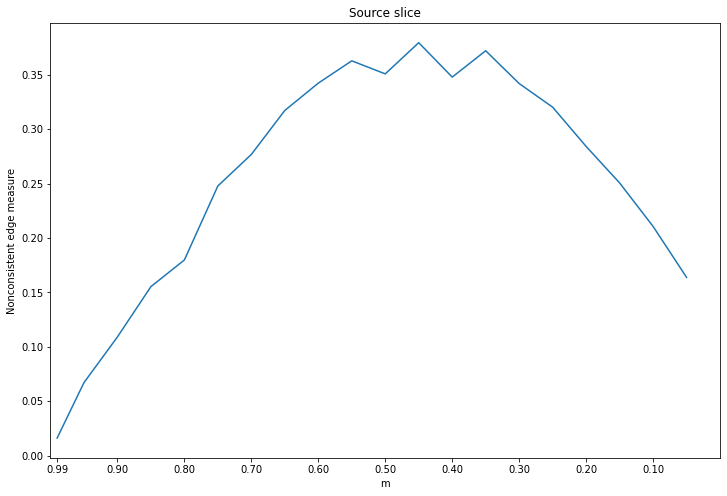

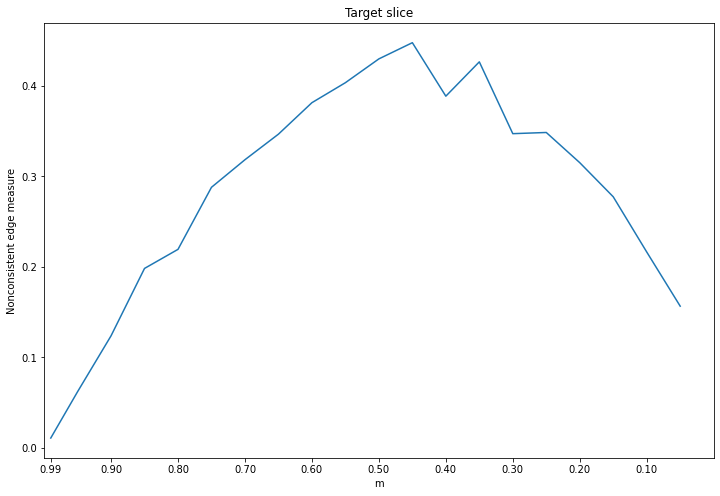

In [31]:
print("convex hull nonconsistent edge measure")
sliceA_measures = []
sliceB_measures = []
for m in m_to_run:
    pi = m_to_pi_sim03_30[m]
    sliceA_measure, sliceB_measure = calculate_convex_hull_noncosistent_edge_measure(sliceA, sliceB, pi)
    sliceA_measures.append(sliceA_measure)
    sliceB_measures.append(sliceB_measure)
    
plot_edge_curve(m_to_run, sliceA_measures, sliceB_measures)

In [ ]:
***
sim00-10
m=0.5
delta=3.0
***

In [32]:
sliceA_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/single_resample/pca/151674_overlap0.5_dropFalse_rotateFalse_resampleTrue_delta3.0_row0_col0.h5ad'
sliceB_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/single_resample/pca/151674_overlap0.5_dropFalse_rotateFalse_resampleTrue_delta3.0_row1_col0.h5ad'
sliceA = sc.read_h5ad(sliceA_filename)
sliceB = sc.read_h5ad(sliceB_filename)
common_genes = intersect(sliceA.var.index, sliceB.var.index)
sliceA = sliceA[:, common_genes]
sliceB = sliceB[:, common_genes]

In [10]:
# Get transport cost matrix
A_X, B_X = to_dense_array(extract_data_matrix(sliceA, None)), to_dense_array(extract_data_matrix(sliceB, None))
M = glmpca_distance(A_X, B_X, latent_dim=50, filter=True)

Starting GLM-PCA...
Iteration: 0 | deviance=7.9995E+6
Iteration: 1 | deviance=7.9991E+6
Iteration: 2 | deviance=7.0747E+6
Iteration: 3 | deviance=6.8694E+6
Iteration: 4 | deviance=6.7641E+6
Iteration: 5 | deviance=6.7100E+6
Iteration: 6 | deviance=6.6806E+6
Iteration: 7 | deviance=6.6622E+6
Iteration: 8 | deviance=6.6494E+6
Iteration: 9 | deviance=6.6398E+6
Iteration: 10 | deviance=6.6324E+6
Iteration: 11 | deviance=6.6264E+6
Iteration: 12 | deviance=6.6215E+6
Iteration: 13 | deviance=6.6174E+6
Iteration: 14 | deviance=6.6139E+6
Iteration: 15 | deviance=6.6109E+6
Iteration: 16 | deviance=6.6083E+6
Iteration: 17 | deviance=6.6061E+6
Iteration: 18 | deviance=6.6041E+6
Iteration: 19 | deviance=6.6023E+6
Iteration: 20 | deviance=6.6007E+6
Iteration: 21 | deviance=6.5993E+6
Iteration: 22 | deviance=6.5980E+6
Iteration: 23 | deviance=6.5969E+6
Iteration: 24 | deviance=6.5958E+6
Iteration: 25 | deviance=6.5949E+6
Iteration: 26 | deviance=6.5940E+6
Iteration: 27 | deviance=6.5932E+6
Iteration:

In [11]:
m_to_pi_sim05_30 = {}
for m in m_to_run:
    pi, log = partial_pairwise_align_given_cost_matrix(sliceA, sliceB, M=M, alpha=0.1, m=m, armijo=False,
                                                       norm=True, return_obj=True, verbose=False)
    m_to_pi_sim05_30[m] = pi

convex hull nonconsistent edge measure


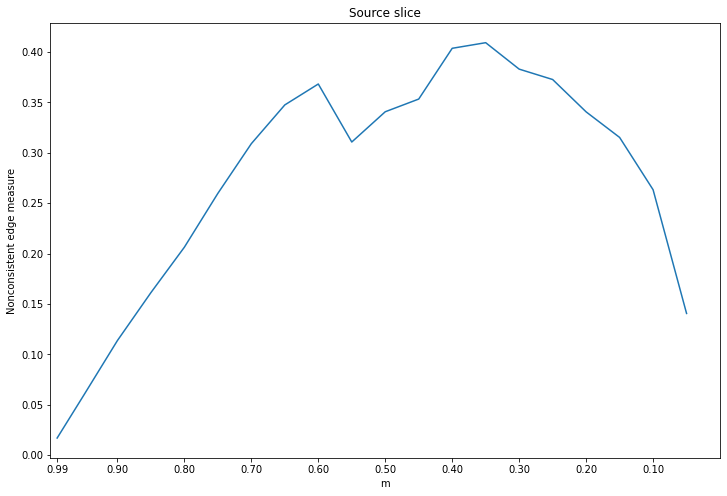

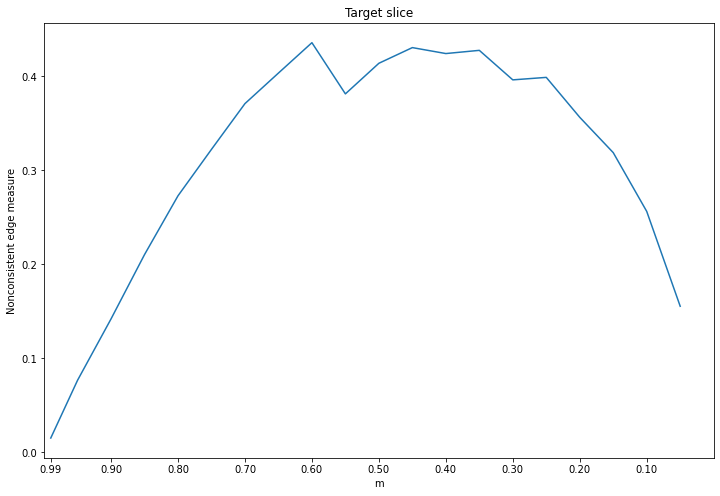

In [33]:
print("convex hull nonconsistent edge measure")
sliceA_measures = []
sliceB_measures = []
for m in m_to_run:
    pi = m_to_pi_sim05_30[m]
    sliceA_measure, sliceB_measure = calculate_convex_hull_noncosistent_edge_measure(sliceA, sliceB, pi)
    sliceA_measures.append(sliceA_measure)
    sliceB_measures.append(sliceB_measure)
    
plot_edge_curve(m_to_run, sliceA_measures, sliceB_measures)

In [ ]:
***
sim00-10
m=0.7
delta=3.0
***

In [34]:
sliceA_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/single_resample/pca/151674_overlap0.7_dropFalse_rotateFalse_resampleTrue_delta3.0_row0_col0.h5ad'
sliceB_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/single_resample/pca/151674_overlap0.7_dropFalse_rotateFalse_resampleTrue_delta3.0_row1_col0.h5ad'
sliceA = sc.read_h5ad(sliceA_filename)
sliceB = sc.read_h5ad(sliceB_filename)
common_genes = intersect(sliceA.var.index, sliceB.var.index)
sliceA = sliceA[:, common_genes]
sliceB = sliceB[:, common_genes]

In [13]:
# Get transport cost matrix
A_X, B_X = to_dense_array(extract_data_matrix(sliceA, None)), to_dense_array(extract_data_matrix(sliceB, None))
M = glmpca_distance(A_X, B_X, latent_dim=50, filter=True)

Starting GLM-PCA...
Iteration: 0 | deviance=1.1224E+7
Iteration: 1 | deviance=1.1223E+7
Iteration: 2 | deviance=9.7601E+6
Iteration: 3 | deviance=9.4982E+6
Iteration: 4 | deviance=9.3699E+6
Iteration: 5 | deviance=9.2965E+6
Iteration: 6 | deviance=9.2556E+6
Iteration: 7 | deviance=9.2303E+6
Iteration: 8 | deviance=9.2133E+6
Iteration: 9 | deviance=9.2014E+6
Iteration: 10 | deviance=9.1924E+6
Iteration: 11 | deviance=9.1854E+6
Iteration: 12 | deviance=9.1798E+6
Iteration: 13 | deviance=9.1752E+6
Iteration: 14 | deviance=9.1713E+6
Iteration: 15 | deviance=9.1679E+6
Iteration: 16 | deviance=9.1650E+6
Iteration: 17 | deviance=9.1625E+6
Iteration: 18 | deviance=9.1603E+6
Iteration: 19 | deviance=9.1584E+6
Iteration: 20 | deviance=9.1566E+6
Iteration: 21 | deviance=9.1551E+6
Iteration: 22 | deviance=9.1536E+6
Iteration: 23 | deviance=9.1524E+6
Iteration: 24 | deviance=9.1512E+6
Iteration: 25 | deviance=9.1501E+6
Iteration: 26 | deviance=9.1492E+6
GLM-PCA finished with joint matrix shape (467

In [14]:
m_to_pi_sim07_30 = {}
for m in m_to_run:
    pi, log = partial_pairwise_align_given_cost_matrix(sliceA, sliceB, M=M, alpha=0.1, m=m, armijo=False,
                                                       norm=True, return_obj=True, verbose=False)
    m_to_pi_sim07_30[m] = pi

convex hull nonconsistent edge measure


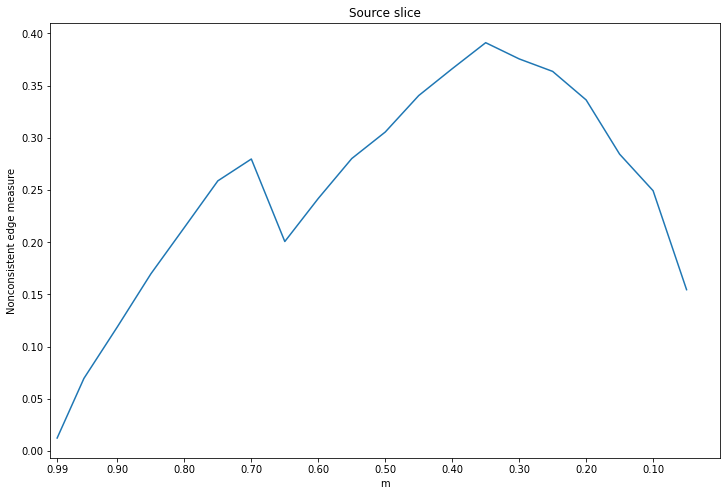

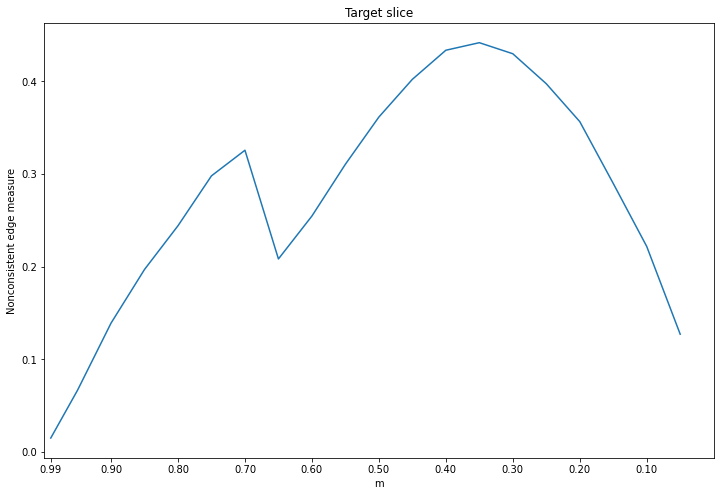

In [35]:
print("convex hull nonconsistent edge measure")
sliceA_measures = []
sliceB_measures = []
for m in m_to_run:
    pi = m_to_pi_sim07_30[m]
    sliceA_measure, sliceB_measure = calculate_convex_hull_noncosistent_edge_measure(sliceA, sliceB, pi)
    sliceA_measures.append(sliceA_measure)
    sliceB_measures.append(sliceB_measure)
    
plot_edge_curve(m_to_run, sliceA_measures, sliceB_measures)

In [ ]:
***
sim00-10
m=0.9
delta=3.0
***

In [36]:
sliceA_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/single_resample/pca/151674_overlap0.9_dropFalse_rotateFalse_resampleTrue_delta3.0_row0_col0.h5ad'
sliceB_filename = '/Users/xinhaoliu/Desktop/Research/Code/st_overlap_sim/sim/single_resample/pca/151674_overlap0.9_dropFalse_rotateFalse_resampleTrue_delta3.0_row1_col0.h5ad'
sliceA = sc.read_h5ad(sliceA_filename)
sliceB = sc.read_h5ad(sliceB_filename)
common_genes = intersect(sliceA.var.index, sliceB.var.index)
sliceA = sliceA[:, common_genes]
sliceB = sliceB[:, common_genes]

In [22]:
# Get transport cost matrix
A_X, B_X = to_dense_array(extract_data_matrix(sliceA, None)), to_dense_array(extract_data_matrix(sliceB, None))
M = glmpca_distance(A_X, B_X, latent_dim=50, filter=True)

Starting GLM-PCA...
Iteration: 0 | deviance=1.6263E+7
Iteration: 1 | deviance=1.6260E+7
Iteration: 2 | deviance=1.3934E+7
Iteration: 3 | deviance=1.3572E+7
Iteration: 4 | deviance=1.3404E+7
Iteration: 5 | deviance=1.3310E+7
Iteration: 6 | deviance=1.3253E+7
Iteration: 7 | deviance=1.3217E+7
Iteration: 8 | deviance=1.3191E+7
Iteration: 9 | deviance=1.3174E+7
Iteration: 10 | deviance=1.3161E+7
Iteration: 11 | deviance=1.3151E+7
Iteration: 12 | deviance=1.3142E+7
Iteration: 13 | deviance=1.3136E+7
Iteration: 14 | deviance=1.3130E+7
Iteration: 15 | deviance=1.3125E+7
Iteration: 16 | deviance=1.3121E+7
Iteration: 17 | deviance=1.3117E+7
Iteration: 18 | deviance=1.3114E+7
Iteration: 19 | deviance=1.3111E+7
Iteration: 20 | deviance=1.3109E+7
Iteration: 21 | deviance=1.3107E+7
Iteration: 22 | deviance=1.3105E+7
Iteration: 23 | deviance=1.3103E+7
Iteration: 24 | deviance=1.3101E+7
Iteration: 25 | deviance=1.3100E+7
Iteration: 26 | deviance=1.3099E+7
GLM-PCA finished with joint matrix shape (657

In [23]:
m_to_pi_sim09_30 = {}
for m in m_to_run:
    pi, log = partial_pairwise_align_given_cost_matrix(sliceA, sliceB, M=M, alpha=0.1, m=m, armijo=False,
                                                       norm=True, return_obj=True, verbose=False)
    m_to_pi_sim09_30[m] = pi

convex hull nonconsistent edge measure


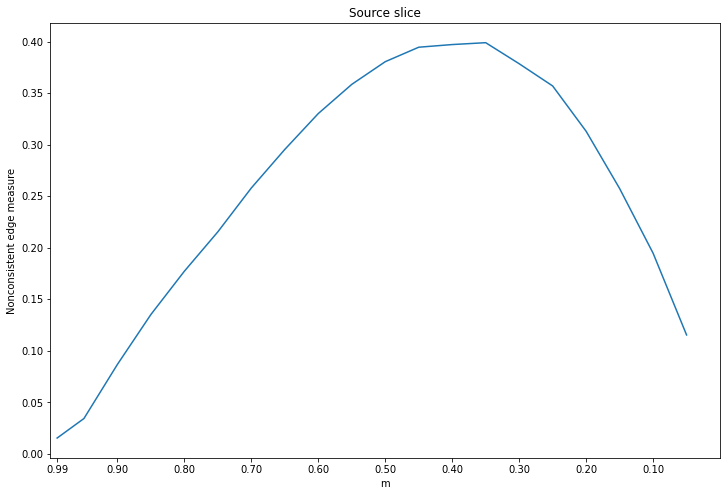

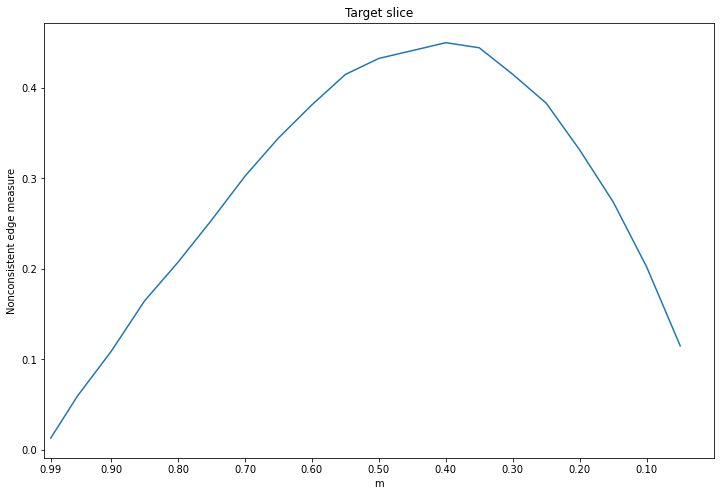

In [37]:
print("convex hull nonconsistent edge measure")
sliceA_measures = []
sliceB_measures = []
for m in m_to_run:
    pi = m_to_pi_sim09_30[m]
    sliceA_measure, sliceB_measure = calculate_convex_hull_noncosistent_edge_measure(sliceA, sliceB, pi)
    sliceA_measures.append(sliceA_measure)
    sliceB_measures.append(sliceB_measure)
    
plot_edge_curve(m_to_run, sliceA_measures, sliceB_measures)